# World Data League 2023 - Phase 2

## 🎯 Challenge
**Avencas Marine Protected Area**

[Challenge Brief](https://drive.google.com/file/d/1RoGTd2f85NEWwJG_GnQHGt_onTyXHO8S/view)

### 🥅 Goal 

The goal of this challenge is to identify variables potentially impacting the marine ecosystem
of the Avencas Marine Protected Area and predict further developments with a special focus
on endangered and invasive species.

### ✅ Outcome 

Create a predictive model that provides insights into future developments of endangered and
invasive species in the AMPA. The model needs to take into consideration the developments
in species during the observation period. A special focus should be put on feature engineering
and in that process identifying potential factors leading to the slower than expected recovery
of the ecosystem using publicly available data.
Ideally the model should be scalable for use in other marine ecosystems where similar data
has been collected.


## Team: Bayes Bunch
## 👥 Authors
* Samantha Hakes
* Mitra Ganeson
* Zhen-Yen Chan
* Stuart McGibbon
* Roisin Holmes

### Proposed product

Our proposed product is two-fold:
1. An open source Data Science repository to aid in modelling of coastal ecosystems. This can be generalised to other datasets to make it more scalable. 
2. A dashboard that can be used as a visualisation tool to allow people to see key insights on what variables impact marine coastal eco-systems, and also uses scenario modelling to identify potential ways to improve sustainable management of these eco-systems.

As part of the open source repo, we have defined generalised modules that you can input different data sets into. These can be seen on our github here:  https://github.com/StuartJMc/beautiful-sea

However, for the purpose of this notebook submission we have listed these below (and how we would group the functions into different modules - .py files). Most of these are generalised functions that can be used for different data sets and different regions.  However, as expected, some will be used for pre-processing our specific datasets, these will be noted below. You can find the helper functions in the section [here](#helper_section). However, if you want to skip to the reading in of the data and the main development using the functions, you can direct yourself to [here](#development_section). We have included hyperlinks to the functions when we have used them if you would like to understand what they are meant to do.


## 💻 Development

### Reading in packages:

In [ ]:
!pip install pmdarima

In [ ]:
import sys
import numpy as np
import pandas as pd
import numpy as np
import statsmodels.api as sm
import pmdarima as pm
import matplotlib.pyplot as plt
import seaborn as sns
import os
import mlflow
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

# sys.path.append('..')

### Defining helper functions <a name ='helper_section'></a>


#### <u>helpers - label_eng.py:</u>
This module contains functions for creating target variable for species predictions

In [ ]:
#Imports needed for this specific .py file:
import functools as ft

import numpy as np
import pandas as pd

**group_by_sample_date:** <a name ='group_by_sample_date'></a>

In [ ]:
def group_by_sample_date(
    df: pd.DataFrame, target_col: str, group: list[str], agg_col: str = "occurrence"
) -> pd.DataFrame:
    """Custom groupby to first group by sample id then by chosen grouping.

    Justification: As number of samples per date is not consistent, we need to group by sample id first to get the total number of species per sample. Then take the mean sample per date/area

    Args:
        df : DataFrame to be grouped.
        target_col : Name of aggregated column passed out.
        group: A list of the grouping hierarchy (after sample_id grouping)
        agg_col : Value to be aggregated. Defaults to "occurrence".

    Returns:
        grouped dataframe.
    """
    df_sample_grouped = (
        df.groupby(["sample_id"] + group)[agg_col]
        .sum()
        .rename(target_col)
        .reset_index()
    )
    df_date_grouped = df_sample_grouped.groupby(group)[target_col].mean().reset_index()

    return df_date_grouped

**sessil_to_count_convertion:** <a name ='sessil_to_count_convertion'></a>

This can be generalised to other datasets that also have sessil and mobil data. However, this may not be needed if the dataset does not have both of these

In [ ]:
def sessil_to_count_convertion(df: pd.DataFrame) -> pd.Series:
    """Represent Percentage coverage of sessil species as a count.

    Justification: to aggregate sessil and mobil abundance values together. This reflects the conversion in the ampa report.

    Source->https://www.researchgate.net/publication/262458621_Human_Disturbance_in_a_Tropical_Rocky_Shore_Reduces_Species_Diversity
    """
    # calculate the totals and number of samples for both mobil and sessil
    n_sessil = df[df["is_mobil"] == False]["occurrence"].sum()
    n_sessil_samples = df[df["is_mobil"] == False]["sample_id"].nunique()
    n_mobil = df[df["is_mobil"] == True]["occurrence"].sum()
    n_mobil_samples = df[df["is_mobil"] == True]["sample_id"].nunique()

    # only need to do this if both sessil and mobil species are present
    if (n_mobil > 0) and (n_sessil > 0):
        mobil_sessil_ratio = (n_sessil / n_sessil_samples) / (n_mobil / n_mobil_samples)

        adjusted_col = df.apply(
            lambda row: row["occurrence"] * mobil_sessil_ratio
            if row["is_mobil"] == False
            else row["occurrence"],
            axis=1,
        )

        return adjusted_col

    else:
        return df["occurrence"]

**calculate_biodiversity_metric:** <a name ='calculate_biodiversity_metric'></a>

This is used to reflect diversity, the calculations for this can be found here: https://www.statology.org/shannon-diversity-index/#:~:text=The%20Shannon%20Diversity%20Index%20.

In [ ]:
def calculate_biodiversity_metric(group: pd.DataFrame, count_convertion = True) -> pd.Series:
    """Calculate shannon diversity index and shannon equitability index.

    Justification: To have a metric that reflects the diversity of the overall community. This is a standard metric used in ecology.

    info-> https://www.statology.org/shannon-diversity-index/#:~:text=The%20Shannon%20Diversity%20Index%20(sometimes,i%20*%20ln(pi)

    Args:
        group : grouped dataframe
        count_convertion: True or False depending on if a variable needs to be converted to a count

    Returns:
        results: pandas series containing shannon diversity index and shannon equitability index
    """
    df = group.copy()[group["occurrence"] > 0]

    if df["species"].nunique() > 1:
        
        #This may not be required depending on data set
        if count_convertion ==True:
            # Convert the sessil species to count
            df["occurrence"] = sessil_to_count_convertion(df)
            
        # Calculate the proportion of each species in the total count
        proportions = df.groupby("species").occurrence.sum() / df.occurrence.sum()

        # Calculate the Shannon diversity index
        shannon_index = -sum(proportions * np.log(proportions))

        # Calculate the weighted diversity score by multiplying the Shannon index with coverage
        shannon_equitability_index = shannon_index / np.log(df["species"].nunique())
        return pd.Series(
            {
                "shannon_index": shannon_index,
                "shannon_equitability_index": shannon_equitability_index,
            }
        )
        # return pd.Series(shannon_index,shannon_equitability_index)
    else:
        return pd.Series({"shannon_index": 0, "shannon_equitability_index": 0})

**create_target_table:**<a name ='create_target_table'></a>

This is more specific to the dataset containing mobil and sessil species, if the inputted dataset widely differs an alternate function can be created

In [ ]:
def create_target_table(df_all):
    """Creates target variables aggregated at the date, zone and tidal level.

    Params:
        - df_all: cleaned features table

    Returns:
        - df_targets: table with target columns for each datetime, zone and tidal level
    """
    # the level of the final aggregation
    dt_group = ["dt", "zone", "supratidal_or_middle_intertidal"]

    df_sessile_to_count = df_all[df_all.is_mobil == False]
    df_mobile_to_count = df_all[df_all.is_mobil == True]

    # calculate target related to invasive species
    # assumption: treat invasive == unknown as non-invasive
    df_sessile_to_count.loc[:, "invasive"] = (
        df_sessile_to_count.loc[:, "invasive"]
        .apply(lambda x: x.replace("unknown", "No"))
        .copy()
    )
    df_total_by_invasive = group_by_sample_date(
        df_sessile_to_count,
        target_col="total_occurrence",
        group=dt_group + ["invasive"],
    )
    # pivot to get one column for invasive and one column for non-invasive
    target_invasive = pd.pivot_table(
        df_total_by_invasive,
        values="total_occurrence",
        index=dt_group,
        columns=["invasive"],
    )
    target_invasive.rename(
        columns={"No": "total_non_invasive_sessile", "Yes": "total_invasive_sessile"},
        inplace=True,
    )

    # calculated targets related to endangered status
    # assumption: defined our own endangered status groups (see data dict)
    df_total_by_endangered = group_by_sample_date(
        df_mobile_to_count,
        target_col="total_occurrence",
        group=dt_group + ["endangered"],
    )
    # pivot to get one column for each endangered status
    target_endangered = pd.pivot_table(
        df_total_by_endangered,
        values="total_occurrence",
        index=dt_group,
        columns=["endangered"],
    )
    target_endangered.rename(
        columns={
            "endangered": "total_endangered_mobile",
            "not_endangered": "total_not_endangered_mobile",
            "potentially_endangered": "total_pot_endangered_mobile",
        },
        inplace=True,
    )

    # As the unique values can't be combined again, multiple aggregations are needed at dt/zpne/supra_medium and just date
    # avoid divide by zero error
    df_non_zero = df_all[df_all.occurrence > 0]
    # create biodiversity index
    # idea: using the shannon index to calculate the biodiversity(as in ampa paper)
    shannon_dt_group = (
        df_non_zero.groupby(dt_group)
        .apply(
            lambda x: calculate_biodiversity_metric(
                x[["species", "occurrence", "is_mobil", "sample_id"]]
            )
        )
        .rename(
            columns={
                "shannon_index": "shannon_index_dt_z_sm",
                "shannon_equitability_index": "shannon_equitability_index_dt_z_sm",
            }
        )
    ).reset_index()

    # groupby date
    shannon_date = df_non_zero.groupby("date").apply(
        lambda x: calculate_biodiversity_metric(
            x[["species", "occurrence", "is_mobil", "sample_id"]]
        )
    )

    # join all target columns together at dt/zone/supratidal_or_middle_intertidal level
    dfs = [
        target_invasive,
        target_endangered,
        shannon_dt_group,
    ]
    df_targets_dt = ft.reduce(
        lambda left, right: pd.merge(left, right, how="outer", on=dt_group),
        dfs,
    )
    df_targets_dt["date"] = df_targets_dt["dt"].dt.date

    # join all target columns together at date level
    dfs = [df_targets_dt, shannon_date]
    df_targets_all = ft.reduce(
        lambda left, right: pd.merge(left, right, how="outer", on="date"),
        dfs,
    )

    # drop rows with no dt
    df_targets_all.dropna(subset=["dt"], inplace=True)

    return df_targets_all

#### <u>helpers - feature_eng.py:</u>
This module contains all functions for adding additional features. Some of these are specific to the datasets we are using

In [ ]:
#Imports needed for this specific .py file:
import functools as ft

import numpy as np
import pandas as pd
import requests
import xarray as xr

**add_time_features**<a name ='add_time_features'></a>

In [ ]:
def add_time_features(df, dt_col="dt"):
    """Adds cyclical and linear time features. These could be used for modelling.

    Args:
        df (pd.DataFrame): dataframe containing datetime column
    """
    df = df.copy()
    df["date"] = df[dt_col].dt.date
    df["year"] = df[dt_col].dt.year
    df["year_month"] = df[dt_col].dt.strftime("%Y-%m")

    df["weekofyear_sin"] = np.sin(
        df[dt_col].dt.strftime("%W").astype(int) * (2 * np.pi / 52)
    )
    df["weekofyear_cos"] = np.cos(
        df[dt_col].dt.strftime("%W").astype(int) * (2 * np.pi / 52)
    )
    df["month_sin"] = np.sin(df[dt_col].dt.month * (2 * np.pi / 12))
    df["month_cos"] = np.cos(df[dt_col].dt.month * (2 * np.pi / 12))

    return df

**create_ampa_features**<a name ='create_ampa_features'></a>

In [ ]:
def create_ampa_features(df_ampa: pd.DataFrame) -> pd.DataFrame:
    """Add features from AMPA data for modelling. This may need adjusting for other sources.

    Args:
        df (pd.DataFrame): Cleaned AMPA dataset

    Returns:
        pd.DataFrame: AMPA dataset with engineered features
    """
    df_tide = (
        df_ampa.groupby(["dt", "zone", "supratidal_or_middle_intertidal"])
        .tide.agg(
            tide_max="max",
            tide_min="min",
            tide_mean="mean",
        )
        .reset_index()
    )

    # EDA showed that max and min don't vary by this group, so no need to include all
    df_water_temp = (
        df_ampa.groupby(["dt", "zone", "supratidal_or_middle_intertidal"])
        .water_temperature.agg(
            water_temp_max="max",
        )
        .reset_index()
    )

    df_features = df_tide.merge(
        df_water_temp, on=["dt", "zone", "supratidal_or_middle_intertidal"]
    )

    return df_features


**get_weather_data**<a name ='get_weather_data'></a>

This can be used to get data for other lat/lon and for other dates. The data can be found from "https://archive-api.open-meteo.com/v1/archive"

In [ ]:
def get_weather_data(
    lat=38.70, lon=-9.42, start_date="2011-01-01", end_date="2020-12-31"
):
    """Get weather data from meteo API. URL and API query provided below for replication"""
    # API URL
    url = "https://archive-api.open-meteo.com/v1/archive"

    # Parameters for near cascais
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start_date,
        "end_date": end_date,
        "daily": "temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,precipitation_sum,precipitation_hours",
        "timezone": "Europe/London",
    }

    response = requests.get(url, params=params)

    if response.status_code == 200:
        data = response.json()
        df = pd.DataFrame(data)
    else:
        print("Error: Failed to fetch data from the API.")

    df = df.daily.apply(pd.Series).T

    df["date"] = pd.to_datetime(df["time"]).dt.date
    df.drop(columns=["time"], inplace=True)
    return df

**load_uea_netcdf_file**<a name ='load_uea_netcdf_file'></a>

This is generalised for the netcdf files

https://www.uea.ac.uk/groups-and-centres/climatic-research-unit/data

In [ ]:
def load_uea_netcdf_file(
    filepath, lat=37.5, lon=-7.5, start_date="2010-01-01", end_date="2021-12-31"
):
    """
    Loads a netCDF file containing University of East Anglia Climate data into a pandas DataFrame.

    Data is in 5 x 5 degree grid cells. So the below source can be used to find the suitable coords.

    Source -> https://www.uea.ac.uk/groups-and-centres/climatic-research-unit/data
    Acknowledgement->  Morice et al. (2021) and Osborn et al. (2021) https://crudata.uea.ac.uk/cru/data/temperature/?_ga=2.111816964.1851588793.1684357938-1486011184.1682889046#sciref

    Parameters:
        - filepath: The path to the netCDF file to load.

    Returns:
        A pandas DataFrame containing the data from the netCDF file.
    """
    # Load the netCDF file using xarray
    ds = xr.open_dataset(filepath)

    # Convert the data to a pandas DataFrame
    df = ds.to_dataframe()

    # Reset the index to use the time and other dimensions as columns
    df.reset_index(inplace=True)

    # Optional: Rename columns to remove the `__` separator
    df.columns = [col.replace("__", "") for col in df.columns]

    # Filter the rows that are in the 5 by 5 grid centred on -7.5 longitude and 37.5 latitude
    mask = (df.longitude == lon) & (df.latitude == lat)
    df = df[mask].drop_duplicates(subset=["time"])

    # drop columns that aren't needed
    df.drop(
        columns=[
            "latitude",
            "longitude",
            "time_bnds",
            "latitude_bnds",
            "longitude_bnds",
            "bnds",
        ],
        inplace=True,
    )

    if "realization" in df.columns:
        df.drop(columns=["realization", "realization_bnds"], inplace=True)

    # filter for time range
    df = df[(df.time >= start_date) & (df.time <= end_date)]

    # convert to year month for koin
    df["year_month"] = df["time"].dt.strftime("%Y-%m")

    df.drop(columns=["time"], inplace=True)

    return df

    return df


**get_uea_data**<a name ='get_uea_data'></a>

This specifcally mentions the files we use for the uea data, however a version of this could be reused to other datasets. For this to run in this specific notebookit requires downloading the data we have used and putting in the data

In [ ]:
def get_uea_data(uea_data_folder="../data/crudata"):
    """Fetches and transformes UEA data for modelling
    
    Source -> https://www.uea.ac.uk/groups-and-centres/climatic-research-unit/data
    Acknowledgement->  Morice et al. (2021) and Osborn et al. (2021) https://crudata.uea.ac.uk/cru/data/temperature/?_ga=2.111816964.1851588793.1684357938-1486011184.1682889046#sciref

    Args:
        uea_data_folder (str, optional): Local path to uea data. Defaults to "../data/crudata".

    Returns:
        _type_: _description_
    """
    # get university of east anglia data
    df_hadsst = load_uea_netcdf_file(uea_data_folder + "/HadSST.4.0.1.0_median.nc")
    df_hadsst.rename(columns={"tos": "sea_surface_temp_anomaly"}, inplace=True)

    df_crutem = load_uea_netcdf_file(
        uea_data_folder + "/CRUTEM.5.0.1.0.alt.anomalies.nc"
    )
    df_crutem.rename(columns={"tas": "land_air_temp_anomaly"}, inplace=True)

    df_hadcrut = load_uea_netcdf_file(
        uea_data_folder + "/HadCRUT.5.0.1.0.analysis.anomalies.ensemble_mean.nc"
    )
    df_hadcrut.rename(
        columns={"tas_mean": "sea_air_combined_temp_anomaly"}, inplace=True
    )

    # join all tables together (at month level)
    dfs = [df_hadsst, df_hadcrut, df_crutem]
    df = ft.reduce(
        lambda left, right: pd.merge(left, right, on="year_month", how="left"), dfs
    )

    return df

**fetch_copernicus_data**<a name ='fetch_copernicus_data'></a>

This can generalise to other copernicus data files

In [ ]:
def fetch_copernicus_data(file_path: str) -> pd.DataFrame:
    """function reads netCDF files from Copernicus into pandas dataframes,
    aggregates to the date level, and outputs a dataframe"""
    # read in .nc file
    DS1 = xr.open_dataset(file_path)

    # convert to dataframe
    df = DS1.to_dataframe()

    # reset the index
    df = df.reset_index(level=[0, 1, 2, 3])

    # aggregate to date level (mean taken of all points nearby)
    df = df.groupby(by=["time"]).mean().reset_index()

    # removal of redundant columns
    df = df.drop(labels=["latitude", "longitude", "depth"], axis=1)

    return df

**prep_copernicus_data**<a name ='prep_copernicus_data'></a>

In [ ]:
def prep_copernicus_data(df1: pd.DataFrame, df2: pd.DataFrame) -> pd.DataFrame:
    """function combines copernicus marine data at the date level"""

    df = df1.merge(df2, how="outer", on="time")
    df.rename(columns={"time": "date"}, inplace=True)

    df["date"] = pd.to_datetime(df["date"]).dt.date

    return df

**get_copernicus_data**<a name ='get_copernicus_data'></a>

In [ ]:
def get_copernicus_data(copernicus_data_folder="../data/copernicus"):
    """Fetches and transforms copernicus data for modelling."""
    # get copernicus data
    df_copernicus1 = fetch_copernicus_data(
        copernicus_data_folder + "/cmems_mod_glo_phy_my_0.083_P1D-m_1683577362247.nc"
    )
    df_copernicus2 = fetch_copernicus_data(
        copernicus_data_folder
        + "/cmems_mod_ibi_bgc_my_0.083deg-3D_P1D-m_1683666099015.nc"
    )

    # combine copernicus data
    df_copernicus = prep_copernicus_data(df_copernicus1, df_copernicus2)

    return df_copernicus

**fetch_AQI_data**<a name ='fetch_AQI_data'></a>

In [ ]:
def fetch_AQI_data(file_path: str) -> pd.DataFrame:
    """Function reads csv files from WAQI into pandas dataframes, removes whitespace from column names,
    replaces whitespace fields with NaN, and outputs a dataframe"""

    # read in data
    df = pd.read_csv(file_path)

    # rename columns (remove whitespace at start of names)
    df.rename(
        columns={
            " pm25": "pm25",
            " pm10": "pm10",
            " o3": "o3",
            " no2": "no2",
            " so2": "so2",
        },
        inplace=True,
    )

    # replace whitespace fields with NaN
    df = df.replace(r"^\s*$", np.nan, regex=True)

    return df

**prep_AQI_files**<a name ='prep_AQI_files'></a>

In [ ]:
def prep_AQI_files(
    df1: pd.DataFrame, df2: pd.DataFrame, df3: pd.DataFrame
) -> pd.DataFrame:
    """Function takes three nearby AQI dataframes, cleans and aggregates to date level."""
    # concatenate three dataframes
    df = pd.concat([df1, df2, df3])

    # convert date field to datetime type
    df["date"] = pd.to_datetime(df["date"]).dt.date

    # convert remaining columns to float type
    df["pm25"] = pd.to_numeric(df["pm25"])
    df["pm10"] = pd.to_numeric(df["pm10"])
    df["o3"] = pd.to_numeric(df["o3"])
    df["no2"] = pd.to_numeric(df["no2"])
    df["so2"] = pd.to_numeric(df["so2"])

    # aggregate to date level by taking average of three files
    df = df.groupby(by=["date"]).mean().reset_index()

    return df

**get_AQI_data**<a name ='get_AQI_data'></a>

In [ ]:
def get_AQI_data(AQI_data_folder="../data/AQI"):
    """Fetches and transforms AQI data for modelling."""
    # get AQI data
    df_AQI_1 = fetch_AQI_data(
        AQI_data_folder + "/entrecampos,-lisboa, portugal-air-quality.csv"
    )
    df_AQI_2 = fetch_AQI_data(
        AQI_data_folder + "/mem-martins, sintra, portugal-air-quality.csv"
    )
    df_AQI_3 = fetch_AQI_data(
        AQI_data_folder + "/olivais,-lisboa, portugal-air-quality.csv"
    )

    # combine AQI data
    df_AQI = prep_AQI_files(df_AQI_1, df_AQI_2, df_AQI_3)

    return df_AQI

**get_ohi_data**<a name ='get_ohi_data'></a>

This can be generalised to region

In [ ]:
def get_ohi_data(filepath="data/OHI/scores.csv", s="183"):
    """
    Get Ocean Health Index data, filter the data and prep for modelling

    Args:
        df_ohi (pd.DataFrame): input data
        s (str): input region

    Returns:
        pd.DataFrame: output data
    """
    # Load and convert csv data into pandas dataframe
    data = []
    col = []
    checkcol = False
    with open(filepath) as f:
        for val in f.readlines():
            val = val.replace("\n", "")
            val = val.split(",")
            if checkcol is False:
                col = val
                checkcol = True
            else:
                data.append(val)
    df = pd.DataFrame(data=data, columns=col)

    # Filter data to show only portugal data
    df_region = df[df.region_id == s]

    # Drop irrelevant columns
    df_region = df_region.drop(["region_name", "region_id"], axis=1)

    # Rename columns for readability
    df_region = df_region.rename(columns={"scenario": "year", "value": "score"})

    # Prep and further filter the data for biodiversity, habitat and species goals only
    goal_list = ["Biodiversity", "Habitat (subgoal)", "Species condition (subgoal)"]
    dimension_list = ["status", "future"]
    filtered_df = df_region[df_region["long_goal"].isin(goal_list)]
    filtered_df = filtered_df[df_region["dimension"].isin(dimension_list)]

    filtered_df["metric"] = (
        filtered_df.long_goal.str.split(" \(").str[0].str.lower()
        + "_"
        + filtered_df.dimension
    )
    filtered_df = filtered_df.drop(["long_goal", "dimension"], axis=1)

    # Convert the date column to a datetime format
    filtered_df["year"] = pd.to_datetime(filtered_df.year, format="%Y").dt.year
    filtered_df["score"] = pd.to_numeric(filtered_df.score)

    filtered_df = filtered_df.pivot_table(
        index="year", columns="metric", values="score", fill_value=0
    ).reset_index()

    return filtered_df

#### <u>helpers - ampa_process.py</u>:

Helper Functions to load and clean AMPA data. This is specific to the data we have been provided

In [ ]:
#Imports needed for this specific .py file:
import datetime
import functools as ft
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import xarray as xr

**load_ampa_excel_data**<a name ='load_ampa_excel_data'></a>

In [ ]:
def load_ampa_excel_data(file_path, sheet_number=0, header=0):
    """
    Loads data from the provided ampa Excel file into a Pandas DataFrame. Makes necessary reformatting prior to data wrangling

    Parameters:
    file_path (str): The path to the Excel file.
    sheet_number (int): The index of the sheet to load (zero-indexed).
    header (int): The row index to use as column names (zero-indexed).

    Returns:
    df (pd.DataFrame): The loaded data.
    """
    xl = pd.ExcelFile(file_path)
    sheet_name = xl.sheet_names[sheet_number]
    df = pd.read_excel(file_path, sheet_name=sheet_name, header=header)

    # Convert the column names to lowercase with underscores instead of spaces.
    df.columns = df.columns.str.lower().str.strip().str.replace(" ", "_")

    # remove enirely na columns
    df = df.dropna(axis=0, how="all").dropna(axis=1, how="all")

    # remove rows with no date info
    if "date" in df.columns:
        df = df.dropna(axis=0, how="all", subset=["date"])

    # rename some of the columns
    if "water_temperature_(ºc)" in df.columns:
        df.rename(
            columns={
                "water_temperature_(ºc)": "water_temperature",
                "supratidal/middle_intertidal": "supratidal_or_middle_intertidal",
            },
            inplace=True,
        )
    elif "invasive_(yes/no)" in df.columns:
        df.rename(
            columns={
                "invasive_(yes/no)": "invasive",
                "conservation_status_(iucn)": "conservation_status_iucn",
            },
            inplace=True,
        )

    return df

**clean_species**<a name ='clean_species'></a>


In [ ]:
def clean_species(df: pd.DataFrame) -> pd.DataFrame:
    """Apply specific cleaning steps to the species columns of a dataframe

    Args:
        df : dataset from ampa

    Returns:
        clean data set with species columns formatted and melted into a single column
    """
    # add a column to identify the sample
    df["sample_id"] = df.index

    # manually created list of no species columns in both dfs
    non_species_columns = [
        "sample_id",
        "date",
        "hour",
        "tide",
        "weather_condition",
        "water_temperature",
        "sampler",
        "zone",
        "supratidal_or_middle_intertidal",
        "substrate",
        "total",
        "abundance_(ind/m2)",
        "abundance",
        "column1",
        "total2",
        "observações",
        "coluna1",
        "coluna2",
    ]

    # get list of species from columns of data sets
    species_columns = [x for x in df.columns if x not in non_species_columns]

    # replace any non numeric value with a Nan
    for col in species_columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    # df[species_columns]=df[species_columns].replace(to_replace=r'[^0-9.-]+', value=np.nan, regex=True)

    # drop any row that is nan for all species
    df = df.dropna(axis=0, how="all", subset=species_columns)

    # convert all columns to float
    df[species_columns] = df[species_columns].astype("float")

    # fill ramainder with 0
    df[species_columns] = df[species_columns].fillna(value=0)

    # melt species into a single column
    # this will make future processing steps easier
    df = pd.melt(
        df,
        id_vars=[
            "sample_id",
            "date",
            "hour",
            "tide",
            "weather_condition",
            "water_temperature",
            "sampler",
            "zone",
            "supratidal_or_middle_intertidal",
            "substrate",
        ],
        value_vars=species_columns,
        var_name="species",
        value_name="occurrence",
    )

    # remove _(...) from species names to allow for joins
    df["species"] = df["species"].str.replace(r"_\([^)]*\)", "", regex=True)

    return df

**map_mobil_species**<a name ='map_mobil_species'></a>

In [ ]:
def map_mobil_species(species_col: pd.Series) -> pd.Series:
    """Apply mappings from mobil species (in AMPA table) to IUCN species, to allow for classifications"""
    mobil_mapping = {
        "sabellaria_alveolata": "worm_non_identified",
        "peixe_juvenil_n.i.": "juvenil_fish_non_identified",
        "juvenis_de_lagosta/lavagante": "crab_non_identified",
        "caranguejo_n.i.": "crab_non_identified",
        "syngnathus": "syngnathus_sp.",
        "poliqueta_n.i.": "worm_non_identified",
        "nereis_sp.": "worm_non_identified",
    }

    return species_col.copy().replace(mobil_mapping)

**map_sessil_species**<a name ='map_sessil_species'></a>

In [ ]:
def map_sessil_species(species_col: pd.Series) -> pd.Series:
    """Apply mappings from sessil species (in AMPA table) to IUCN species, to allow for classifications"""
    sessil_mapping = {
        "sabellaria_alveolata_": "sabellaria_alveolata",
        "ceramium": "ceramium_sp",
        "condracanthus": "condracanthus_sp",
        "alga_vermelha_filamentosa": "red_algae_non_identified",
        "alga_vermelha_vesicular": "red_algae_non_identified",
        "alga_vermelha_laminada": "red_algae_non_identified",
        "alga_vermelha_carnuda": "red_algae_non_identified",
        'alga_vermelha_"encaracolada"': "red_algae_non_identified",
        "alga_vermelha_semelhante_a_ulva_rigida": "red_algae_non_identified",
        "porphira": "porphira_sp",
        "alga_vermelha_ramificada": "red_algae_non_identified",
        "limo_n.i.": "lime_non_identify",
        "alga_verde_carnuda_ramificada": "green_algae_non_identified",
        "nemoderma_sp.(alga_tipo_musgo)": "nemoderma_sp.",
        "alga_verde_tufosa": "green_algae_non_identified",
        "alga_verde": "green_algae_non_identified",
        "alga_verde_incrustante": "green_algae_non_identified",
        "alga_verde_n.i.": "green_algae_non_identified",
        "alga_verde_filamentosa": "green_algae_non_identified",
        "dictyota_castanha": "dictyota_sp.",
        "alga_castanha_sp.": "brown_algae_non_identified",
        "alga_castanha_laminada": "brown_algae_non_identified",
        "alga_castanha_filamentosa": "brown_algae_non_identified",
        "alga_castanha_incrustante": "brown_algae_non_identified",
        "alga_castanha_carnuda": "brown_algae_non_identified",
        "alga_castanha_tufosa": "brown_algae_non_identified",
        "alga_verde/azul_-_lavanda": "green_algae_non_identified",
    }

    return species_col.copy().replace(sessil_mapping)

**clean_inva_cov**<a name ='clean_inva_cov'></a>

In [ ]:
def clean_inva_cov(df: pd.DataFrame) -> pd.DataFrame:
    """Clean and concat invasive and conservation status table from ampa data.
    Data was split into two tables (as tables were side by side in excel), sessil and mobil, and then merged into a single table.
    """
    sessil_cut = df.copy()[["sessil_species", "invasive", "conservation_status_iucn"]]
    sessil_cut.columns = ["species", "invasive", "conservation_status_iucn"]
    sessil_cut = sessil_cut.dropna(how="all")

    mobil_cut = df.copy()[
        ["mobil_species", "invasive_(yes/no).1", "conservation_status_(iucn).1"]
    ]
    mobil_cut.columns = ["species", "invasive", "conservation_status_iucn"]
    mobil_cut = mobil_cut.dropna(how="all")

    df_combined = pd.concat([sessil_cut, mobil_cut], ignore_index=True)

    df_combined["species"] = (
        df_combined["species"].str.lower().str.strip().str.replace(" ", "_")
    )

    # add endangered column
    df_combined["endangered"] = df_combined["conservation_status_iucn"].apply(
        endangered_status
    )

    return df_combined.drop_duplicates()

**convert_hour_to_time**<a name ='convert_hour_to_time'></a>

This is more of a generalised function

In [ ]:
# build a function to handle the 0.44554 and 9.00 type times
def convert_hour_to_time(x):
    """Helper function to convert erroneous time values"""
    # assuming fraction is of the day
    pattern1 = r"(\d+\.\d{3,})"
    pattern2 = r"(\d{1,2}\.\d{2})"
    if bool(re.match(pattern1, x)):
        seconds = float(x) * 24 * 60 * 60
        return datetime.datetime.fromtimestamp(seconds).time()

    elif bool(re.match(pattern2, x)):
        return datetime.datetime.strptime(x, "%H.%M").time()
    else:
        return x


**clean_time_columns**<a name ='clean_time_columns'></a>

In [ ]:
def clean_time_columns(df):
    """Resolve data quality issues highlighted in the data investigation on time columns."""
    # find rows where 'datetime' does not match the 'HH:MM:SS' format
    df["time"] = df["hour"].astype(str).apply(lambda x: convert_hour_to_time(x))
    df.drop(columns=["hour"], inplace=True)

    # extract only the date and fix any erroneous data
    df["date"] = df["date"].astype("str")
    df["date"] = df["date"].str.replace("23-04-01-2020", "23-01-2020")
    df["date"] = df["date"].str.replace(" 00:00:00", "")

    # combine date and time into a datetime column
    df["dt"] = pd.to_datetime(
        df["date"] + " " + df["time"].astype("str"), errors="coerce"
    )

    # extract from datetime so that it's more consistent
    df["date"] = df["dt"].dt.date
    df["year_month"] = df["dt"].dt.strftime("%Y-%m")
    df["year"] = df["dt"].dt.year

    return df


**reorder_substrates**<a name ='reorder_substrates'></a>

In [ ]:
def reorder_substrates(x):
    """Sort substrates alphabetically and return as a string."""
    if "/" in str(x):
        list = x.split("/")
        list = sorted(list)
        string = "/".join(list)
        return string
    else:
        return x


**clean_categorical_columns**<a name ='clean_categorical_columns'></a>

In [ ]:
def clean_categorical_columns(df):
    """Apply actions determined from investigation of categorical columns."""
    # clean zones
    df["zone"] = df["zone"].str.strip()

    # drop all rows with Zone F
    df.drop(df[df["zone"] == "F"].index, inplace=True)

    # Replace erroneous tide values and convert to float
    df["tide"] = df["tide"].replace({"0,7": "0.7", "0;9": "0.9"}).astype("float")

    # Replace values above 87 with 0.87
    df["tide"] = df["tide"].apply(lambda x: 0.87 if x >= 87 else x)

    # Replace 2.4 with 1.4
    df["tide"] = df["tide"].apply(lambda x: 1.4 if x == 2.4 else x)

    # clean supratidal_or_middle_intertidal
    df["supratidal_or_middle_intertidal"] = (
        df["supratidal_or_middle_intertidal"]
        .str.lower()
        .str.strip()
        .replace("super", "supra")
    )

    # clean substrate
    df["substrate"] = df["substrate"].str.lower().str.strip().replace(" ", "")
    df["substrate"] = df["substrate"].apply(lambda x: reorder_substrates(x)).str.strip()

    return df


**endangered_status**<a name ='endangered_status'></a>

In [ ]:
def endangered_status(x):
    """Convert IUCN conservation status to endangered status. Methodology based on https://www.nature.com/articles/s42003-022-03638-9"""
    if x == "least concern (LC)":
        return "not_endangered"
    elif x == "commercially threatened (CT)*":
        return "endangered"
    else:
        return "potentially_endangered"

**clean_na**<a name ='clean_na'></a>

In [ ]:
def clean_na(df):
    """
    A few steps to deal with missing values, including interpolating tide, water_temperature and substrate missing values with the last available value for that datetime and zone sample.

    Params:
        - df: dataframe to clean

    Returns:
        - df_clean: dataframe with no missing values
    """
    df_clean = df.copy()

    # replace blank values with NaN
    df_clean.water_temperature.replace({" ": np.NaN}, inplace=True)

    # drop null substrate rows for sessile (based on SME Q&A)
    df_clean.drop(
        df_clean[(df_clean["is_mobil"] == False) & (df_clean.substrate.isnull())].index,
        inplace=True,
    )

    # sort rows by zone then by datetime for interpolating
    df_clean.sort_values(by=["zone", "dt"], inplace=True)
    df_clean.reset_index(drop=True, inplace=True)
    # fill missing substrate values with the previous row
    df_clean.interpolate(method="pad", inplace=True)

    return df_clean

**get_ampa_data**<a name ='get_ampa_data'></a>

In [ ]:
def get_ampa_data(excel_path):
    """Main pipeline for loading, cleaning and combining AMAP data."""
    # load separate dataframes
    df_sessil = load_ampa_excel_data(excel_path, sheet_number=0)
    df_mobil = load_ampa_excel_data(excel_path, sheet_number=1)
    df_inva_conv = load_ampa_excel_data(excel_path, sheet_number=2, header=1)

    # melt all species into a single column clean up the species columns (for the join)
    df_mobil_cleaned = clean_species(df_mobil.copy())
    df_sessil_cleaned = clean_species(df_sessil.copy())
    # adjust sample id for sessil so that id is unique for both
    df_sessil_cleaned["sample_id"] = (
        df_sessil_cleaned["sample_id"] + df_mobil_cleaned.sample_id.max() + 1
    )

    # clean up inva_cov (for the join)
    df_inva_conv_cleaned = clean_inva_cov(df_inva_conv.copy())

    # apply manually created mapping (for the join)
    df_mobil_cleaned["species"] = map_mobil_species(df_mobil_cleaned["species"])
    df_sessil_cleaned["species"] = map_sessil_species(df_sessil_cleaned["species"])

    # combine mobil and sessil data
    df_mobil_cleaned["is_mobil"] = True
    df_sessil_cleaned["is_mobil"] = False
    df_cleaned = pd.concat([df_mobil_cleaned, df_sessil_cleaned])

    # join invasive and conservation data
    df_cleaned = df_cleaned.merge(df_inva_conv_cleaned, how="left", on="species")

    # fill na from join with unkown
    df_cleaned["invasive"] = df_cleaned["invasive"].fillna("unknown")
    df_cleaned["conservation_status_iucn"] = df_cleaned[
        "conservation_status_iucn"
    ].fillna("unknown")

    # clean time columns
    df_cleaned = clean_time_columns(df_cleaned)

    # deal with missing values
    df_cleaned = clean_na(df_cleaned)

    # clean categorical columns
    df_cleaned = clean_categorical_columns(df_cleaned)

    # convert water_temperature to float
    df_cleaned["water_temperature"] = df_cleaned["water_temperature"].astype("float")

    return df_cleaned

#### <u>helpers - data_prep.py</u>:
This module collects all data processing steps and creates the pipeline for creating the feature table. 

In [ ]:
#Imports needed for this specific .py file:
import pandas as pd
import numpy as np
import functools as ft

#If using the helper modules you could import the below from the above .py files. However, for the purpose
#of this notebook, the functions have been individually defined above

# from .feature_eng import (
#     add_time_features,
#     create_ampa_features,
#     get_AQI_data,
#     get_copernicus_data,
#     get_ohi_data,
#     get_uea_data,
#     get_weather_data,
# )

# from .label_eng import create_target_table

# from .ampa_process import get_ampa_data

**create_feature_table**<a name ='create_feature_table'></a>

In [ ]:
def create_feature_table(
    uea_data_folder="data/crudata",
    copernicus_data_folder="data/copernicus",
    AQI_data_folder="data/AQI",
    ampa_file="data/AMPA/AMPA_Data_Sample.xlsx",
    ohi_path="data/OHI/scores.csv",
):
    """Create Feature Table for EDA/modelling

    Args:
        uea_data_folder (str, optional):  Defaults to '../data/crudata'.
        copernicus_data_folder (str, optional): Defaults to '../data/copernicus'.
        AQI_data_folder (str, optional): Defaults to '../data/AQI'.
        ampa_file (str, optional): Defaults to '../data/AMPA/AMPA_Data_Sample.xlsx'.
        ohi_path (str, optional):  Defaults to '../data/OHI/scores.csv'.

    Returns:
        feature table
    """

    # get ampa data
    df_ampa = get_ampa_data(ampa_file)

    # create labels at date, zone and tidal level
    df_labels = create_target_table(df_ampa)

    # add time features
    df_labels = add_time_features(df_labels, dt_col="dt")

    # extract feature columns from the ampa data
    df_ampa_features = create_ampa_features(df_ampa)

    # join aggregate labels and features into one table
    df = df_labels.merge(
        df_ampa_features,
        on=["dt", "zone", "supratidal_or_middle_intertidal"],
        how="left",
    )

    # get noaa weather data
    df_weather = get_weather_data()

    # get university of east anglia data
    df_climate = get_uea_data(uea_data_folder)

    # get copernicus data
    df_copernicus = get_copernicus_data(copernicus_data_folder)

    # get AQI data
    df_AQI = get_AQI_data(AQI_data_folder)

    # get ohi data
    df_ohi = get_ohi_data(ohi_path)

    # join all feature columns together (at year level)
    dfs = [df, df_ohi]
    df = ft.reduce(
        lambda left, right: pd.merge(left, right, on="year", how="left"), dfs
    )

    # join all feature columns together (at month level)
    # left join on feature table to keep all months (even if samples are only taken on a small proportion)
    dfs = [df_climate, df]
    df = ft.reduce(
        lambda left, right: pd.merge(left, right, on="year_month", how="left"), dfs
    )

    # join all target columns together (at date level)
    # left join on feature table to keep all dates (even if samples are only taken on a small proportion)
    dfs = [df_weather, df_copernicus, df_AQI, df]
    df = ft.reduce(
        lambda left, right: pd.merge(left, right, on="date", how="left"), dfs
    )

    return df


In [ ]:
# Define Constants
FEATURE_COLUMNS = [
    "tide_max",
    "tide_min",
    "tide_mean",
    "water_temp_max",
    "sea_surface_temp_anomaly",
    "sea_air_combined_temp_anomaly",
    "land_air_temp_anomaly",
    "temperature_2m_max",
    "temperature_2m_min",
    "temperature_2m_mean",
    "apparent_temperature_max",
    "precipitation_sum",
    "precipitation_hours",
    "so",
    "o2",
    "chl",
    "no3",
    "po4",
    "phyc",
    "si",
    "ph",
    "nh4",
    "nppv",
    "dissic",
    "fe",
    "pm25",
    "pm10",
    "o3",
    "no2",
    "so2",
    "biodiversity_future",
    "biodiversity_status",
    "habitat_future",
    "habitat_status",
    "species condition_future",
    "species condition_status",
]

LABEL_COLUMNS = [
    "total_non_invasive_sessile",
    "total_invasive_sessile",
    "total_endangered_mobile",
    "total_not_endangered_mobile",
    "total_pot_endangered_mobile",
    "shannon_index_dt_z_sm",
    "shannon_equitability_index_dt_z_sm",
    "shannon_index_date",
    "shannon_equitability_index_date",
]

DATE_COLUMNS = [
    "dt",
    "year",
    "year_month",
    "weekofyear_sin",
    "weekofyear_cos",
    "month_sin",
    "month_cos",
    "date",
]

LOCATION_COLUMNS = ["zone", "supratidal_or_middle_intertidal"]

#### <u>helpers - data check:</u> 
This module contains useful functions to check the data quality of data sets. This is generalised

In [ ]:
#Imports needed for this specific .py file:
import pandas as pd
import numpy as np

**data_summary**<a name ='data_summary'></a>

In [ ]:
def data_summary(df):
    """
    Perform exploratory data analysis on a given dataset.

    Args:
    df: Pandas DataFrame.

    Returns:
    None
    """

    # Set the maximum number of columns and rows to None
    pd.set_option("display.max_columns", None)
    pd.set_option("display.max_rows", None)

    # Preview the first 5 rows of the dataset
    print("First 5 rows of the dataset:")
    display(df.head())

    # Check the shape of the dataset
    print("Shape of the dataset:", df.shape)

    # Check the data types of each column
    print("Data types of each column:")
    display(df.dtypes)

    # Check for missing values
    print("Missing values per column:")
    display(df.isnull().sum())

    # Descriptive statistics
    print("Descriptive statistics of numerical columns:")
    display(df.describe())

    # Set the maximum number of columns and rows to None
    pd.set_option("display.max_columns", 20)
    pd.set_option("display.max_rows", 20)

#### <u>helpers - plotting.py</u>
This module contains useful functions for plotting the data:

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

**plot_line_plot**<a name ='plot_line_plot'></a>

In [ ]:
def plot_lineplot(
    df,
    ylabel="occurrence",
    xlabel="dt",
    grouping=["dt", "is_mobil"],
    agg="mean",
    hue=None,
):
    # create lineplot

    df_grp = (
        df.groupby(grouping).occurrence.agg(agg).reset_index().sort_values(by=xlabel)
    )

    df_grp_mobil = df_grp[df_grp.is_mobil == True]
    df_grp_sessil = df_grp[df_grp.is_mobil == False]

    # create subplots
    fig, axs = plt.subplots(ncols=2, figsize=(18, 6))

    # plot first Seaborn plot in the first subplot
    sns.lineplot(data=df_grp_mobil, x=xlabel, y=ylabel, ax=axs[0], hue=hue)
    axs[0].set_title(f"{agg.capitalize()} Mobil Species over time")
    axs[0].set_xlabel(xlabel)
    axs[0].set_ylabel(f"{ylabel} (num of species in sample)")
    axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)

    # plot second Seaborn plot in the second subplot
    sns.lineplot(data=df_grp_sessil, x=xlabel, y=ylabel, ax=axs[1], hue=hue)
    axs[1].set_title(f"{agg.capitalize()} Sessil Species over time")
    axs[1].set_xlabel(xlabel)
    axs[1].set_ylabel(f"{ylabel} (% coverage of sample)")
    axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)

    # show plot
    plt.show()

#### <u>helpers - model.py</u>
This module contains function to model, including those that aggregate by date for modelling. This is generalised for different datasets

In [ ]:
import calendar
import random
import warnings

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import pmdarima as pm
import seaborn as sns
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
)

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

**aggregate_by_date**<a name ='aggregate_by_date'></a>

In [ ]:
def aggregate_by_date(df, features, label, date_features=["date"]):
    """Aggregate feaature table to date level for time series analysis. This is a requirment for the models being used

    Args:
        df (pd.DataFrame): Main feature table (at more granular levels than just date)
        features (list of str): external features
        label (str): target label column
        non_features (list of str): any features that aren't features but are needed for segementation/visulisation
        date_features (list of str), default ['date']: date features (aside from date) that are needed for features

    Returns:
        _type_: _description_
    """
    all_columns = [label] + features + date_features

    # map column to aggregation
    feature_agg = {
        feature: "first" for feature in features
    }  # all features are date level at the most granular
    label_agg = {
        label: "mean"
    }  # mean, so that different sampling frequencies don't affect the label
    all_agg = {**feature_agg, **label_agg}
    df_date_level = df.copy()[all_columns].groupby("date").agg(all_agg)

    return df_date_level

**resample_features**<a name ='resample_features'></a>

In [ ]:
def resample_features(data, features, label, freq="M", show_info_loss=False):
    """
    Resample multiple features in a DataFrame to a specified frequency level,
    allowing for different aggregation methods for each feature.

    Parameters:
    data (pd.DataFrame): The input DataFrame containing the features.
    freq (str): The desired frequency for resampling (default: 'M' for monthly).
    features (list): The list of features to resample.
    label (list): Label to resample.
    show_info_loss (bool): Whether to print information about the loss of data

    Returns:
    - resampled_data (pd.DataFrame): The resampled DataFrame with features at the
        specified frequency level. The data is interpolated to fill the gaps.
    """
    # Convert the index to DatetimeIndex if it's not already
    if not isinstance(data.index, pd.DatetimeIndex):
        data.index = pd.to_datetime(data.index)

    # Define the aggregation methods for each feature type
    min_agg = {feature: "min" for feature in features if "min" in feature.lower()}
    max_agg = {feature: "max" for feature in features if "max" in feature.lower()}
    mean_feature_agg = {
        feature: "mean"
        for feature in features
        if feature not in min_agg.keys() and feature not in max_agg.keys()
    }
    label_agg = {label: "mean"}
    all_agg = {**min_agg, **max_agg, **mean_feature_agg, **label_agg}

    # Initialize an empty DataFrame to store the resampled data
    resampled_data = pd.DataFrame()

    # Iterate over each feature and perform resampling
    for feature, method in all_agg.items():
        if feature not in data.columns:
            continue  # skip

        # Perform resampling with the specified aggregation method
        resampled_feature = getattr(data[feature].resample(freq), method)()

        # Add the resampled feature to the output DataFrame
        resampled_data[feature] = resampled_feature

    if show_info_loss:
        print(
            f"{sum(data[label].notnull())} non null {label} labels in original, {sum(resampled_data[label].notnull())} non null {label} labels in resampled_data"
        )

    # Interpolate resample data to fill in gaps (e.g months where no sampling occured)
    interpolated_data = resampled_data.interpolate(
        method="linear", limit_direction="both"
    )

    return interpolated_data

**add_lagged_features**<a name ='add_lagged_features'></a>

In [ ]:
def add_lagged_features(df, feature_columns, lag_values):
    """
    Add lagged versions of specified feature columns to a DataFrame.

    Args:
        df (pandas.DataFrame): The DataFrame to add lagged features to.
        feature_columns (list): List of column names for the features to lag.
        lag_values (list): List of lag values to create for each feature.

    Returns:
        pandas.DataFrame: The DataFrame with added lagged features.
    """
    # copy to avoid fragmentation
    warnings.filterwarnings("ignore")
    for column in feature_columns:
        for lag in lag_values:
            lagged_column = f"{column}_lag{lag}"
            df[lagged_column] = df[column].copy().shift(lag)
    warnings.filterwarnings("default")
    return df.copy()

**create_time_series_table**<a name ='create_time_series_table'></a>

In [ ]:
def create_time_series_table(
    df,
    features,
    label,
    date_features=["date"],
    freq="M",
    lag_values=[1, 2, 3],
    return_features=True,
):
    """_summary_

    Args:
        df (pd.DataFrame): Main feature table (Potentially at more granular levels than just date)
        features (list of str): external features
        label (str):  target label column
        date_features (list of str), default ['date']: date features (aside from date) that are needed for features.
        freq (str, optional): Frequency to resample. Defaults to 'M'.
        lag_values (list of int, optional): Lag to be applied to each feature. Defaults to [1,2,3]
    """

    # select date range where the first label is present
    min_date = df.date[df[label].notnull()].min()
    max_date = df.date[df[label].notnull()].max()

    # reduce to date level index
    df_date_level = aggregate_by_date(df, features, label, date_features)

    # resample to [freq] (e.g make sure features are evenly space per month ('M'))
    df_resampled = resample_features(df_date_level, features, label, freq)

    # add lagged features (to hold information about how past features inpact the label)
    df_lag = add_lagged_features(df_resampled.copy(), features, [1, 2, 3]).copy()

    # note the lagged features
    lagged_features = [x for x in df_lag.columns if "lag" in x]
    features = lagged_features + features

    # only keep the date range where the label is present (not null)
    df_final = df_lag[(df_lag.index.date >= min_date) & (df_lag.index.date <= max_date)]

    if return_features:
        return df_final, features
    else:
        return df_final

**split_dataset_by_date**<a name ='split_dataset_by_date'></a>

In [ ]:
def split_dataset_by_date(dataset, label, features, split_date, last_date=None):
    """
    Split a dataset into training and testing sets based on a specified date.

    Args:
        dataset (pandas.DataFrame): The dataset to split.
        label(str): The name of the target variable in the dataset.
        split_date (str or pd.Timestamp): The split date to separate the data.

    Returns:
        tuple: A tuple containing X_train, X_test, y_train, y_test.
    """
    date = pd.to_datetime(split_date)

    if last_date is not None:
        df = dataset[pd.to_datetime(dataset.index) <= last_date].copy()
    else:
        df = dataset.copy()

    # Split the dataset based on the split date
    df_train = df[pd.to_datetime(df.index) < date].copy()
    df_test = df[pd.to_datetime(df.index) >= date].copy()

    # Separate the target variable
    X_train = df_train[features]
    X_test = df_test[features]
    y_train = df_train[label]
    y_test = df_test[label]

    return X_train, X_test, y_train, y_test

**plot_forecast**<a name ='plot_forecast'></a>

In [ ]:
def plot_forecast(
    train, forecast, actual=None, error_bounds=None, title="Time Series Forecast"
):
    """
    Plot the training time series, predicted/actual forecast, and error bounds (optional).

    Args:
        train (array-like): Training time series data.
        forecast (array-like): Forecasted values.
        actual (array-like, optional): Actual values (if available).
        error_bounds (tuple, optional): Tuple containing upper and lower error bounds.

    Returns:
        None (displays the plot)
    """
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=train.index, y=train, label="Training Data")

    forecast_start = len(train)
    forecast_end = forecast_start + len(forecast)

    if actual is not None:
        sns.lineplot(x=actual.index, y=actual, label="Actual")

    sns.lineplot(x=actual.index, y=forecast, label="Forecast")

    if error_bounds is not None:
        upper_bound, lower_bound = error_bounds
        plt.fill_between(
            range(forecast_start, forecast_end),
            lower_bound,
            upper_bound,
            alpha=0.2,
            label="Error Bounds",
        )

    plt.xlabel("Date")
    plt.ylabel(train.name)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

**ConstantValueModel**<a name ='ConstantValueModel'></a>

In [ ]:
class ConstantValueModel:
    """
    Last Value Model: Predicts future values by repeating the last observed value.
    """

    def __init__(self, endog, method):
        self.endog = endog
        self.method = method
        self.constant_value = None

    def fit(self):
        if self.method == "mean":
            self.constant_value = self.endog.mean()
        elif self.method == "median":
            self.constant_value = self.endog.median()
        elif self.method == "last":
            self.constant_value = self.endog[-1]

    def forecast(self, future_dates):
        return np.array([self.constant_value] * len(future_dates))

**MonthlyAverageModel**<a name ='MonthlyAverageModel'></a>

In [ ]:
class MonthlyAverageModel:
    """
    Monthly Average Model: Predicts future values by taking the average of the corresponding month's historical values.
    Assumes that the input series has monthly frequency.
    """

    def __init__(self, endog):
        self.endog = endog
        self.monthly_average = None

    def fit(self):
        self.endog = pd.Series(self.endog)
        self.endog.index = pd.to_datetime(self.endog.index)
        self.monthly_average = self.endog.groupby(self.endog.index.month).mean()
        self.nobs = len(self.endog)

    def forecast(self, future_dates):
        preds = []
        for month in pd.to_datetime(future_dates).month:
            preds = preds + [self.monthly_average[month]]
        return np.array(preds)


**evaluate_predictions**<a name ='evaluate_predictions'></a>

In [ ]:
def evaluate_predictions(results_df, y_pred, y_test, model_name):
    """Calculate metrics and appends to a results df

    Args:
        results_df (pd.DataFrame): columns=['Model','RMSE','MAE','MAPE']
        y_pred (array type): Results of a model prediction
        y_test (array type): Actual value for test period
        model_name (str): descriptive name

    Returns:
        results_df: updated results df
    """

    # Calculate the MAE and MAPE metrics
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    # Print the metrics to the console
    print("MAE:", mae)
    print("MAPE:", mape)
    print("RMSE:", rmse)

    results_df.loc[results_df.shape[0]] = [model_name, rmse, mae, mape]

    # Return the updated results
    return results_df

**visualize_monthly_trend**<a name ='visualize_monthly_trend'></a>

In [ ]:
def visualize_monthly_trend(y):
    """Plots trend per month (for trend and seasonality analysis)

    Args:
        y (pd.Series float): A time series (indexed by date)
    """
    data = y.to_frame()
    # Extract month and year from the date
    data["month"] = data.index.month
    data["year"] = data.index.year

    # Group the data by month and year
    grouped_data = data.groupby(["month", "year"]).mean().reset_index()

    # Get the unique months
    months = sorted(data["month"].unique())

    # Set up the plot grid
    fig, axes = plt.subplots(1, len(months), figsize=(15, 3), sharey=True)

    # Iterate over each month and plot the trends
    for i, month in enumerate(months):
        month_data = grouped_data[grouped_data["month"] == month]
        ax = axes[i]

        # Plot the monthly trends
        ax.plot(month_data["year"], month_data[y.name])

        # Calculate and plot the mean line across all years
        mean_value = grouped_data[grouped_data["month"] == month][y.name].mean()
        ax.axhline(mean_value, color="red", linestyle="--")

        # Set the x-axis label, y-axis label, and title for each subplot
        ax.set_xlabel("Year")
        if i == 0:
            ax.set_ylabel(f"Mean {y.name}")
        else:
            ax.set_ylabel("")
        ax.set_title(calendar.month_name[month])

        # Rotate x-axis tick labels
        ax.tick_params(axis="x", rotation=90)

        # Format x-axis tick labels as integers
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    fig.suptitle(f"Monthly Trend for {y.name}")

    plt.tight_layout()

    # Display the plot
    plt.show()


**MarineTimeSeriesAnalysis**<a name ='MarineTimeSeriesAnalysis'></a>

In [ ]:
class MarineTimeSeriesAnalysis:
    """Class for pregressing through time series analysis, fitting SARIMAX models and understanding the impact of external features"""

    def __init__(
        self,
        df,
        label,
        features,
        date_features,
        split_date,
        last_date=None,
        freq="M",
        lag_values=[1, 2, 3],
    ):
        self.df = df
        self.features = features
        self.label = label
        self.split_date = split_date
        self.last_date = last_date

        # seperate out the train and test data
        self.X_train, self.X_test, self.y_train, self.y_test = self.create_dataset(
            self.df,
            self.label,
            self.features,
            date_features,
            self.split_date,
            self.last_date,
            freq,
            lag_values,
        )

        self.model = None
        self.y_pred = None
        self.best_params = None

        self.exog_model = None
        self.y_pred_exog = None

    def create_dataset(
        self,
        df,
        label,
        features,
        date_features,
        split_date,
        last_date=None,
        freq="M",
        lag_values=[1, 2, 3],
    ):
        # combine the date aggregation with the feature split
        df_date_level, features = create_time_series_table(
            df,
            features=features,
            label=label,
            date_features=date_features,
            freq=freq,
            lag_values=lag_values,
        )

        return split_dataset_by_date(
            df_date_level, label, features, split_date, last_date=last_date
        )

    def train_auto_sarima(self):
        model = pm.auto_arima(self.y_train, seasonal=True, m=12)

        # extract best params
        self.best_params = model.get_params()
        self.y_pred = model.predict(self.y_test.shape[0])

        # save a fitted SARIMAX type model with params
        sarima_model = SARIMAX(self.y_train, **self.best_params)
        self.model = sarima_model.fit(disp=False)

        return self.model

    def forecast(self, model_type="SARIMA"):
        results_df = pd.DataFrame(columns=["model_name", "rmse", "mae", "mape"])
        if model_type == "SARIMA":
            results = evaluate_predictions(
                results_df, self.y_pred, self.y_test, "SARIMA From AutoArima"
            )
            plot_forecast(
                self.y_train,
                self.y_pred,
                actual=self.y_test,
                error_bounds=None,
                title="Time Series Forecast",
            )
        elif model_type == "SARIMAX":
            results = evaluate_predictions(
                results_df, self.y_pred_exog, self.y_test, "SARIMAX From AutoArima"
            )
            plot_forecast(
                self.y_train,
                self.y_pred_exog,
                actual=self.y_test,
                error_bounds=None,
                title="Time Series Forecast",
            )

    def plot_seasonality(self):
        visualize_monthly_trend(self.y_train)

    def plot_seasonal_decomposition(self):
        result = seasonal_decompose(
            self.y_train, model="additive", period=12, two_sided=False
        )
        result.plot()

    def residual_analysis(self):
        resids = self.model.resid

        correlations = []

        # Iterate over each external variable
        for feature in self.features:
            # Calculate the correlation between residuals and the current feature
            correlation = pd.Series(resids).corr(
                self.X_train[feature].fillna(self.X_train[feature].mean())
            )

            # Append the correlation to the DataFrame
            correlations.append({"Feature": feature, "Correlation": correlation})

        # Create the correlations DataFrame
        correlations_df = pd.DataFrame(correlations)

        # Sort the DataFrame by correlation in descending order
        correlations_df = correlations_df.sort_values("Correlation", ascending=False)

        plt.figure(figsize=(6, 8))
        sns.barplot(
            y=correlations_df["Feature"], x=correlations_df["Correlation"], orient="h"
        )
        plt.xlabel("Correlation")
        plt.ylabel("Feature")
        plt.title("Correlations of External Variables with Residuals")
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

        return correlations_df

    def train_exog_sarima(self, exogs):
        exog_model = SARIMAX(
            endog=self.y_train, exog=self.X_train[exogs], **self.best_params
        )
        self.exog_model = exog_model.fit(disp=False)
        self.y_pred_exog = self.exog_model.forecast(
            self.y_test.shape[0], exog=self.X_test[exogs]
        )
        return self.exog_model

#### <u>helpers - scenarios.py</u>
This module contains functions to help forecast and try different scenarios based on variables

In [ ]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

**forecast_future_values**<a name ='forecast_future_values'></a>

In [ ]:
def forecast_future_values(historic_data, num_months, end_value):
    """Sythesizes future values for a time series by projecting a lniear change in mean, resampling from corresponding historic months and adding in noise."""
    # Generate the array of dates at a monthly frequency
    dates = pd.date_range(start=historic_data.index[-1], periods=num_months, freq="MS")

    value_increment = (end_value - historic_data.mean()) / num_months

    dates = pd.date_range(start=historic_data.index[-1], periods=num_months, freq="MS")
    positions = np.arange(1, len(dates) + 1)
    position_series = pd.Series(positions, index=dates)

    value_increment = (end_value - historic_data.mean()) / num_months

    increment_series = position_series * value_increment

    # Initialize an empty dataframe for the forecasted values
    forecasted_data = pd.Series(name=historic_data.name, index=dates)

    # Generate forecasts for each future month
    for date in dates:
        month = date.month
        month_values = historic_data[historic_data.index.month == month]

        random_value = random.choice(month_values)

        # Add noise to the historic mean value
        noise = np.random.normal(loc=0, scale=5 * historic_data.std())
        forecasted_value = random_value + noise + increment_series[date]

        # Create a datetime index for the forecasted value
        forecasted_month = historic_data.index[-1].replace(month=month, day=1)

        # Add the forecasted value to the dataframe
        forecasted_data.loc[date] = forecasted_value

    return forecasted_data


**create_forecasted_df**<a name ='create_forecasted_df'></a>

In [ ]:
def create_forcasted_df(df, num_months, forecast_mapping={}):
    """
    Create a dataframe of forecasted values for each column in the input dataframe.

    Args:
        df (DataFrame): Input dataframe.
        num_months (int): Number of months to forecast.
        end_value (float): Value to forecast to.

    Returns:
        DataFrame of forecasted values.
    """
    forecasted_df = pd.DataFrame()
    for column in df.columns:
        if forecast_mapping[column] is not None:
            forecasted_df[column] = forecast_future_values(
                df[column], num_months, end_value=forecast_mapping[column]
            )
        else:
            forecasted_df[column] = forecast_future_values(
                df[column], num_months, end_value=df[column].mean()
            )

    return forecasted_df



**plot_forecast**<a name ='plot_forecast'></a>

In [ ]:
def plot_forecast(
    train, forecast, actual=None, error_bounds=None, title="Time Series Forecast"
):
    """
    Plot the training time series, predicted/actual forecast, and error bounds (optional).

    Args:
        train (array-like): Training time series data.
        forecast (array-like): Forecasted values.
        actual (array-like, optional): Actual values (if available).
        error_bounds (tuple, optional): Tuple containing upper and lower error bounds.

    Returns:
        None (displays the plot)
    """
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=train.index, y=train, label="Training Data")

    forecast_start = len(train)
    forecast_end = forecast_start + len(forecast)

    if actual is not None:
        sns.lineplot(x=actual.index, y=actual, label="Actual")

    sns.lineplot(x=forecast.index, y=forecast, label="Forecast")

    if error_bounds is not None:
        upper_bound, lower_bound = error_bounds
        plt.fill_between(
            range(forecast_start, forecast_end),
            lower_bound,
            upper_bound,
            alpha=0.2,
            label="Error Bounds",
        )

    plt.xlabel("Date")
    plt.ylabel(y_train.name)
    plt.title(title)
    plt.legend()
    plt.grid(True)


**model_scenarios**<a name ='model_scenarios'></a>

In [ ]:
def model_scenarios(model, X_train, forecast_steps, variable_ranges):
    df_scenarios = pd.DataFrame()
    for variable in variable_ranges.keys():
        variable_range = variable_ranges[variable]

        for target in variable_range:
            forecast_mapping = {key: None for key in X_train.columns}
            forecast_mapping[variable] = target

            exog_vars = list(forecast_mapping.keys())
            X_future = create_forcasted_df(
                X_train[exog_vars], forecast_steps, forecast_mapping
            )

            # train the model
            trained_model = model.fit(disp=False)

            # make predictions
            y_pred = trained_model.forecast(forecast_steps, exog=X_future)
            df_scenario = y_pred.to_frame().reset_index()
            df_scenario.rename(columns={"index": "date"}, inplace=True)
            df_scenario["variable"] = variable
            df_scenario["projected_value"] = target
            df_scenarios = pd.concat([df_scenarios, df_scenario], axis=0)

    return df_scenarios

### Load, Assess and Clean Data: <a name ='development_section'></a>

We will go through the steps of importing the data, running some checks and cleaning the data. For simplicity (and so this notebook isn't infinitely long) we will only go through the main steps of the data cleaning process and reuse the functions defined above to actually clean the data.

We are also aware in some of the data sources we couldn't get Cascais specific information, which is a limitation. However, we made the assumption that we could use data from nearby regions when Cascais information was not available, as these are likely to be highly correlated. 

#### AMPA data 

This is the dataset that was given to us from WDL challenge brief, containing data on sessile species mobile species, and the bathymetry of AMPA. The function used to load this can be found [here](#get_ampa_data)

First we'll load the Session data. For context...

**Sessil Definition:**

A sessile species is a type of organism that is permanently attached to a substrate and is unable to move from one location to another. Sessile organisms can be found in various environments such as the ocean floor, coral reefs, and on rocks and trees.

The abundance of Sessil species are measured in % coverage of a sample area.

In [ ]:
# Only required when using google colab: 
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_sessil = load_ampa_excel_data("data/AMPA/AMPA_Data_Sample.xlsx", sheet_number=0)
data_summary(df_sessil)

First 5 rows of the dataset:


date      hour  tide weather_condition water_temperature sampler zone  \
0 2011-11-28  12:20:00   0.6         Clear sky                16   AF SF    D   
1 2011-11-28  12:35:00   0.6         Clear sky                16   AF SF    D   
2 2011-11-28  10:10:00   0.6         Clear sky                16   AF SF    D   
3 2011-11-28  10:25:00   0.6         Clear sky                16   AF SF    D   
4 2011-11-28  10:40:00   0.6         Clear sky                16   AF SF    D   

  supratidal_or_middle_intertidal substrate chthamalus_sp. balanus_perforatus  \
0                           Supra      Rock              7                  0   
1                           Supra      Rock              0                  0   
2                          Medium    Puddle              0                      
3                          Medium      Rock              8                  0   
4                          Medium      Rock             25                  0   

  patella_sp.  siphonaria_algesirae  gibbula_sp.  monodonta_lineata  \
0           6                   0.1          0.2                0.0   
1           0                   0.1          0.0                0.0   
2           0                   0.0          0.0                0.0   
3           3                   0.0          0.0                0.0   
4           5                   0.5          0.0                0.0   

   littorina_neritoides  mytillus_sp.  nassariidae_(búzio)  chiton_sp.  \
0                   0.0           0.0                  0.0         0.0   
1                   0.0           0.0                  0.0         0.0   
2                   0.0           0.0                  0.0         0.0   
3                   0.0           0.5                  0.0         0.0   
4                   0.0           0.1                  0.0         0.0   

   pollicipes_pollicipes  actinia_equina  anemonia_sulcata  ophiothrix_sp.  \
0                    0.0            0.00               0.0             0.0   
1                    0.0            0.00               0.0             0.0   
2                    0.0            0.00               0.0             0.0   
3                    0.0            2.00               0.0             0.0   
4                    0.0            0.75               0.0             0.0   

   paracentrotus_lividus  hymeniacidon_sanguinea  \
0                    0.0                     0.0   
1                    0.0                     0.0   
2                   70.0                     0.0   
3                    0.0                     1.0   
4                    0.0                     0.1   

   aglaophenia_pluma_(hidrozoário_branco_ramificado)  alga_branca_ramificada  \
0                                                0.0                     0.0   
1                                                0.0                     0.0   
2                                                0.0                     0.0   
3                                                0.0                     0.0   
4                                                0.0                     0.0   

   sabellaria_alveolata__(tubos)  cerianthidae  anémona_n.i.  \
0                            0.0           0.0           0.0   
1                            0.0           0.0           0.0   
2                            0.0           0.0           0.0   
3                            0.0           0.0           0.0   
4                            0.0           0.0           0.0   

   actinia_fragacea gymnangium_montagui  \
0               0.0                   0   
1               0.0                   0   
2               0.0                   0   
3               0.0                   0   
4               0.0                   0   

   anémona_branca_com_estrias_(fam._cerianthidae)  \
0                                             0.0   
1                                             0.0   
2                                             0.0   
3                                          

Shape of the dataset: (2010, 105)
Data types of each column:


date                                                             datetime64[ns]
hour                                                                     object
tide                                                                    float64
weather_condition                                                        object
water_temperature                                                        object
sampler                                                                  object
zone                                                                     object
supratidal_or_middle_intertidal                                          object
substrate                                                                object
chthamalus_sp.                                                           object
balanus_perforatus                                                       object
patella_sp.                                                              object
siphonaria_algesirae                    

Missing values per column:


date                                                                0
hour                                                                0
tide                                                                0
weather_condition                                                   0
water_temperature                                                   8
sampler                                                             0
zone                                                                0
supratidal_or_middle_intertidal                                     0
substrate                                                          10
chthamalus_sp.                                                      1
balanus_perforatus                                                  1
patella_sp.                                                         0
siphonaria_algesirae                                                0
gibbula_sp.                                                         0
monodonta_lineata   

Descriptive statistics of numerical columns:


tide  siphonaria_algesirae  gibbula_sp.  monodonta_lineata  \
count  2010.000000           2010.000000  2010.000000        2010.000000   
mean      0.729035              0.237736     0.290647           0.128532   
std       0.184047              0.914012     0.882766           0.687898   
min       0.300000              0.000000     0.000000           0.000000   
25%       0.600000              0.000000     0.000000           0.000000   
50%       0.700000              0.000000     0.000000           0.000000   
75%       0.900000              0.000000     0.200000           0.000000   
max       2.400000             18.600000    13.000000          15.200000   

       littorina_neritoides  mytillus_sp.  nassariidae_(búzio)   chiton_sp.  \
count           2010.000000   2010.000000          2010.000000  2010.000000   
mean               0.165035      1.030075             0.008905     0.001741   
std                0.746313      3.628247             0.080598     0.067243   
min                0.000000      0.000000             0.000000     0.000000   
25%                0.000000      0.000000             0.000000     0.000000   
50%                0.000000      0.000000             0.000000     0.000000   
75%                0.000000      0.100000             0.000000     0.000000   
max               21.000000     66.000000             2.400000     3.000000   

       pollicipes_pollicipes  actinia_equina  anemonia_sulcata  \
count                 2010.0     2010.000000       2010.000000   
mean                     0.0        0.175597          0.068905   
std                      0.0        0.755401          0.658543   
min                      0.0        0.000000          0.000000   
25%                      0.0        0.000000          0.000000   
50%                      0.0        0.000000          0.000000   
75%                      0.0        0.000000          0.000000   
max                      0.0       10.000000         18.000000   

       ophiothrix_sp.  paracentrotus_lividus  hymeniacidon_sanguinea  \
count      2010.00000            2010.000000             2010.000000   
mean          0.00199               0.764378                0.196915   
std           0.08922               4.306033                0.846592   
min           0.00000               0.000000                0.000000   
25%           0.00000               0.000000                0.000000   
50%           0.00000               0.000000                0.000000   
75%           0.00000               0.000000                0.000000   
max           4.00000              70.000000               20.000000   

       aglaophenia_pluma_(hidrozoário_branco_ramificado)  \
count                                        2010.000000   
mean                                            0.000647   
std                                             0.013183   
min                                             0.000000   
25%                                             0.000000   
50%                                             0.000000   
75%                                             0.000000   
max                                             0.500000   

       alga_branca_ramificada  sabellaria_alveolata__(tubos)  cerianthidae  \
count             2010.000000                    2010.000000   2010.000000   
mean                 0.000100                       0.001045      0.000995   
std                  0.003154                       0.025514      0.044610   
min                  0.000000                       0.000000      0.000000   
25%                  0.000000                       0.000000      0.000000   
50%                  0.000000                       0.000000      0.000000   
75%                  0.000000                       0.000000      0.000000   
max                  0.100000                       1.000000      2.000000   

       anémona_n.i.  actinia_fragacea  \
count    2010.00000       2010.000000   
mean        0.00005          0.001144   
std   

<blockquote style="background-color: #cce0ff; padding: 10px; border-radius: 5px; color: #004080;">
    <strong>Comments:</strong> <br>

- Without going into the species indepth it appears that there is a very low occurrence for the vast majority. With non 0 values appearing in the 75 percentile on only a couple of occations. This perhaps shows the data is sparse and some form of aggregation may be needed for modelling.

- The key variables in the data are time of day, weather zone and tide

- Some species are in object format and contain misc values

- Data quality issues with date fields
</blockquote > 

**Mobil Definition:**

A mobile species is a type of organism that is able to move freely from one location to another in search of resources, mates, or to avoid predators or adverse environmental conditions. Mobile species can be found in various environments such as oceans, forests, grasslands, and deserts.

Mobil species are measured in number of individuals per sample area.

In [ ]:
df_mobil = load_ampa_excel_data("data/AMPA/AMPA_Data_Sample.xlsx", sheet_number=1)
# We wont show the data summary of mobil as it follows a similar pattern to sessile

<blockquote style="background-color: #cce0ff; padding: 10px; border-radius: 5px; color: #004080;">
    <strong>Comments:</strong> <br>

- The key variables in the data are time of day, weather zone and tide

- Without going into the species in depth it appears that there is a very low occurrence for the vast majority. With non 0 values appearing in the 75 percentile on only a couple of occations. This perhaps shows the data is sparse and some form of aggregation may be needed for modelling.

- Some species are in object format and contain strings such as ' ' (will need converted in cleaning)
</blockquote >

**Invasive_conservat species list**

This is a lookup table that contains the species name and whether they are invasive or conservation status. The excel sheet it is stored in is split accross two tables (one for Sessil and one for Mobil). 

In [ ]:
df_inva_conv = load_ampa_excel_data("data/AMPA/AMPA_Data_Sample.xlsx", sheet_number=2, header=1)
data_summary(df_inva_conv)

First 5 rows of the dataset:


sessil_species invasive               conservation_status_iucn  \
1        Chthamalus sp.       No  no conservation status for this taxon   
2    Balanus perforatus       No  no conservation status for this taxon   
3           Patella sp.       No  no conservation status for this taxon   
4  Siphonaria algesirae       No  no conservation status for this taxon   
5           Gibbula sp.       No  no conservation status for this taxon   

              mobil_species invasive_(yes/no).1  \
1  Rock Fish Non Identified                  No   
2         Palaemon serratus                  No   
3                Nasariidae                  No   
4        Diogenes pugilator                  No   
5   Marthasterias glacialis                  No   

            conservation_status_(iucn).1  
1  no conservation status for this taxon  
2  no conservation status for this taxon  
3  no conservation status for this taxon  
4  no conservation status for this taxon  
5  no conservation status for this taxon

Shape of the dataset: (66, 6)
Data types of each column:


sessil_species                  object
invasive                        object
conservation_status_iucn        object
mobil_species                   object
invasive_(yes/no).1             object
conservation_status_(iucn).1    object
dtype: object

Missing values per column:


sessil_species                   0
invasive                         0
conservation_status_iucn         0
mobil_species                   18
invasive_(yes/no).1             18
conservation_status_(iucn).1    18
dtype: int64

Descriptive statistics of numerical columns:


sessil_species invasive               conservation_status_iucn  \
count               66       66                                     66   
unique              66        2                                      1   
top     Chthamalus sp.       No  no conservation status for this taxon   
freq                 1       61                                     66   

                   mobil_species invasive_(yes/no).1  \
count                         48                  48   
unique                        48                   1   
top     Rock Fish Non Identified                  No   
freq                           1                  48   

                 conservation_status_(iucn).1  
count                                      48  
unique                                      6  
top     no conservation status for this taxon  
freq                                       30

<blockquote style="background-color: #cce0ff; padding: 10px; border-radius: 5px; color: #004080;">
    <strong>Comments:</strong> <br>

- The number of Sessil and Mobil species don't match the number of species in the AMPA data. This is because the AMPA data contains species that are not in the invasive_conservat species list. 
- Therefore mapping may be required to join the two datasets
</blockquote > 

**Assessing the data quality of both tables combined:**

One issue with the data is that the species names are not consistent accross the two tables. For example, the species 'Aglaophenia pluma' is written as 'Aglaophenia pluma (hidrozoario brance ramificado)' the Sessil table. This will need to be cleaned in order to gain information on invasive and conservation status (our target variables)

In [ ]:
#clean up the species names
sessil_species = df_inva_conv.sessil_species.str.lower().str.strip().str.replace(" ", "_").dropna().to_list()
mobil_species = df_inva_conv.mobil_species.str.lower().str.strip().str.replace(" ", "_").dropna().to_list()

#remove columns that aren't species
non_species_columns = [
    "date",
    "hour",
    "tide",
    "weather_condition",
    "water_temperature_(ºc)",
    "sampler",
    "zone",
    "supratidal/middle_intertidal",
    "substrate",
    "total",
    "abundance_(ind/m2)",
    "abundance",
    "column1",
    "total2",
    "observações",
    "coluna1",
    "coluna2",
]

# get list of species from columns of data sets
mobil_species_from_df = [x for x in df_mobil.columns if x not in non_species_columns]
sessil_species_from_df = [x for x in df_sessil.columns if x not in non_species_columns]

# get overlapping species
print(
    f"There are {len(mobil_species_from_df)} mobil species columns in the df and {len(mobil_species)} unique mobil species in the mapping"
)
mobil_in_both = [x for x in df_mobil.columns if x in mobil_species]
print(f"They share {len(mobil_in_both)} common names")

print(
    f"\nThere are {len(sessil_species_from_df)} sessil species columns in the df and {len(sessil_species)} unique sessil species in the mapping"
)
sessil_in_both = [x for x in df_sessil.columns if x in sessil_species]
print(f"They share {len(sessil_in_both)} common names")

There are 59 mobil species columns in the df and 48 unique mobil species in the mapping
They share 30 common names

There are 94 sessil species columns in the df and 66 unique sessil species in the mapping
They share 35 common names


<blockquote style="background-color: #cce0ff; padding: 10px; border-radius: 5px; color: #004080;">
    <strong>Comments:</strong> <br>

- We found patterns that could help increase the overlap between the two sets.
- Parenthesis () could be removed after the species name
- The word 'sp' could be removed from the species name
- Translation of the portuguese words found that a large number of species could be categorised in the invasive_conservat species list
- This was done as part of the cleaning process [(**get_ampa_data**)](#get_ampa_data)
</blockquote > 

**Assessing the dates**

The data dictionary highlighted inconnsistencies in the date column, so this was investigated

Both tables were investigated (below are the steps taken for the Mobil table)

In [ ]:
#a helper for comparing columns to an expected regex pattern
def find_mismatches(series, pattern):
    matches = series.astype('str').str.match(pattern)
    
    mismatches = series[~matches]
    
    print(f'{len(mismatches)} mismatches for pattern {pattern}')
    
#check date formats are the same
find_mismatches(df_mobil['date'], r'^\d{4}-\d{2}-\d{2}\s\d{2}:\d{2}:\d{2}')

#check hour formats are the same
find_mismatches(df_mobil['hour'], r'\d{2}:\d{2}:\d{2}')

#check again with above formats
find_mismatches(df_mobil['hour'], r'^\d{2}-\d{2}-\d{2}|\d{2}.\d{2}|\d{1}.\d{1,}')

2 mismatches for pattern ^\d{4}-\d{2}-\d{2}\s\d{2}:\d{2}:\d{2}
232 mismatches for pattern \d{2}:\d{2}:\d{2}
0 mismatches for pattern ^\d{2}-\d{2}-\d{2}|\d{2}.\d{2}|\d{1}.\d{1,}


<blockquote style="background-color: #cce0ff; padding: 10px; border-radius: 5px; color: #004080;">
    <strong>Comments:</strong> <br>

* Date formats for mobil and sessil appear different. 00:00:00 will need to be trimmed from mobil
* Sessil hour is in HH:MM:SS format expect from some wows in HH.MM format
* Mobil date is in YYYY-MM-DD format except from one row in DD-MM-YYYY format and one error 23-04-01-2020 (should be 23-04-2020)
* Mobil hour is in HH:MM:SS HH.MM and fraction format
</blockquote > 

**Categorical column investigation**

There are multiple categorical columns that could have inconsistent values. These will need to be checked and cleaned. Especially as these will be useful for EDA (one of our aims)

<blockquote style="background-color: #cce0ff; padding: 10px; border-radius: 5px; color: #004080;">
    <strong>Comments:</strong> <br>

* Zone contains a zone F (not mentioned in paper) and a zone B formatted ' B'. This can be removed (from QA with SME)
* Supra and Medium are repeated (perhaps with trailing spaces)
* Substrate contains instances where the same value is repeated but in different order (e.g. 'Puddle/Rock' and 'Rock/Puddle'). Could also be worth checking for trailing spaces and cases
</blockquote > 

**Tide Data**

Find and remove irregularly high tide values (highlighted in Q&A)

In [ ]:
# find the rows that contain non-float values
not_float_mask = df_mobil['tide'].apply(lambda x: False if isinstance(x, float) else True if isinstance(x, str) and not x.replace(".", "", 1).isdigit() else False)

# filter the original series using the mask
not_float_rows = df_mobil['tide'][not_float_mask]

print(not_float_rows)

1199    0,7
1370    0;9
Name: tide, dtype: object


**Cleaning and transforming the ampa data**

The cleaning and transforming of the AMPA data is done in the function [get_ampa_data](#get_ampa_data). This function takes in the raw data and returns a cleaned and transformed dataframe. The steps taken are as follows (based on the investigation above):

- Clean the  species columns, converting all columns to the correct type, removing entirely null rows
- Melt species columns in Mobil/Sessil tables to make the data easier to manipulate
- Map the invasive_conservat species list to the AMPA data (described above)
- Concat the two tables together
- Transform the invasive_conservat species list to make it easier to join to the AMPA data
- Clean the date columns (coverting to consistent formats)
- Handle nas (drop rows with suprate nulls, interpolate tide values)
- Clean categorical columns (remove trailing spaces, remove zone F, remove duplicate values in substrate, removing erroneous tide values

Please inspect the function below (and it's dependencies) for more information


In [ ]:
#Read in AMPA data:
ampa_df = get_ampa_data("data/AMPA/AMPA_Data_Sample.xlsx")
ampa_df.head()

sample_id        date  tide weather_condition  water_temperature   sampler  \
0       1515  2017-02-13   0.6         Clear sky               14.2  AC AR IR   
1       1515  2017-02-13   0.6         Clear sky               14.2  AC AR IR   
2       1515  2017-02-13   0.6         Clear sky               14.2  AC AR IR   
3       1515  2017-02-13   0.6         Clear sky               14.2  AC AR IR   
4       1515  2017-02-13   0.6         Clear sky               14.2  AC AR IR   

  zone supratidal_or_middle_intertidal   substrate                  species  \
0    B                          medium  canal/rock               caboz_n.i.   
1    B                          medium  canal/rock        palaemon_serratus   
2    B                          medium  canal/rock               nasariidae   
3    B                          medium  canal/rock       diogenes_pugilator   
4    B                          medium  canal/rock  marthasterias_glacialis   

   occurrence  is_mobil invasive               conservation_status_iucn  \
0         0.0      True  unknown                                unknown   
1         0.0      True       No  no conservation status for this taxon   
2         0.0      True       No  no conservation status for this taxon   
3         0.0      True       No  no conservation status for this taxon   
4         0.0      True       No  no conservation status for this taxon   

               endangered      time                  dt year_month  year  
0                     NaN  09:15:00 2017-02-13 09:15:00    2017-02  2017  
1  potentially_endangered  09:15:00 2017-02-13 09:15:00    2017-02  2017  
2  potentially_endangered  09:15:00 2017-02-13 09:15:00    2017-02  2017  
3  potentially_endangered  09:15:00 2017-02-13 09:15:00    2017-02  2017  
4  potentially_endangered  09:15:00 2017-02-13 09:15:00    2017-02  2017

#### Weather data

To get weather data we used the Open Meteo API found [here](https://open-meteo.com/). Then the function used to load this in is [here](#get_weather_data). We found data for near Cascais, however, these can be changed to get other datasets from the API

Inspection of the source found it to be incredibly clean and consistent, aside from coversion from object to float.

In [ ]:
weather_df = get_weather_data()
data_summary(weather_df)

First 5 rows of the dataset:


temperature_2m_max temperature_2m_min temperature_2m_mean  \
0               15.6               13.5                14.2   
1               14.0               10.9                12.6   
2               15.0               11.2                12.8   
3               16.0               13.3                14.7   
4               16.5               14.9                15.6   

  apparent_temperature_max precipitation_sum precipitation_hours        date  
0                     14.1               0.0                 0.0  2011-01-01  
1                     14.1               1.3                 2.0  2011-01-02  
2                     14.7               0.3                 2.0  2011-01-03  
3                     14.2               0.5                 2.0  2011-01-04  
4                     14.8               7.4                17.0  2011-01-05

Shape of the dataset: (3653, 7)
Data types of each column:


temperature_2m_max          object
temperature_2m_min          object
temperature_2m_mean         object
apparent_temperature_max    object
precipitation_sum           object
precipitation_hours         object
date                        object
dtype: object

Missing values per column:


temperature_2m_max          0
temperature_2m_min          0
temperature_2m_mean         0
apparent_temperature_max    0
precipitation_sum           0
precipitation_hours         0
date                        0
dtype: int64

Descriptive statistics of numerical columns:


temperature_2m_max  temperature_2m_min  temperature_2m_mean  \
count               3653.0              3653.0               3653.0   
unique               209.0               176.0                184.0   
top                   14.6                18.4                 20.1   
freq                  51.0                68.0                 54.0   

        apparent_temperature_max  precipitation_sum  precipitation_hours  \
count                     3653.0             3653.0               3653.0   
unique                     279.0              198.0                 25.0   
top                         13.8                0.0                  0.0   
freq                        33.0             2545.0               2545.0   

              date  
count         3653  
unique        3653  
top     2011-01-01  
freq             1

In [ ]:
weather_df.head()

temperature_2m_max temperature_2m_min temperature_2m_mean  \
0               15.6               13.5                14.2   
1               14.0               10.9                12.6   
2               15.0               11.2                12.8   
3               16.0               13.3                14.7   
4               16.5               14.9                15.6   

  apparent_temperature_max precipitation_sum precipitation_hours        date  
0                     14.1               0.0                 0.0  2011-01-01  
1                     14.1               1.3                 2.0  2011-01-02  
2                     14.7               0.3                 2.0  2011-01-03  
3                     14.2               0.5                 2.0  2011-01-04  
4                     14.8               7.4                17.0  2011-01-05

<u>Clean Weather Data:</u>

This data source was very clean and required little cleaning. The only steps needed were:

- converting the date column to datetime

This was done in the function [get_weather_data](#get_weather_data)

#### University of East Anglia Climate data:
To get climate data we found land, sea and air monthly anomaly temperatrues from the University of East Anglia. The links for these are [here](https://www.uea.ac.uk/groups-and-centres/climatic-research-unit/data) and [here](https://crudata.uea.ac.uk/cru/data/temperature/?_ga=2.35621282.2009552220.1683452211-1486011184.1682889046#datdow). The function we used to load these nc files is defined [here](#load_uea_netcdf_file).

The specific files we downloaded are called:
 
* **HadCRUT.5.0.1.0.analysis.anomalies.ensemble_mean.nc** -  Combined land [CRUTEM5] and marine [HadSST4] temperature anomalies on a 5° by 5° grid with greater geographical coverage via statistical infilling (Morice et al., 2021)
* **CRUTEM.5.0.1.0.alt.anomalies.nc** - Land air temperature anomalies on a 5° by 5° grid, not infilled but with better representation of high-latitude stations (Osborn et al., 2021)
* **HadSST.4.0.1.0_median.nc** - Sea surface temperature anomalies on a 5° by 5° grid (Kennedy et al., 2019)


In [ ]:
hadsst_df=load_uea_netcdf_file('data/crudata/HadSST.4.0.1.0_median.nc',)
hadsst_df.rename(columns={'tos':'sea_surface_temp_anomaly'},inplace=True)
data_summary(hadsst_df)

First 5 rows of the dataset:


sea_surface_temp_anomaly year_month
9956948                  1.037407    2010-01
9962132                  0.911308    2010-02
9967316                  1.029729    2010-03
9972500                  0.802379    2010-04
9977684                  1.030104    2010-05

Shape of the dataset: (144, 2)
Data types of each column:


sea_surface_temp_anomaly    float32
year_month                   object
dtype: object

Missing values per column:


sea_surface_temp_anomaly    0
year_month                  0
dtype: int64

Descriptive statistics of numerical columns:


sea_surface_temp_anomaly
count                144.000000
mean                   0.679712
std                    0.516066
min                   -0.478308
25%                    0.271055
50%                    0.668888
75%                    1.029628
max                    1.854943

In [ ]:
crutem_df=load_uea_netcdf_file('data/crudata/CRUTEM.5.0.1.0.alt.anomalies.nc')
crutem_df.rename(columns={'tas':'land_air_temp_anomaly'},inplace=True)
crutem_df.head()

land_air_temp_anomaly year_month
9956948               0.457353    2010-01
9962132               0.487692    2010-02
9967316               0.482651    2010-03
9972500               2.255011    2010-04
9977684               0.739584    2010-05

In [ ]:
hadcrut_df=load_uea_netcdf_file('data/crudata/HadCRUT.5.0.1.0.analysis.anomalies.ensemble_mean.nc')
hadcrut_df.rename(columns={'tas_mean':'sea_air_combined_temp_anomaly'},inplace=True)
hadcrut_df.head()

sea_air_combined_temp_anomaly year_month
9956948                       0.650617    2010-01
9962132                       0.644140    2010-02
9967316                       0.617812    2010-03
9972500                       1.605445    2010-04
9977684                       0.889856    2010-05

<u>Cleaning the UEA data</u>

 Again, this was found to be an incredibly consistent source of data. The only steps needed were:
 
- rename columns
- convert to datetime
- Join the three sources together

Please see the function [here](#get_uea_data) for more information

In [ ]:
df_uea= get_uea_data('data/crudata')
df_uea.head()

sea_surface_temp_anomaly year_month  sea_air_combined_temp_anomaly  \
0                  1.037407    2010-01                       0.650617   
1                  0.911308    2010-02                       0.644140   
2                  1.029729    2010-03                       0.617812   
3                  0.802379    2010-04                       1.605445   
4                  1.030104    2010-05                       0.889856   

   land_air_temp_anomaly  
0               0.457353  
1               0.487692  
2               0.482651  
3               2.255011  
4               0.739584

#### Copernicus Marine Geochemical Data
We also got some geochemical data from Copernicus, which was the closest point to Cascais. The sources for this are found [here](https://data.marine.copernicus.eu/product/GLOBAL_MULTIYEAR_PHY_001_030/description) and [here](https://data.marine.copernicus.eu/product/IBI_MULTIYEAR_BGC_005_003/description). The function created to load these nc files in can be found [here](#fetch_copernicus_data).

The files were split out as follows:

In [ ]:
# dataset from Copernicus open marine data (closest point to Cascais)
# https://data.marine.copernicus.eu/viewer/
#latitud = 38.7
#longitude = =9.5

cop_ds1= fetch_copernicus_data('data/copernicus/global-analysis-forecast-bio-001-028-daily_1683303081453.nc')
#print the min and max values of time 
print(f"min time: {cop_ds1.time.min()} and max time: {cop_ds1.time.max()}")
cop_ds1.head()

min time: 2020-11-01 12:00:00 and max time: 2023-05-12 12:00:00


time      spco2          o2       chl       no3       po4  \
0 2020-11-01 12:00:00  36.866581  243.194626  0.342862  0.094884  0.031426   
1 2020-11-02 12:00:00  37.104450  242.948990  0.340516  0.092739  0.032733   
2 2020-11-03 12:00:00  37.069656  242.218002  0.387576  0.187695  0.042148   
3 2020-11-04 12:00:00  36.801838  241.477844  0.454342  0.402698  0.058476   
4 2020-11-05 12:00:00  36.561378  241.339233  0.511920  0.497429  0.064175   

       phyc        si        ph      talk       nppv    dissic        fe  
0  1.885333  1.018859  8.069575  2.398824  13.948514  2.119543  0.001330  
1  1.707656  1.027585  8.066553  2.399377  13.293134  2.120438  0.001341  
2  1.682721  1.041307  8.066582  2.399929  16.602114  2.121333  0.001336  
3  1.844696  1.082308  8.069570  2.400481  16.028183  2.122228  0.001371  
4  2.014727  1.119379  8.072072  2.401034  18.575983  2.123123  0.001265

In [ ]:
#https://data.marine.copernicus.eu/product/GLOBAL_MULTIYEAR_PHY_001_030/download
cop_ds2 = fetch_copernicus_data('data/copernicus/cmems_mod_glo_phy_my_0.083_P1D-m_1683577362247.nc')
print(f"min time: {cop_ds2.time.min()} and max time: {cop_ds2.time.max()}")
cop_ds2.head()

min time: 2006-01-01 12:00:00 and max time: 2020-12-31 12:00:00


time         so
0 2006-01-01 12:00:00  35.627308
1 2006-01-02 12:00:00  35.665455
2 2006-01-03 12:00:00  35.725986
3 2006-01-04 12:00:00  35.709705
4 2006-01-05 12:00:00  35.642567

min time: 2010-01-01 12:00:00 and max time: 2020-12-31 12:00:00
First 5 rows of the dataset:


time          o2       chl        no3       po4      phyc  \
0 2010-01-01 12:00:00  253.000000  0.500000   4.066660  0.343334  1.666656   
1 2010-01-02 12:00:00  259.000000  0.826667  15.733327  1.326667  3.099996   
2 2010-01-03 12:00:00  263.000000  1.020000  18.033335  1.520000  3.866669   
3 2010-01-04 12:00:00  262.666656  1.066667  13.533336  1.143333  3.933329   
4 2010-01-05 12:00:00  262.000000  1.056667  10.933330  0.946667  3.866669   

         si        ph       nh4       nppv    dissic        fe  
0  2.933333  8.065066  0.700000   9.666667  2.153333  0.002267  
1  3.133333  8.068000  0.766667  19.000000  2.166667  0.003567  
2  3.300000  8.087733  0.800000  23.666666  2.170000  0.004300  
3  3.166667  8.159734  0.766667  23.333334  2.156667  0.003600  
4  3.300000  8.099866  0.766667  26.666666  2.163334  0.003833

Shape of the dataset: (4018, 12)
Data types of each column:


time      datetime64[ns]
o2               float32
chl              float32
no3              float32
po4              float32
phyc             float32
si               float32
ph               float32
nh4              float32
nppv             float32
dissic           float32
fe               float32
dtype: object

Missing values per column:


time      0
o2        0
chl       0
no3       0
po4       0
phyc      0
si        0
ph        0
nh4       0
nppv      0
dissic    0
fe        0
dtype: int64

Descriptive statistics of numerical columns:


o2          chl          no3          po4         phyc  \
count  4018.000000  4018.000000  4018.000000  4018.000000  4018.000000   
mean    261.455505     1.723258     4.420120     0.392178     7.369606   
std      11.445218     1.372053     3.774595     0.293235     5.586486   
min     219.666672     0.220000     0.100006     0.020000     0.733317   
25%     253.666672     0.616667     2.399986     0.243334     2.633331   
50%     260.333344     1.383333     3.966660     0.343334     6.133331   
75%     267.666656     2.316667     5.399994     0.446667    10.466655   
max     309.000000     9.233334    65.966667     5.120000    32.733318   

                si           ph          nh4         nppv       dissic  \
count  4018.000000  4018.000000  4018.000000  4018.000000  4018.000000   
mean      3.155326     8.061155     0.448830    63.991451     2.184514   
std       1.285632     0.026464     0.258871    50.298820     0.020775   
min       0.700000     7.987467     0.000000     4.333333     2.116667   
25%       2.366667     8.043866     0.233333    24.666666     2.173333   
50%       2.866667     8.059067     0.466667    49.333332     2.186667   
75%       3.591667     8.077199     0.633333    87.666664     2.196667   
max      10.766667     8.261333     1.600000   306.000000     2.276667   

                fe  
count  4018.000000  
mean      0.003390  
std       0.000894  
min       0.001167  
25%       0.002767  
50%       0.003300  
75%       0.003933  
max       0.007633

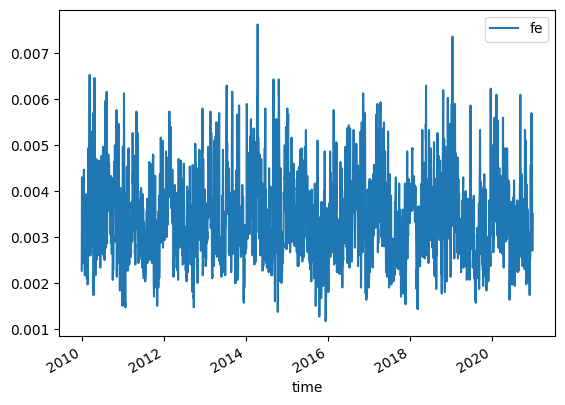

In [ ]:
#reduced marine info (but for correct timeline)
cop_ds3 =fetch_copernicus_data('data/copernicus/cmems_mod_ibi_bgc_my_0.083deg-3D_P1D-m_1683666099015.nc')
print(f"min time: {cop_ds3.time.min()} and max time: {cop_ds3.time.max()}")
cop_ds3.plot(x='time',y='fe')
data_summary(cop_ds3)

<u>Cleaning Copernicus Data</u>

The files were found to be clean and consistent, with only steps being:

- rename columns
- convert to datetime
- Join the three sources together

Please see the function [here](#get_copernicus_data) for more information

In [ ]:
df_cop = get_copernicus_data('data/copernicus')
#tail as most of the data is for later dates
df_cop.tail()

date         so          o2       chl       no3       po4  \
5474  2020-12-27  35.488956  258.000000  0.523333  6.099996  0.496667   
5475  2020-12-28  35.589664  254.000000  0.536667  5.233337  0.420000   
5476  2020-12-29  35.511337  251.666672  0.546667  4.999990  0.396667   
5477  2020-12-30  35.467087  251.666672  0.596667  5.166656  0.410000   
5478  2020-12-31  35.458439  252.333328  0.633333  5.166667  0.410000   

          phyc        si        ph       nh4       nppv    dissic        fe  
5474  2.166656  2.800000  8.065866  0.533333  21.000000  2.186667  0.002800  
5475  2.033335  2.733333  8.062000  0.533333  16.666666  2.186667  0.002700  
5476  1.933329  2.800000  8.052533  0.500000  15.333333  2.190000  0.003033  
5477  2.199992  2.966666  8.049466  0.500000  20.000000  2.203334  0.003500  
5478  2.399994  3.033334  8.053600  0.466667  19.000000  2.203334  0.003500

#### WAQI air quality index
We also wanted to get the air quality index, which we got from WAQI and contained data for Lisbon. The location of this data can be found [here](https://waqi.info/#/c/8.407/9.026/2.2z). The function created to load this can then be found [here](#fetch_AQI_data)

In [ ]:
aqi_ds1 = fetch_AQI_data('data/AQI/entrecampos,-lisboa, portugal-air-quality.csv')
aqi_ds1.head()

date pm25 pm10   o3  no2 so2
0  2023/5/2   19   17   22   25   3
1  2023/5/3   33   15   22   22   3
2  2023/5/4   16   20   29   15   3
3  2023/5/5   18   22   31   15   3
4  2023/5/6   19   12   18   13   3

In [ ]:
aqi_ds2 = fetch_AQI_data('data/AQI/mem-martins, sintra, portugal-air-quality.csv')
aqi_ds2.head()

date pm25 pm10   o3  no2 so2
0  2023/5/2   33   15   47   11   1
1  2023/5/3   29   14   35    5   1
2  2023/5/4   21   20   36    3   1
3  2023/5/5   31   19   40    4   1
4  2023/5/6   45   15   28    3   1

In [ ]:
aqi_ds3 = fetch_AQI_data('data/AQI/olivais,-lisboa, portugal-air-quality.csv')
aqi_ds3.head()

date pm25 pm10   o3  no2 so2
0  2023/5/2   38   15   43    7   1
1  2023/5/3   39   12   36    7   1
2  2023/5/4   20   19   35    7   1
3  2023/5/5   24   21   37    9   1
4  2023/5/6   31   14   25   10   1

<u>Cleaning AQI data</u>

The steps taken to clean this data were:

- convert all variable columns to floats
- convert date column to datetime
- replace white space fields with nan
- Join sources together

Please see the function and it's dependencies [here](#clean_AQI_data) for more information

In [ ]:
df_aqi = get_AQI_data('data/AQI')
df_aqi.head()

date  pm25       pm10         o3        no2  so2
0  2014-01-31   NaN  12.000000  13.000000  20.000000  3.0
1  2014-02-01  22.0  16.000000  19.666667  14.666667  3.0
2  2014-02-02  30.0  17.666667  26.000000  11.000000  3.0
3  2014-02-03  38.0  17.000000  27.666667  11.333333  4.0
4  2014-02-04  44.0  15.000000  30.000000   8.000000  2.0

#### Ocean Health Index
Finally, we used the Ocean Health Index which represents the ecological, social, and economic benefits that people expect from healthy oceans. This data can be accessed [here](https://oceanhealthindex.org/global-scores/data-download/). The function used to load this can be found [here](#get_ohi_data) and we filtered on the region 183 which is for Lisbon, however this function is generalised to be able to be used for other regions.

The reson behind using this rource was to get a national or global indication of general marine health. While this may not be suitable for a feature for the model, it could prove very useful in understanding how AMPA's biodiversity compares to the whole of Portugals.

For the purpose of data prep, feature engineering and adding onto the notebook, the data will be cleaned and filtered according to the criteria below:
*   Time range = 2012-2022
*   Goals = Biodiversity, Habitat (subgoal), Species condition (subgoal) 
*   Dimension = status, future

In [ ]:
#183 is region for portugal
ohi_df = get_ohi_data('data/OHI/scores.csv',"183")

<ipython-input-21-e24b5c9668a6>:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_df = filtered_df[df_region["dimension"].isin(dimension_list)]


In [ ]:
ohi_df.head()

metric  year  biodiversity_future  biodiversity_status  habitat_future  \
0       2012                75.89                75.57           75.76   
1       2013                74.53                74.24           73.53   
2       2014                74.30                74.00           73.53   
3       2015                73.82                73.53           73.06   
4       2016                70.36                73.36           66.62   

metric  habitat_status  species condition_future  species condition_status  
0                73.37                     76.02                     77.76  
1                71.21                     75.54                     77.27  
2                71.21                     75.06                     76.79  
3                70.76                     74.58                     76.30  
4                70.90                     74.10                     75.81

<u>Cleaning OHI data</u>

The steps taken to clean OHI data were:

- Renaming columns
- Reformatting & pivoting goals and dimensions so that they can operate as features
- Convert date column to datetime
- Filtering on region

Please see the function and it's dependencies [here](#get_ohi_data) for more information

### Label Engineering

Our goal for this project was to analyse and model biodiversity. invasive species abundance and endangered species abundance. The later two could be easily extracted from the data provided on the AMPA  region. However, the biodiversity label was not provided and had to be engineered.

The motivation is to represent the biodiversity of the area by taking into account both the number of observed species (a unique count) and the abundance of each species.

The metric used is the [Shannon Diverity Index](https://www.statology.org/shannon-diversity-index/#:~:text=The%20Shannon%20Diversity%20Index%20\(sometimes,i%20*%20ln\(pi\)). This measures the diversity of species in a community. It's use is referenced in the AMPA paper as well.

To allow for both %coverage and abundance counts to be used in the Shannon Index Calculations, the %coverage needs to be represented by a count. This is done according to this [paper on species diversity](https://www.researchgate.net/publication/262458621_Human_Disturbance_in_a_Tropical_Rocky_Shore_Reduces_Species_Diversity). This method was also referenced in the AMPA paper.

As the biodiversity label required counts of all species, the label prep method had to produce a label grouped by datetime/zone/supra_medium and one grouped by date. The former is required for EDA and the later for time series modelling.

Details of the function used to engineer the label can be found [here](#calculate_biodiversity_label). In short, the steps taken are: The the three labels were then joined together to form a 'target table' which was then used for the rest of the project. This can be found [here](#join_labels).



In [ ]:
df_labels = create_target_table(ampa_df)
df_labels.head()

<ipython-input-8-6c7848826609>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sessile_to_count.loc[:, "invasive"] = (


dt zone supratidal_or_middle_intertidal  \
0 2011-11-28 10:10:00    D                          medium   
1 2011-11-28 10:25:00    D                          medium   
2 2011-11-28 10:40:00    D                          medium   
3 2011-11-28 11:00:00    E                          medium   
4 2011-11-28 11:15:00    E                          medium   

   total_non_invasive_sessile  total_invasive_sessile  \
0                      100.00                     0.0   
1                       99.50                     0.0   
2                       66.45                     0.0   
3                       75.10                     0.0   
4                       67.20                     0.0   

   total_endangered_mobile  total_not_endangered_mobile  \
0                      0.0                          0.0   
1                      0.0                          0.0   
2                      0.0                          0.0   
3                      0.0                          0.0   
4                      0.0                          0.0   

   total_pot_endangered_mobile  shannon_index_dt_z_sm  \
0                          4.0               0.812420   
1                          2.0               0.907064   
2                          1.0               1.324026   
3                          2.0               0.817665   
4                          0.0               0.418482   

   shannon_equitability_index_dt_z_sm        date  shannon_index  \
0                            0.586037  2011-11-28       1.560795   
1                            0.412823  2011-11-28       1.560795   
2                            0.602590  2011-11-28       1.560795   
3                            0.508044  2011-11-28       1.560795   
4                            0.260018  2011-11-28       1.560795   

   shannon_equitability_index  
0                    0.550892  
1                    0.550892  
2                    0.550892  
3                    0.550892  
4                    0.550892

### Joining the data together:

This was gone by combining all the above steps called create_feature_table. This can be found [here](#create_target_table). This function takes in the raw data and returns a dataframe designed for modelling. Of course these steps were created with the charateristics of the AMPA data in mind, so it may not be suitable for other projects. However the additional features functions could definitely be used for other projects (by changing location and time parameters)

The steps in the pipeline are:

- Load and clean the base species data ([get_ampa_data()](#get_ampa_data))
- Create the biodiversity label, total invasive and total endangered labels from this table ([create_target_table()](#create_target_table))
- Add time features for modelling and EDA ([add_time_features()](#add_time_features))
- Extract other features ([add_ampa_features()](#add_ampa_features))
- Add weather data from meteo ([get_weather_data()](#get_weather_data))
- Add climate anomaly data from UEA ([get_uea_data()](#get_uea_data))
- Add geochemical data from Copernicus ([get_copernicus_data()](#get_copernicus_data))
- Add air quality data from WAQI ([get_AQI_data()](#get_AQI_data))
- Add ocean health index data ([get_ohi_data()](#get_ohi_data))

**Note**, the joins were done at year/month or date level depending on the source. As the samples were only taken an approximately twice-monthly basis, the ampa data was left joined onto the other data sources. This was done to avoid loosing information on the features between samples



In [ ]:
#create a feature table
df=create_feature_table()
df.head()

<ipython-input-13-6c7848826609>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sessile_to_count.loc[:, "invasive"] = (
<ipython-input-26-e24b5c9668a6>:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_df = filtered_df[df_region["dimension"].isin(dimension_list)]


temperature_2m_max temperature_2m_min temperature_2m_mean  \
0               15.6               13.5                14.2   
1               14.0               10.9                12.6   
2               15.0               11.2                12.8   
3               16.0               13.3                14.7   
4               16.5               14.9                15.6   

  apparent_temperature_max precipitation_sum precipitation_hours        date  \
0                     14.1               0.0                 0.0  2011-01-01   
1                     14.1               1.3                 2.0  2011-01-02   
2                     14.7               0.3                 2.0  2011-01-03   
3                     14.2               0.5                 2.0  2011-01-04   
4                     14.8               7.4                17.0  2011-01-05   

          so          o2       chl  ...  tide_max  tide_min  tide_mean  \
0  35.503708  257.666656  0.646667  ...       NaN       NaN        NaN   
1  35.191910  263.000000  0.720000  ...       NaN       NaN        NaN   
2  34.896900  262.000000  0.756667  ...       NaN       NaN        NaN   
3  34.983875  260.000000  0.733333  ...       NaN       NaN        NaN   
4  35.259052  256.333344  0.636667  ...       NaN       NaN        NaN   

   water_temp_max  biodiversity_future  biodiversity_status  habitat_future  \
0             NaN                  NaN                  NaN             NaN   
1             NaN                  NaN                  NaN             NaN   
2             NaN                  NaN                  NaN             NaN   
3             NaN                  NaN                  NaN             NaN   
4             NaN                  NaN                  NaN             NaN   

   habitat_status  species condition_future  species condition_status  
0             NaN                       NaN                       NaN  
1             NaN                       NaN                       NaN  
2             NaN                       NaN                       NaN  
3             NaN                       NaN                       NaN  
4             NaN                       NaN                       NaN  

[5 rows x 55 columns]

In [ ]:
#The final columns
df.columns

Index(['temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean',
       'apparent_temperature_max', 'precipitation_sum', 'precipitation_hours',
       'date', 'so', 'o2', 'chl', 'no3', 'po4', 'phyc', 'si', 'ph', 'nh4',
       'nppv', 'dissic', 'fe', 'pm25', 'pm10', 'o3', 'no2', 'so2',
       'sea_surface_temp_anomaly', 'year_month',
       'sea_air_combined_temp_anomaly', 'land_air_temp_anomaly', 'dt', 'zone',
       'supratidal_or_middle_intertidal', 'total_non_invasive_sessile',
       'total_invasive_sessile', 'total_endangered_mobile',
       'total_not_endangered_mobile', 'total_pot_endangered_mobile',
       'shannon_index_dt_z_sm', 'shannon_equitability_index_dt_z_sm',
       'shannon_index', 'shannon_equitability_index', 'year', 'weekofyear_sin',
       'weekofyear_cos', 'month_sin', 'month_cos', 'tide_max', 'tide_min',
       'tide_mean', 'water_temp_max', 'biodiversity_future',
       'biodiversity_status', 'habitat_future', 'habitat_status',
       'species conditio

### EDA - Finding Insights:

1. How has the number of endangered species changed over time?

<ipython-input-65-f2087de92acc>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2=df2.groupby(by = ['date','zone','supratidal_or_middle_intertidal']).mean().reset_index()


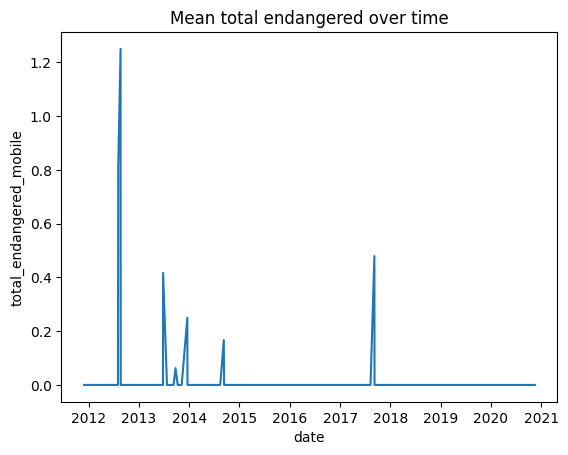

In [ ]:
#Group by zone, data and tidal:
df2=df.drop(labels=['dt','year_month'], axis=1)
df2=df2.groupby(by = ['date','zone','supratidal_or_middle_intertidal']).mean().reset_index()

## how does this look throughout records
sns.lineplot(data=df2, x='date', y='total_endangered_mobile', errorbar=None)
plt.title("Mean total endangered over time")
plt.show()

From the above, we can see that endangered species are not encountered often and have a range in number

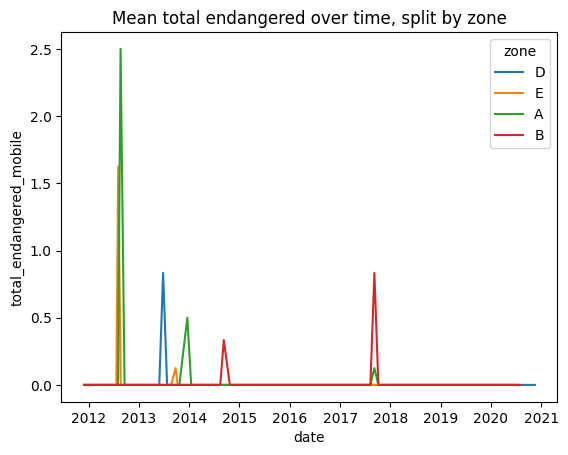

In [ ]:
#Can then look at this by the zone
sns.lineplot(data=df2, x='date', y='total_endangered_mobile', hue='zone', errorbar=None)
plt.title("Mean total endangered over time, split by zone")
plt.show()

The zones in which we observe endangered species are also spread.

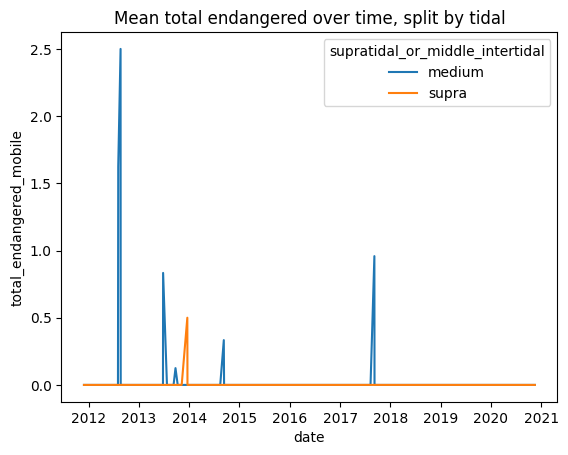

In [ ]:
#Can then look at this by tidal zone:
sns.lineplot(data=df2, x='date', y='total_endangered_mobile', hue='supratidal_or_middle_intertidal', errorbar=None)
plt.title("Mean total endangered over time, split by tidal")
plt.show()

This shows that the endangered species are found more often in the intertidal region opposed to the supra region.

2. How has potentially endangered changed over time?

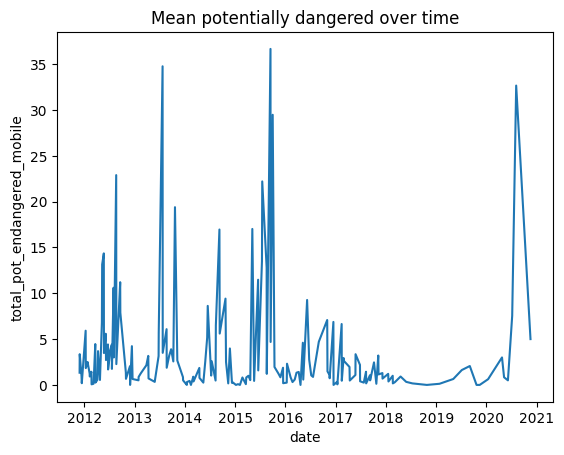

In [ ]:
sns.lineplot(data=df2, x='date', y='total_pot_endangered_mobile', errorbar=None)
plt.title("Mean potentially dangered over time")
plt.show()

There is a rough seasonal spike earlier in the year with long periods of low records and a high spike more recently

3. How has the number of invasive species changed over time?

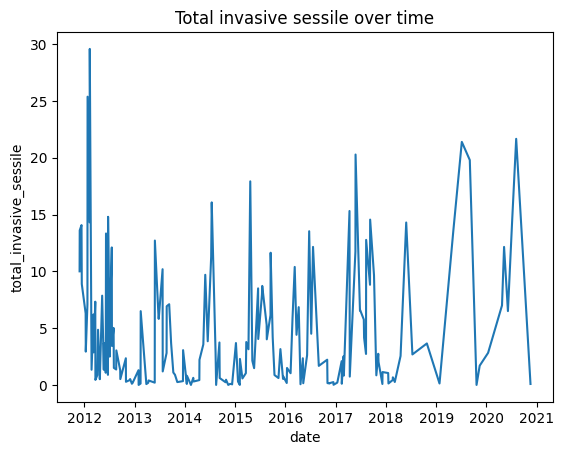

In [ ]:
sns.lineplot(data=df2, x='date', y='total_invasive_sessile', errorbar=None)
plt.title("Total invasive sessile over time")
plt.show()

Unlike for mobil species, sessile species are reported during 2019/2020

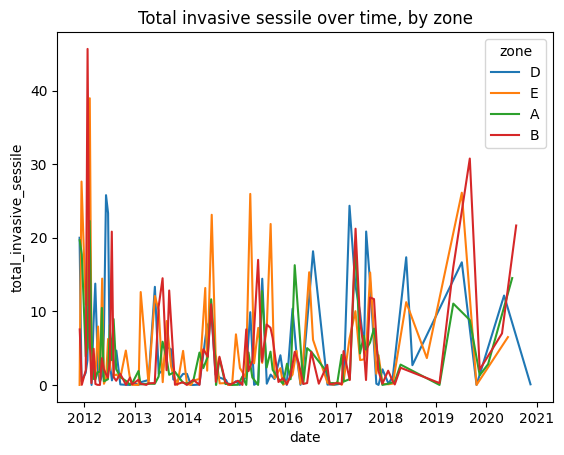

In [ ]:
## Plotting by zone too
sns.lineplot(data=df2, x='date', y='total_invasive_sessile', hue= 'zone',errorbar=None)
plt.title("Total invasive sessile over time, by zone")
plt.show()

Invasive species are recorded in all zones across the recording period

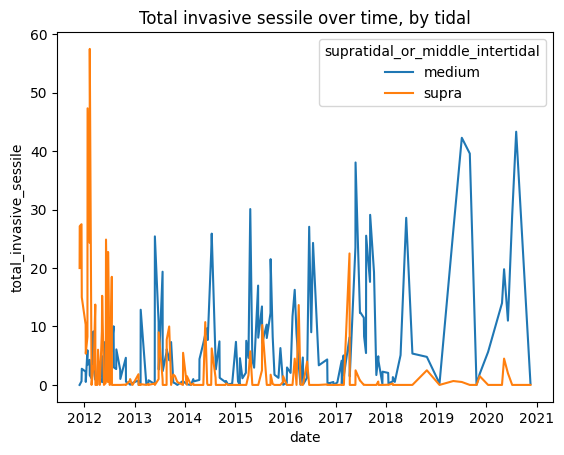

In [ ]:
## Plotting by tidal region
sns.lineplot(data=df2, x='date', y='total_invasive_sessile',  hue='supratidal_or_middle_intertidal',errorbar=None)
plt.title("Total invasive sessile over time, by tidal")
plt.show()

Number of invasive sessile species in supra tidal region drop off after 2017, the medium tidal area increase through record history

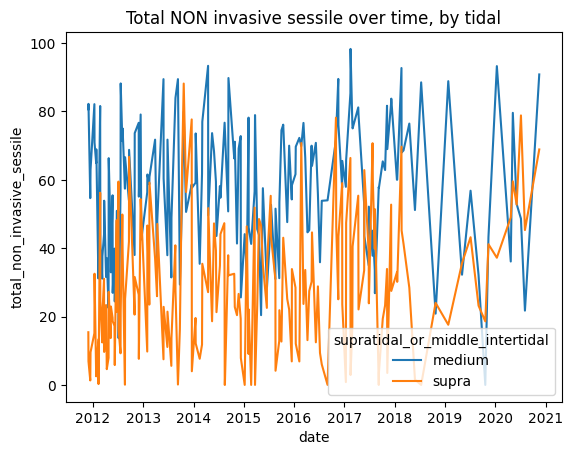

In [ ]:
## Looking at non invasive as a comparison:
sns.lineplot(data=df2, x='date', y='total_non_invasive_sessile',  hue='supratidal_or_middle_intertidal',errorbar=None)
plt.title("Total NON invasive sessile over time, by tidal")
plt.show()

The number of non-invasive sessile species in supra region dropped in 2019 and has been recovering since, perhaps due to the reduction on invasive in the supra region. There could be a lag from them reducing in 2017.

This suggests that invasive and non-invasive species do interact with eachother, potentially as a predator/prey relationship. So to increase diversity of one, you may want to decrease diversity of the other so non-invasive can thrive without invasive. However, as typical in predator prey relationships, if the predators become too common, the prey will decline and there will be less for predators to feed on so they will than reduce. This reduction leads to prey becoming more common again, and then this cycle continues. This relationship may be what is what is causing the declines in different times of invasive and non-invasive.

4. What factors are most correlated with our target variables?

<ipython-input-75-9810c48817ab>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap ((df.corr()), xticklabels=df.corr().columns, yticklabels=df.corr().columns, annot=False)


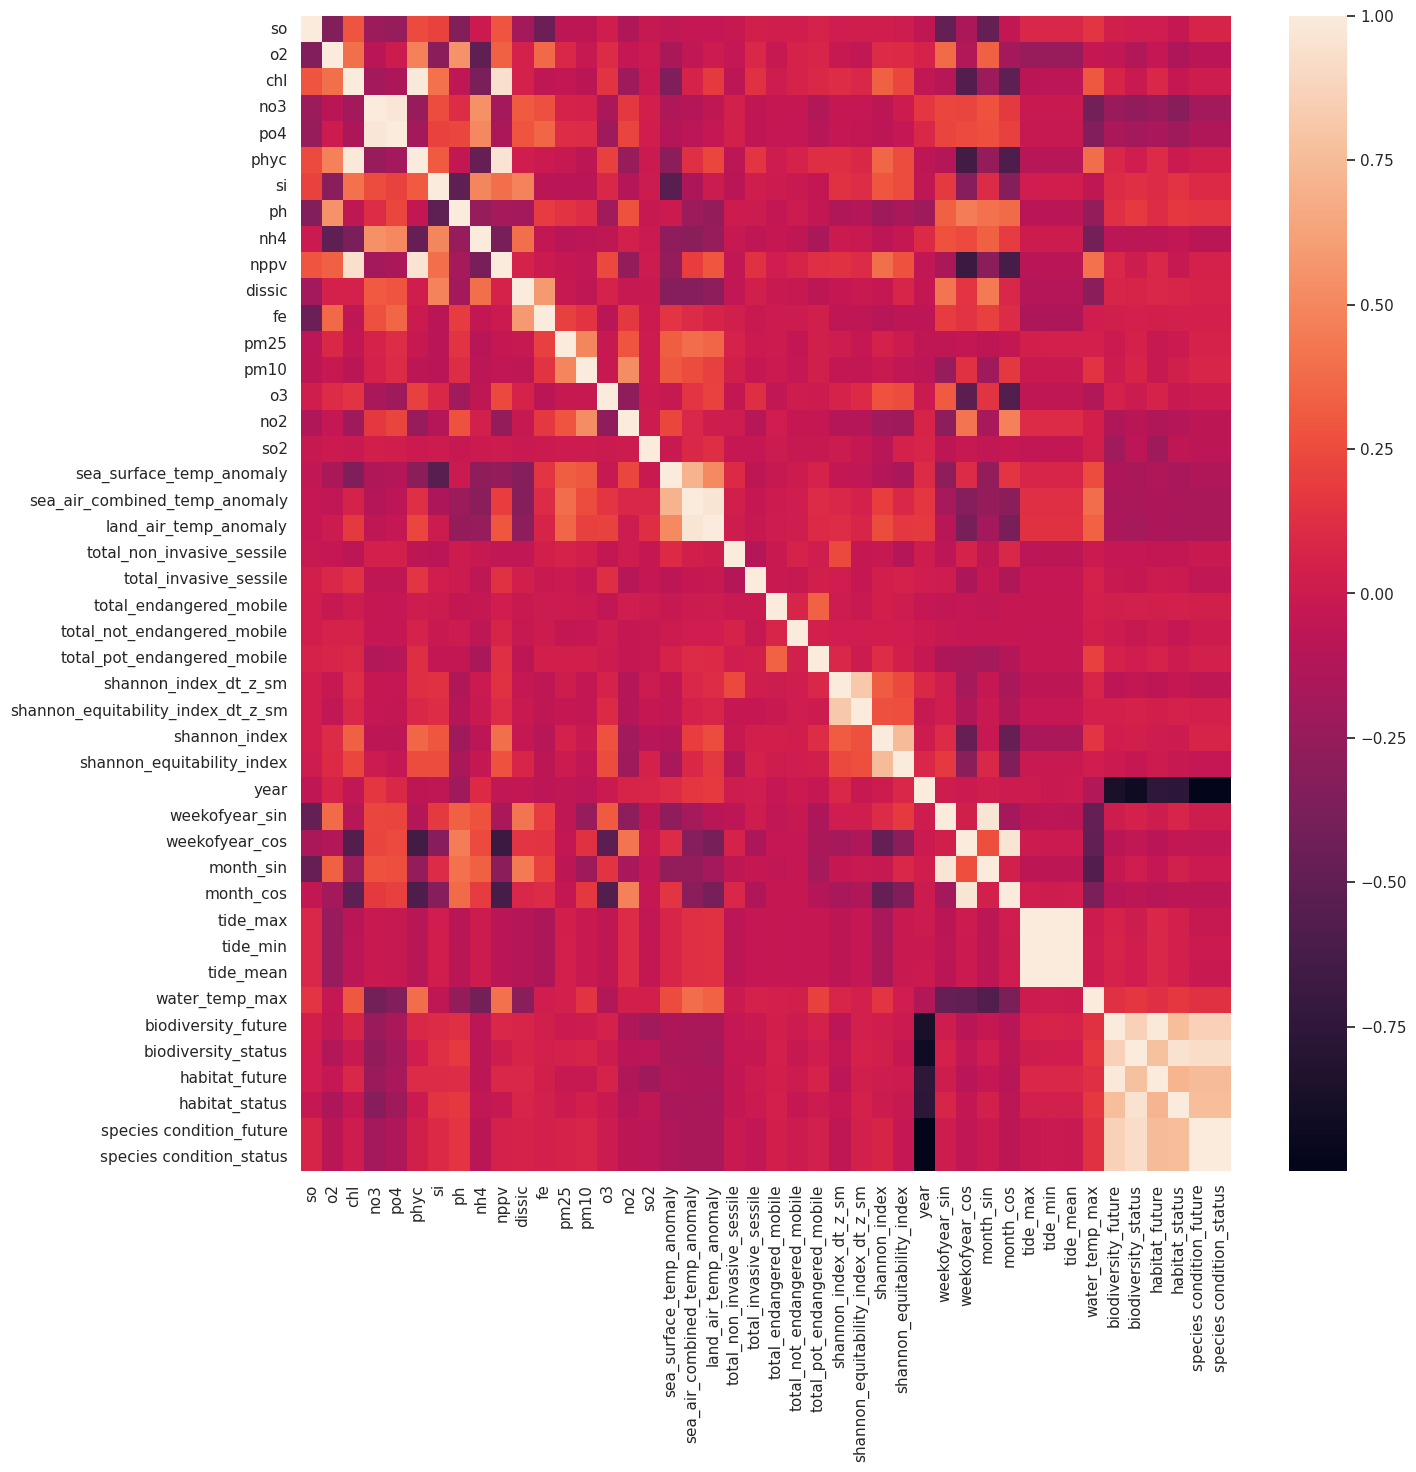

In [ ]:
#define figure size
sns.set(rc={"figure.figsize":(15, 15)}) #width=15, height=15
sns.heatmap ((df.corr()), xticklabels=df.corr().columns, yticklabels=df.corr().columns, annot=False)

plt.show()

Although this is not the prettiest plot due to the number of variables, you can see straight away, as expected, the OHI variables (both future and status) are highly positively correlated with eachother. These are then all negatively correlated with the year. The tide levels are of course positively correlated with eachother.  The different levels of no3 etc are then also positively correlated with eachother. Then variables like nppv are correlated with the month of year (seasonality), you can see this in the plot below. More analysis and EDA on seasonality will be showing in the next [modelling](#modelling_section) section

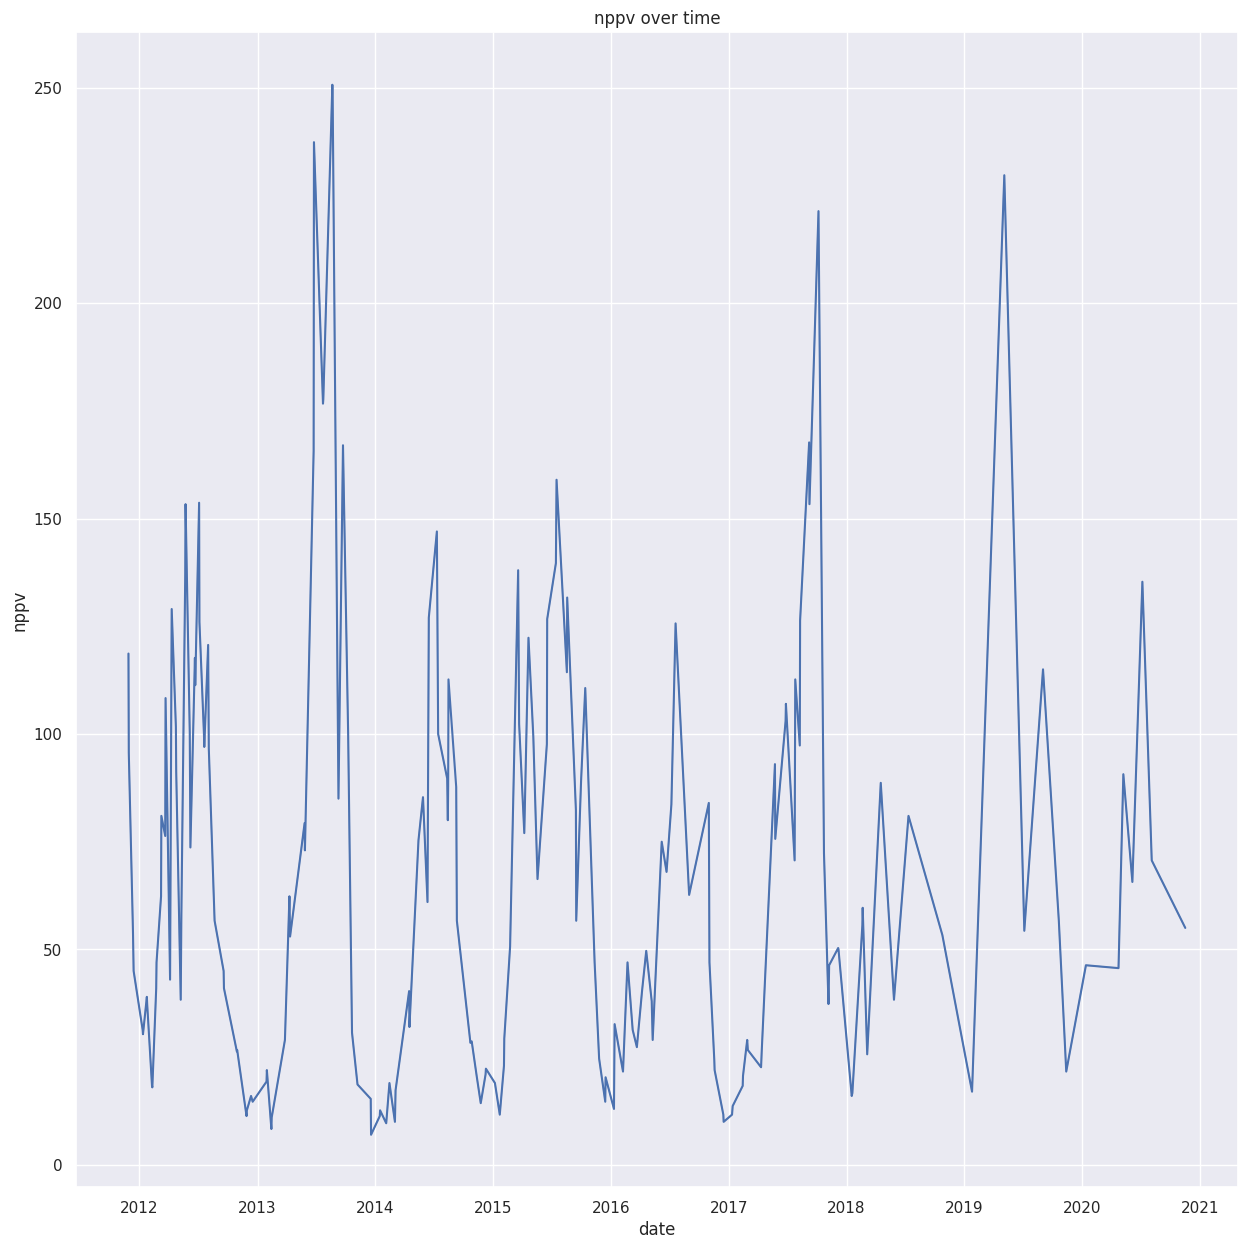

In [ ]:
sns.lineplot(data=df2, x='date', y='nppv')
plt.title("nppv over time")
plt.show()

### Modelling <a name ='modelling_section'></a>

We will document out modelling approach below. As time series models were used, this will include the steps taken to create the time series models (including the analysis)

The analysis will cover the biodiversity label (shannon index) as that is our primary target. However, we will also look at the invasive and endangered species labels as well (using the class derived in the following steps).

Time series modelling techniques were used, because (as will be explained) there are time related patterns in the biodiversity metric that can be captured by these techniques. Moreover, algorithms such as SARIMAX are very interpretable, which is also valuable in giving us understanding of how external features impact the model and it's predictions.

In [ ]:
# Define Features
FEATURE_COLUMNS = [
    "tide_max",
    "tide_min",
    "tide_mean",
    "water_temp_max",
    "sea_surface_temp_anomaly",
    "sea_air_combined_temp_anomaly",
    "land_air_temp_anomaly",
    "temperature_2m_max",
    "temperature_2m_min",
    "temperature_2m_mean",
    "apparent_temperature_max",
    "precipitation_sum",
    "precipitation_hours",
    "so",
    "o2",
    "chl",
    "no3",
    "po4",
    "phyc",
    "si",
    "ph",
    "nh4",
    "nppv",
    "dissic",
    "fe",
    "pm25",
    "pm10",
    "o3",
    "no2",
    "so2",
    "biodiversity_future",
    "biodiversity_status",
    "habitat_future",
    "habitat_status",
    "species condition_future",
    "species condition_status",
]

In [ ]:
# define features and labels
label = "shannon_index"
base_features = FEATURE_COLUMNS
date_features = ["date"]

#### Aggregate to date level (one row per date)

This is a requirement for time series modelling. The steps taken to do this are defined in the function [here](#aggregate_by_date)

In [ ]:
df_date_level = aggregate_by_date(df, base_features, label, date_features)
df_date_level.head()

tide_max  tide_min  tide_mean  water_temp_max  \
date                                                        
2011-01-01       NaN       NaN        NaN             NaN   
2011-01-02       NaN       NaN        NaN             NaN   
2011-01-03       NaN       NaN        NaN             NaN   
2011-01-04       NaN       NaN        NaN             NaN   
2011-01-05       NaN       NaN        NaN             NaN   

            sea_surface_temp_anomaly  sea_air_combined_temp_anomaly  \
date                                                                  
2011-01-01                       NaN                            NaN   
2011-01-02                       NaN                            NaN   
2011-01-03                       NaN                            NaN   
2011-01-04                       NaN                            NaN   
2011-01-05                       NaN                            NaN   

            land_air_temp_anomaly temperature_2m_max temperature_2m_min  \
date                                                                      
2011-01-01                    NaN               15.6               13.5   
2011-01-02                    NaN               14.0               10.9   
2011-01-03                    NaN               15.0               11.2   
2011-01-04                    NaN               16.0               13.3   
2011-01-05                    NaN               16.5               14.9   

           temperature_2m_mean  ...  o3 no2 so2  biodiversity_future  \
date                            ...                                    
2011-01-01                14.2  ... NaN NaN NaN                  NaN   
2011-01-02                12.6  ... NaN NaN NaN                  NaN   
2011-01-03                12.8  ... NaN NaN NaN                  NaN   
2011-01-04                14.7  ... NaN NaN NaN                  NaN   
2011-01-05                15.6  ... NaN NaN NaN                  NaN   

            biodiversity_status  habitat_future  habitat_status  \
date                                                              
2011-01-01                  NaN             NaN             NaN   
2011-01-02                  NaN             NaN             NaN   
2011-01-03                  NaN             NaN             NaN   
2011-01-04                  NaN             NaN             NaN   
2011-01-05                  NaN             NaN             NaN   

            species condition_future  species condition_status  shannon_index  
date                                                                           
2011-01-01                       NaN                       NaN            NaN  
2011-01-02                       NaN                       NaN            NaN  
2011-01-03                       NaN                       NaN            NaN  
2011-01-04                       NaN                       NaN            NaN  
2011-01-05                       NaN                       NaN            NaN  

[5 rows x 37 columns]

#### Convert Data to Regular intervals

As the sampling frequency is irregular, we need to convert the data to regular intervals for time series analysis. We will have to resample the data then interpolate the gaps. But first we need to understand the sampling frequency.

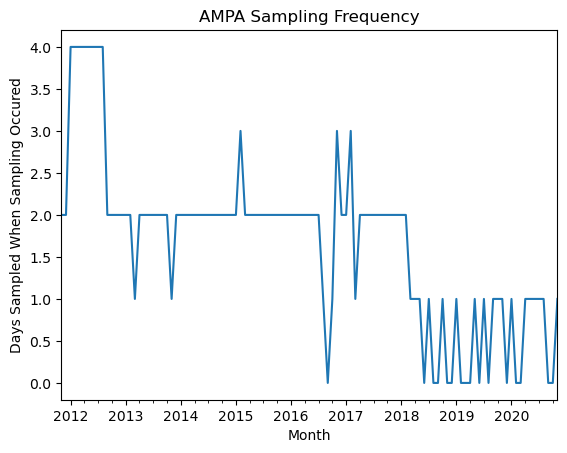

In [ ]:
# Group the DataFrame by month and count the number of rows in each group
label_not_null = df_date_level[df_date_level[label].notnull()][label]
label_not_null.index = pd.to_datetime(label_not_null.index)
label_not_null.groupby(pd.Grouper(freq="M")).size().plot()

plt.xlabel("Month")
plt.ylabel("Days Sampled When Sampling Occured")
plt.title(f"AMPA Sampling Frequency")
plt.show()

<div style="background-color: #cce0ff; padding: 10px; border-radius: 5px; color: #004080;">
    <strong>Note:</strong> The sampling (days where recordings are available) frequency seems fairly consistent until 2018 where it drops from bi-weekly to bi-monthly. This means that we will have to be careful when we are analysing the label from 2018 onwards, as the lower frequency could make overall trends more susseptable to noise. This also indicates the optimum sampling frequency for the model is bi-weekly (every 2 weeks)
</div>

Using the function defined in [this section](#resample_features), we can inestigate the optimum sampling frequency for the model.

In [ ]:
#make a copy of the df
df_base = df_date_level.copy()

In [ ]:
# sample to weekly
df_base_w = resample_features(
    df_base, base_features, label, freq="W", show_info_loss=True
)

182 non null shannon_index labels in original, 125 non null shannon_index labels in resampled_data


In [ ]:
# sample to 2 weekly
df_base_2w = resample_features(
    df_base, base_features, label, freq="2W", show_info_loss=True
)

182 non null shannon_index labels in original, 123 non null shannon_index labels in resampled_data


In [ ]:
# sample to to Monthly
df_base_m = resample_features(
    df_base, base_features, label, freq="M", show_info_loss=True
)

182 non null shannon_index labels in original, 93 non null shannon_index labels in resampled_data


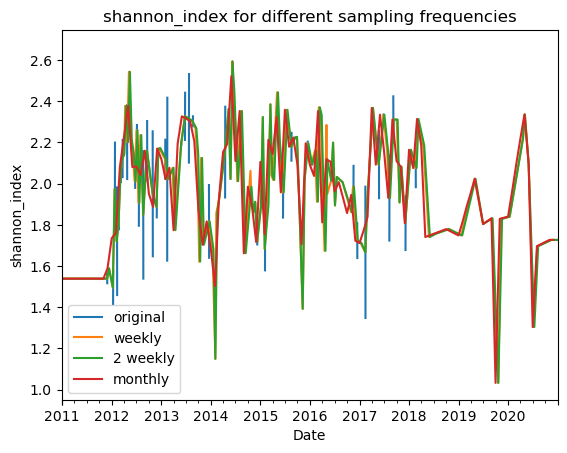

In [ ]:
# plot shannon label for each sampling frequency
df_base[label].plot(label="original")
df_base_w[label].plot(label="weekly")
df_base_2w[label].plot(label="2 weekly")
df_base_m[label].plot(label="monthly")

plt.legend()
plt.xlabel("Date")
plt.ylabel(label)
plt.title(f"{label} for different sampling frequencies")

plt.show()

<div style="background-color: #cce0ff; padding: 10px; border-radius: 5px; color: #004080;">
    <strong>Note:</strong> Weekly and 2-weekly are approximately equivalent. Both loose info, especially in the first year, but seem a good approximation. 2 weekly is selected as the longer time steps will smooth out prediction with minimal info loss. Month also appears equivalent, perhaps due to sample dates often being close together. <b>Month will be selected</b> as the longer time steps will smooth out prediction with minimal info loss. Also, it is more intuitive to use months as a time step, especially when it comes to equivalent the data.
</div>

#### Add lagged features

A useful feature in time series modelling can be to added lagged features. This means shifting a features so that the current label is in line with a feature n time steps ago. In a time series, this means that a feature value to day could help predicted the label in 3 months time (without having to know the future value of the feature). This is very valuable.

In [ ]:
# adding lagged features up to three months
df_base_m_lag = add_lagged_features(df_base_m, base_features, [1, 2, 3])
df_base_m_lag.head()

tide_min  temperature_2m_min  tide_max  water_temp_max  \
date                                                                 
2011-01-31       0.6                 5.4       0.8            16.0   
2011-02-28       0.6                 6.7       0.8            16.0   
2011-03-31       0.6                 7.8       0.8            16.0   
2011-04-30       0.6                12.9       0.8            16.0   
2011-05-31       0.6                13.2       0.8            16.0   

            temperature_2m_max  apparent_temperature_max  tide_mean  \
date                                                                  
2011-01-31                16.8                      15.9        0.7   
2011-02-28                18.0                      18.1        0.7   
2011-03-31                21.0                      23.8        0.7   
2011-04-30                25.1                      26.4        0.7   
2011-05-31                27.5                      30.3        0.7   

            sea_surface_temp_anomaly  sea_air_combined_temp_anomaly  \
date                                                                  
2011-01-31                  0.744416                       0.715628   
2011-02-28                  0.744416                       0.715628   
2011-03-31                  0.744416                       0.715628   
2011-04-30                  0.744416                       0.715628   
2011-05-31                  0.744416                       0.715628   

            land_air_temp_anomaly  ...  habitat_future_lag3  \
date                               ...                        
2011-01-31               0.547294  ...                  NaN   
2011-02-28               0.547294  ...                  NaN   
2011-03-31               0.547294  ...                  NaN   
2011-04-30               0.547294  ...                75.76   
2011-05-31               0.547294  ...                75.76   

            habitat_status_lag1  habitat_status_lag2  habitat_status_lag3  \
date                                                                        
2011-01-31                  NaN                  NaN                  NaN   
2011-02-28                73.37                  NaN                  NaN   
2011-03-31                73.37                73.37                  NaN   
2011-04-30                73.37                73.37                73.37   
2011-05-31                73.37                73.37                73.37   

            species condition_future_lag1  species condition_future_lag2  \
date                                                                       
2011-01-31                            NaN                            NaN   
2011-02-28                          76.02                            NaN   
2011-03-31                          76.02                          76.02   
2011-04-30                          76.02                          76.02   
2011-05-31                          76.02                          76.02   

            species condition_future_lag3  species condition_status_lag1  \
date                                                                       
2011-01-31                            NaN                            NaN   
2011-02-28                            NaN                          77.76   
2011-03-31                            NaN                          77.76   
2011-04-30                          76.02                          77.76   
2011-05-31                          76.02                          77.76   

            species condition_status_lag2  species condition_status_lag3  
date                                                                      
2011-01-31                            NaN                            NaN  
2011-02-28                            NaN                            NaN  
2011-03-31                          77.76                            NaN  
2011-04-30                          77.76                          77.76  
2011-05-31                 

#### Creating a pipeline for the timeseries data

The above steps are combined in [create_time_series_table](#create_time_series_table). This helps make the process repeatable for other labels (invasive and endangered counts) as well as other data sets.

In [ ]:
df_shannon, features = create_time_series_table(
    df,
    features=base_features,
    label="shannon_index",
    date_features=["date"],
    freq="M",
    lag_values=[1, 2, 3],
    return_features=True,
)
df_shannon.head()

tide_min  temperature_2m_min  tide_max  water_temp_max  \
date                                                                 
2011-11-30       0.6                 9.9       0.8            16.0   
2011-12-31       0.9                 8.4       0.9            16.0   
2012-01-31       0.6                 7.5       0.7            17.0   
2012-02-29       0.5                 3.2       0.7            16.0   
2012-03-31       0.4                 8.6       0.8            17.0   

            temperature_2m_max  apparent_temperature_max  tide_mean  \
date                                                                  
2011-11-30                21.5                      18.5      0.700   
2011-12-31                16.9                      16.1      0.900   
2012-01-31                17.1                      16.0      0.650   
2012-02-29                17.4                      15.6      0.600   
2012-03-31                24.0                      23.8      0.625   

            sea_surface_temp_anomaly  sea_air_combined_temp_anomaly  \
date                                                                  
2011-11-30                  0.744416                       0.715628   
2011-12-31                  0.864754                       0.343773   
2012-01-31                  0.536234                       0.298948   
2012-02-29                  0.066095                      -1.023429   
2012-03-31                  0.000949                       0.670299   

            land_air_temp_anomaly  ...  habitat_future_lag3  \
date                               ...                        
2011-11-30               0.547294  ...                75.76   
2011-12-31              -0.237431  ...                75.76   
2012-01-31              -0.036346  ...                75.76   
2012-02-29              -2.235327  ...                75.76   
2012-03-31               0.992107  ...                75.76   

            habitat_status_lag1  habitat_status_lag2  habitat_status_lag3  \
date                                                                        
2011-11-30                73.37                73.37                73.37   
2011-12-31                73.37                73.37                73.37   
2012-01-31                73.37                73.37                73.37   
2012-02-29                73.37                73.37                73.37   
2012-03-31                73.37                73.37                73.37   

            species condition_future_lag1  species condition_future_lag2  \
date                                                                       
2011-11-30                          76.02                          76.02   
2011-12-31                          76.02                          76.02   
2012-01-31                          76.02                          76.02   
2012-02-29                          76.02                          76.02   
2012-03-31                          76.02                          76.02   

            species condition_future_lag3  species condition_status_lag1  \
date                                                                       
2011-11-30                          76.02                          77.76   
2011-12-31                          76.02                          77.76   
2012-01-31                          76.02                          77.76   
2012-02-29                          76.02                          77.76   
2012-03-31                          76.02                          77.76   

            species condition_status_lag2  species condition_status_lag3  
date                                                                      
2011-11-30                          77.76                          77.76  
2011-12-31                          77.76                          77.76  
2012-01-31                          77.76                          77.76  
2012-02-29                          77.76                          77.76  
2012-03-31                 

#### Split Data

The data needs to be split into test and train samples. As this is a time series, we will use a time based split. This means that the test data will be the most recent data and the train data will be the older data. This is done to avoid data leakage. The function used to do this is defined [here](#split_dataset_by_date)

**Note** A decision was made to limit the train/test date range at early 2018. While this does throw away some months, the visulisation above demonstrates how the sampling frequency drastically reduces after 2018 (from twice a month to once every to months). This means that the data points (and trends) after early 2018 are less likely to reflect an overall trend. Moreover, timeseries modells use the last n historic dates to make a prediction, hence would be prioritising this period over the much richer period before 2018.

In [ ]:
# using up to the end of the twice monthly data as the split date
X_train, X_test, y_train, y_test = split_dataset_by_date(
    df_shannon, "shannon_index", features, "2017-01-01", last_date="2018-01-31"
)

#record the size of y_test (for number of forecast steps)
forecast_steps = y_test.shape[0]

#### Performance Evaluation

Before we begin modeliing it is helpful to define some utilities:

- A function to plot the predictions against the actual values -> [plot_forecast](#plot_forecast)
- A function to calculate the RMSE/MAE/MAPE and store the result in a table -> [evaluate_predictions](#evaluate_predictions)

In [ ]:
# define a df to keep track of results
results_df = pd.DataFrame(columns=["Model", "RMSE", "MAE", "MAPE"])

#### Define some simple Benchmarks

Some naive benchmarks were defined for the problem. While the small dataset means test results can be subject to noise (and hence difficult to select a model on OOS performance alone), these benchmarks can offer a good starting point for the model.

The benchmarks defined were:

- [ConstantValueModel](#ConstantValueModel): Predicts the mean or last value of the label for all predictions

- [MonthlyAverageModel](#MonthlyAverageModel): Predicts the historic mean for each month

The performance of each model is shown below:

MAE: 0.19050225937658952
MAPE: 0.0938702766080678
RMSE: 0.2145117918579752


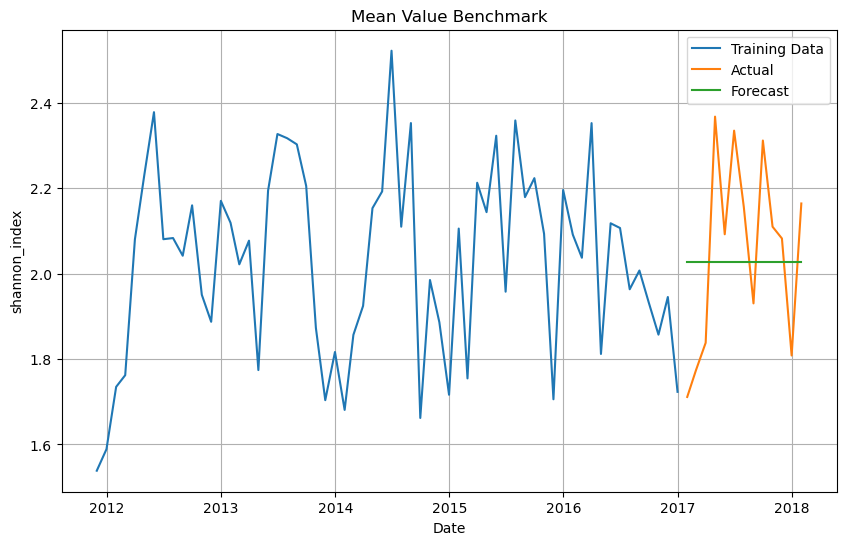

In [ ]:
# predicting the mean value
model = ConstantValueModel(y_train, "mean")
model.fit()
y_pred = model.forecast(y_test.index)
results_df = evaluate_predictions(results_df, y_pred, y_test, "mean value benchmark")
plot_forecast(y_train, y_pred, actual=y_test, title="Mean Value Benchmark")

MAE: 0.33099722935637804
MAPE: 0.15214107345256037
RMSE: 0.39205587378143353


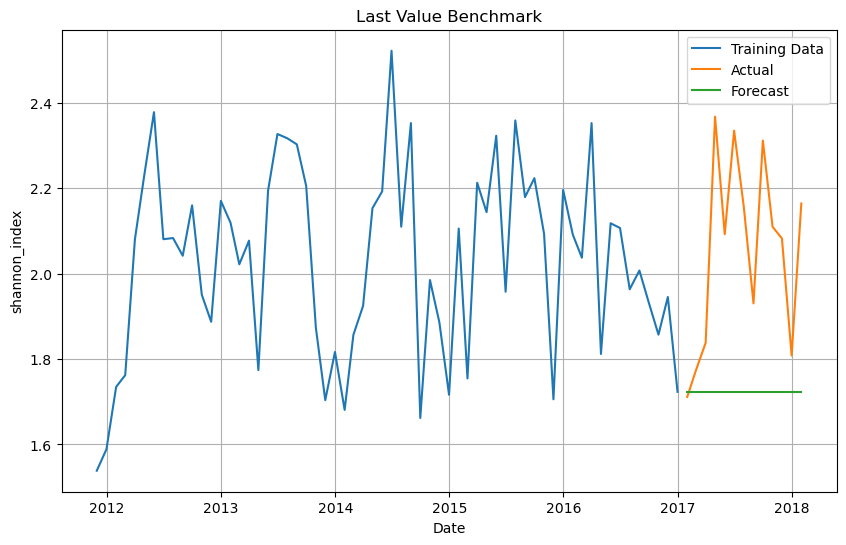

In [ ]:
# predicting the last value
model = ConstantValueModel(y_train, "last")
model.fit()
y_pred = model.forecast(y_test.index)
results_df = evaluate_predictions(results_df, y_pred, y_test, "last value benchmark")
plot_forecast(y_train, y_pred, actual=y_test, title="Last Value Benchmark")

MAE: 0.1954793724039106
MAPE: 0.0954621421577803
RMSE: 0.21798224544301475


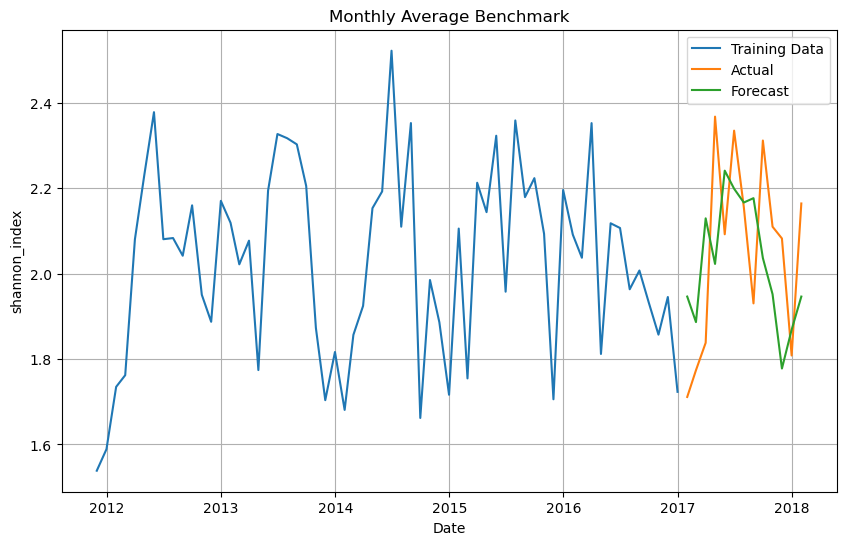

In [ ]:
model = MonthlyAverageModel(y_train)
model.fit()
y_pred = model.forecast(y_test.index)
results_df = evaluate_predictions(
    results_df, y_pred, y_test, "monthly average benchmark"
)
plot_forecast(y_train, y_pred, actual=y_test, title="Monthly Average Benchmark")

#### Time series Analysis

We will use the date level data to carry out time series analysis. We will use the following steps to carry out time series analysis:



##### Seasonality

Plot how the trend varies for each month of the year. This function is found [visualize_monthly_trend](#visualize_monthly_trend)

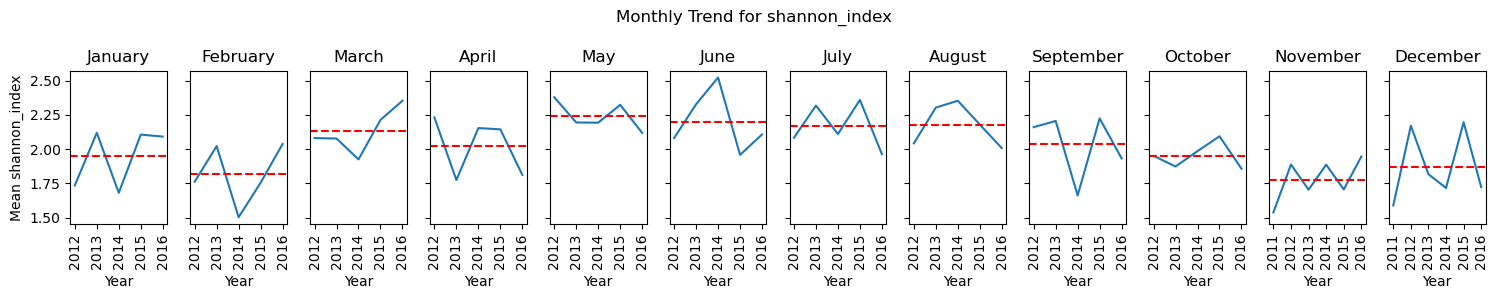

In [ ]:
visualize_monthly_trend(y_train)

<div style="background-color: #cce0ff; padding: 10px; border-radius: 5px; color: #004080;">
    <strong>Note:</strong> There is a clear seasonality in biodiversity (by examining the month on month mean and trend lines). However, there is no clear trend over the years for each month. This is indicates the biodiversity is not changing over the years (stationary).
</div>

We can also use seasonal decomposition to understand the trend and seasonality in the data as well

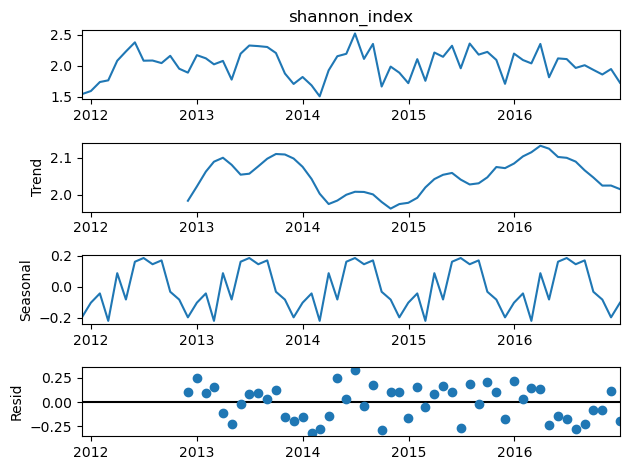

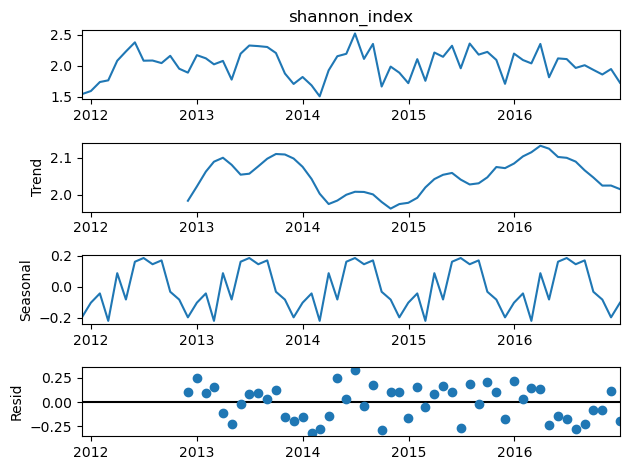

In [ ]:
result = seasonal_decompose(y_train, model="additive", period=12, two_sided=False)
result.plot()

<div style="background-color: #cce0ff; padding: 10px; border-radius: 5px; color: #004080;">
    <strong>Note:</strong> This confirms the slight seasonality and also indicates that that while the trend isn't constant, there is a clear direction of travel.
</div>

##### Stationarity

Test for any trend over time in the data

In [ ]:
# Perform ADF test on y_train
result = adfuller(y_train)

# Extract and print the test statistic and p-value
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -5.506911150032731
p-value: 2.0122608558300124e-06


<div style="background-color: #cce0ff; padding: 10px; border-radius: 5px; color: #004080;">
    <strong>Note:</strong> The low p-value indicates that the data is stationary.
</div>

As the data appears to be seasonal we can also check the seasonal stationarity

In [ ]:
# Perform ADF test on seasonal differences of the time series
seasonal_diff = y_train.diff(12)
seasonal_diff = seasonal_diff.dropna()
result = adfuller(seasonal_diff)

# Extract and print the test statistic and p-value
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -2.5739821724180745
p-value: 0.09849473026811967


<div style="background-color: #cce0ff; padding: 10px; border-radius: 5px; color: #004080;">
    <strong>Note:</strong> The p-value indicates the seasonal data could be non-stationary. This means that there could be a trend in the difference between this month and last month accross the data (i.e Feb 2018 - Feb 2017). This indicates that by removing the seasonal compenent, we could see an underlying trend in the data. However, by looking at the trend in the seasonal decompistion plot above there is no obvious trend (so this is likely to be a small effect). We will difference the seasonal component anyway to be sure.
</div>

##### Autocorrelation and Partial Autocorrelation

These plots indicate if there is any correlation between the current value and the previous values. For example, do the values 4 months apart tend to correlate and does knowing the value now help predicted the value 4 months from now.

/home/mcgibs/miniconda3/envs/wdl/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


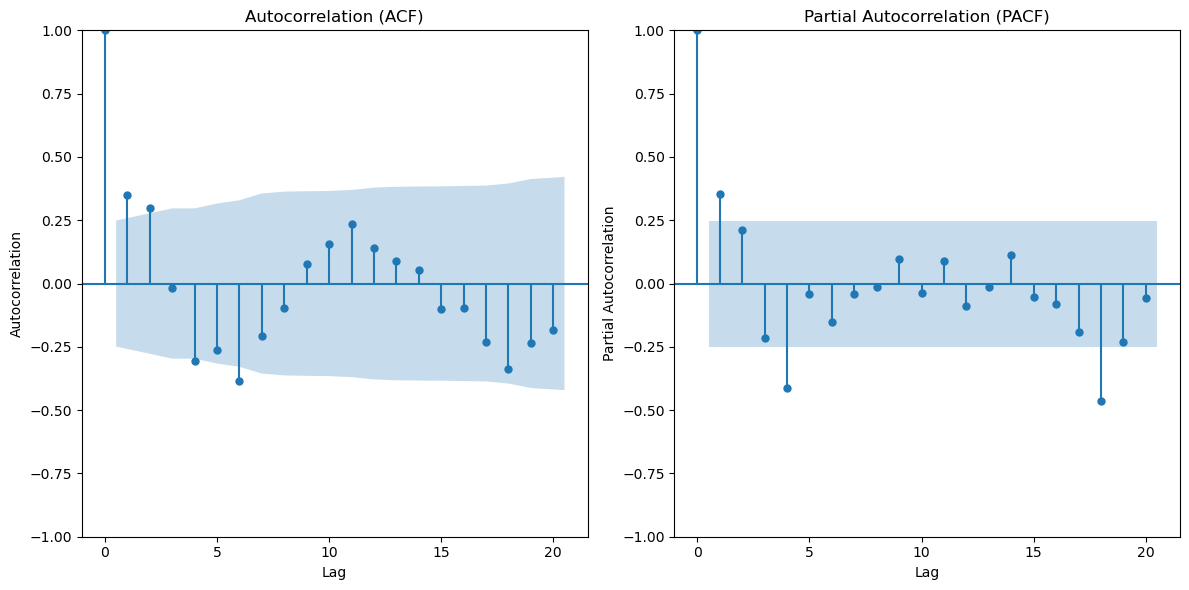

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot ACF
plot_acf(y_train, lags=20, ax=ax1)
ax1.set_xlabel("Lag")
ax1.set_ylabel("Autocorrelation")
ax1.set_title("Autocorrelation (ACF)")

# Plot PACF
plot_pacf(y_train, lags=20, ax=ax2)
ax2.set_xlabel("Lag")
ax2.set_ylabel("Partial Autocorrelation")
ax2.set_title("Partial Autocorrelation (PACF)")

plt.tight_layout()

plt.show()

<blockquote style="background-color: #cce0ff; padding: 10px; border-radius: 5px; color: #004080;">
    <strong>Note:</strong> The ACF plot shows decay in autocorrelation around lag 2, this typically dictates a 2nd order moving average component could be useful in terms of predicting the next term in a sequence (i.e the weighted average of the past 2 terms).<br><br>
 The PACF shows significance at lag 1, this indicates that the 1st order autoregressive component could be useful in terms of predicting the next term in a sequence (i.e scaling of the last term). The 4th term could also be used if we want to add more complexity<br><br>
 The ACF plot doesn't show a clear spike at lag 12, but does increase around that time, this indicates that differencing of the seasonal component may be needed
</blockquote >  

#### Time Series Simple Model

Train some models using the label alone. This will be used both as benchmark and as way to understand possible external impacts on the variable. This will also mean wwe can take into accounts effects such as seasonallity.


##### Manually Create a Model From Analysis

**Note** The ACF/PACF plots for seasonally(12 months) differenced and seasonally first differenced data are in the Appendix.

Based on the time series analysis, we will use a SARIMAX model with the following parameters:

* p = 1 (PACF showed lagged 1 to be significant. Hence 1st order AR)
* d = 0 (it's stationary)
* q = 2 (ACF showed 2 siginifant terms)
* P = 1 (PACF showed lag 1 to be significant for 1st order differenced seasonal data. Hence 1st order AR)
* D = 1 (Potential trend in the seasonal term, hence 1st order differencing)
* Q = 1 (showed lag 1 to be significant for 1st order differenced seasonal data, hence 1st order MA)

In [ ]:
# Train a model based on the analysis above
model_params = {"order": (1, 0, 2), "seasonal_order": (1, 1, 1, 12), "trend": "c"}
sarima_model = SARIMAX(y_train, **model_params)

sarima_model_trained = sarima_model.fit(disp=False)

/home/mcgibs/miniconda3/envs/wdl/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
sarima_model_trained.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                        shannon_index   No. Observations:                   62
Model:             SARIMAX(1, 0, 2)x(1, 1, [1], 12)   Log Likelihood                  10.388
Date:                              Wed, 17 May 2023   AIC                             -6.776
Time:                                      20:59:07   BIC                              6.609
Sample:                                  11-30-2011   HQIC                            -1.679
                                       - 12-31-2016                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0125      0.029      0.430      0.667      -0.044       0.069
ar.L1         -0.1146      0.334     -0.343      0.732      -0.769       0.540
ma.L1          0.2484      0.300      0.828      0.408      -0.340       0.837
ma.L2          0.5207      0.158      3.295      0.001       0.211       0.830
ar.S.L12      -0.3807      0.245     -1.551      0.121      -0.862       0.100
ma.S.L12      -0.9852     18.720     -0.053      0.958     -37.676      35.706
sigma2         0.0222      0.413      0.054      0.957      -0.786       0.831
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.18
Prob(Q):                              0.93   Prob(JB):                         0.55
Heteroskedasticity (H):               1.06   Skew:                            -0.37
Prob(H) (two-sided):                  0.91   Kurtosis:                         2.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

MAE: 0.19408255105034672
MAPE: 0.09597395962430035
RMSE: 0.21643399120903056


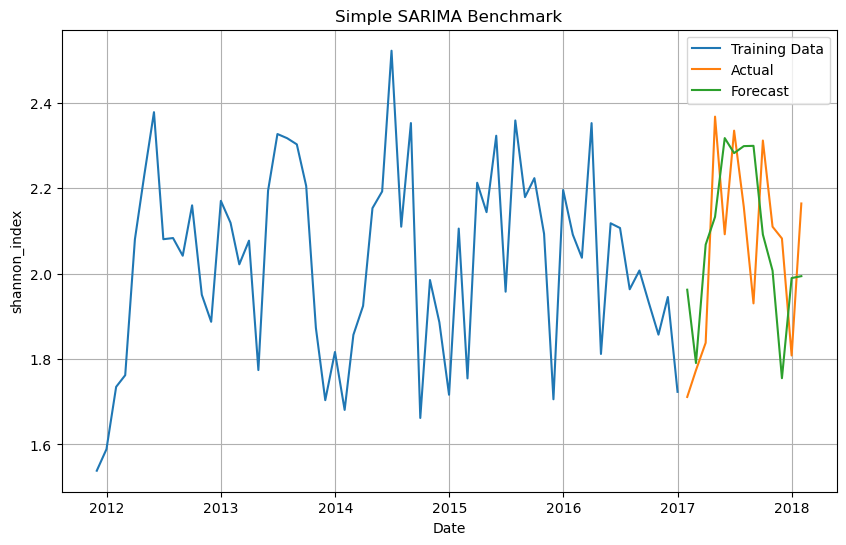

In [ ]:
# evaluate
y_pred = sarima_model_trained.forecast(steps=y_test.shape[0])
results_df = evaluate_predictions(results_df, y_pred, y_test, "Simple Sarima Benchmark")
plot_forecast(y_train, y_pred, actual=y_test, title="Simple SARIMA Benchmark")

#### Using an auto-timeseries package

Pdmarima can also be used to iterate over different parameters and find the best model (based on validation performance and metrics such as AIC and BIC)

In [ ]:
# Fit your model
model = pm.auto_arima(y_train, seasonal=True, m=12)

# extract best params
best_params = model.get_params()
best_params

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (0, 0, 2),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (1, 0, 2, 12),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': True}

MAE: 0.15957047556131548
MAPE: 0.07800938438642918
RMSE: 0.19060073610400505


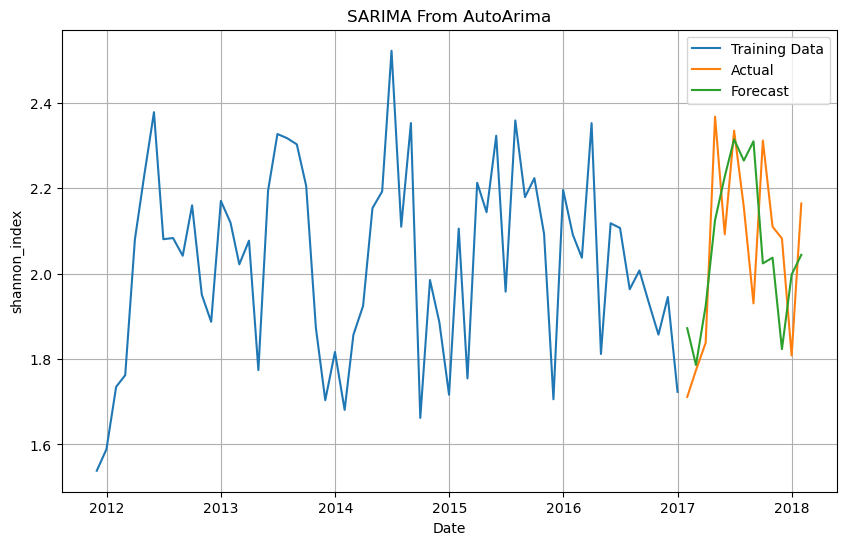

In [ ]:
# evaluate
y_pred = model.predict(y_test.shape[0])  # predict N steps into the future
results_df = evaluate_predictions(results_df, y_pred, y_test, "SARIMA From AutoArima")
plot_forecast(y_train, y_pred, actual=y_test, title="SARIMA From AutoArima")

#### Results of Time Series and Benchmarks

Below are the results from the benchmarks and the SARIMA models.

In [ ]:
results_df

Model      RMSE       MAE      MAPE
0       mean value benchmark  0.214512  0.190502  0.093870
1       last value benchmark  0.392056  0.330997  0.152141
2  monthly average benchmark  0.217982  0.195479  0.095462
3    Simple Sarima Benchmark  0.216434  0.194083  0.095974
4      SARIMA From AutoArima  0.190601  0.159570  0.078009

<blockquote style="background-color: #cce0ff; padding: 10px; border-radius: 5px; color: #004080;">
    <strong>Note:</strong> The model derived through auto arima performs best on the test period. Moreover, the performance of the manually created SARIMA model does indicate there are patterns in biodiverity that can be captured. However, the SARIMA models do struggle to converge and doesn't clearly out perform the bench marks. The next step is to see if external factors carry some information on future values of biodiversity.<br><br>It should also be noted that the small number of dates presents a challenge for training these models, as well as in creased chance of overfitting. 
</blockquote >  

#### External Variables analysis

Given the relative performance of the SARIMA models, we will use the auto arima model to understand the impact of external variables on the biodiversity.

The process will be as follows:

1. Create a model using the label alone
2. Calculate residuals from the training period
3. Calculate the correlation between the residuals and the external variables
4. Rank the variables by correlation, selecting the most correlated for exog variables

In [ ]:
model = SARIMAX(y_train, **best_params)
model_trained = model.fit(disp=False)

resids = model_trained.resid

In [ ]:
correlations = []

# Iterate over each external variable
for feature in features:
    # Calculate the correlation between residuals and the current feature
    correlation = pd.Series(resids).corr(
        X_train[feature].fillna(X_train[feature].mean())
    )

    # Append the correlation to the DataFrame
    correlations.append({"Feature": feature, "Correlation": correlation})

# Create the correlations DataFrame
correlations_df = pd.DataFrame(correlations)

# Sort the DataFrame by correlation in descending order
correlations_df = correlations_df.sort_values("Correlation", ascending=False)

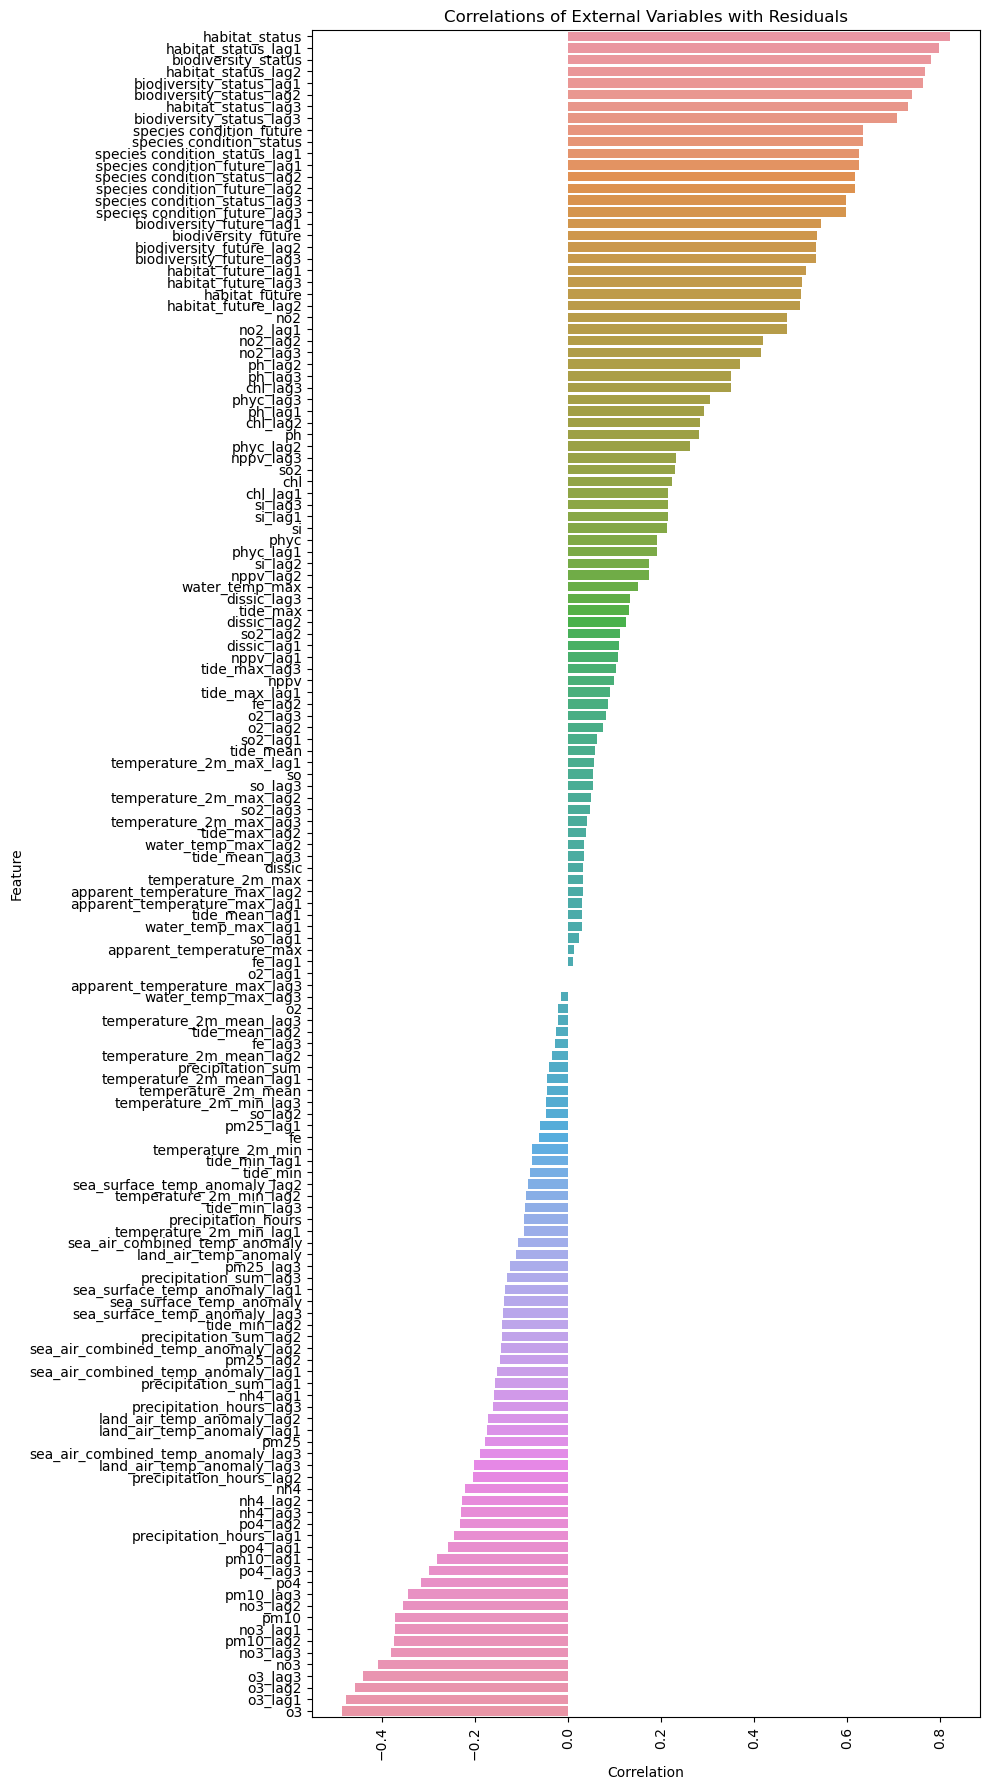

In [ ]:
plt.figure(figsize=(10, 18))
sns.barplot(y=correlations_df["Feature"], x=correlations_df["Correlation"], orient="h")
plt.xlabel("Correlation")
plt.ylabel("Feature")
plt.title("Correlations of External Variables with Residuals")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

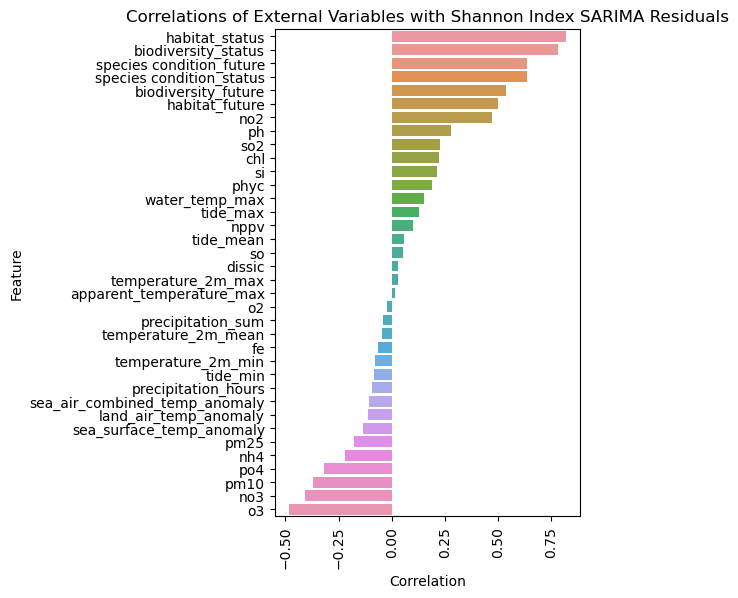

In [ ]:
# plot without the lag terms
corr_no_lag = correlations_df[~correlations_df["Feature"].str.contains("_lag")]
plt.figure(figsize=(6, 6))
sns.barplot(y=corr_no_lag["Feature"], x=corr_no_lag["Correlation"], orient="h")
plt.xlabel("Correlation")
plt.ylabel("Feature")
plt.title("Correlations of External Variables with Shannon Index SARIMA Residuals")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
corr_no_lag.to_parquet("../data/corr_no_lag.parquet")

<blockquote style="background-color: #cce0ff; padding: 10px; border-radius: 5px; color: #004080;">
    <strong>Note:</strong> The annual ocean health index values (for portugal) are by far the most correlated. This of course makes sense, as after we remove seasonal and other time effects you would expect the biodivesity to correlate with an annual metric measuring something similar (but at national and annual level). While these features may not be useful for the model (due to their similarity to the label) is nevertheless intresting to know how the biodiversity in this small area is linked to the overall health of Portugals oceans. Possibly suggesting that the lack of recovery in this zone may be caused by much more global factors. <br><br>
    For the other terms, it seems that residuals are somewhat correlated with sea water content variables, at multiple lags. Weather/Climate are less correlated, this could be due to these variables being very season dependent and hence the seasonal component of the SARIMA model is capturing this information. Howver, the monthly anaomaly temperatures may be useful as they are compared to historical means and are not season dependent.
</blockquote >  

#### Adding External variables to a SARIMA model

We will use the variables with an absolute correlation above 0.15.

The aim of this section is too train multiple SARIMA models, each with a different set of external variables. We will then compare the coefficients of these models to see which variables are continually the most important.

In [ ]:
exog_features = correlations_df[
    correlations_df["Correlation"].abs() > 0.2
].Feature.to_list()
# we will remove the ocean health index as there is potential overlap with the biodiverity
exog_features = [
    x for x in exog_features if ("status" not in x) and ("future" not in x)
]

n = 1000
# for r in range(1, min(4, len(exog_features)) + 1):
exog_combinations = random_combinations = random.sample(
    list(itertools.combinations(exog_features, 3)), n
)

len(exog_combinations)

In [ ]:
# define a helper for scoring exog performance
def evaluate_exog_sarima(exog_results_df, trained_model, X_test, y_test, model_name):
    # Start an MLflow run to track the experiment
    # Set the active experiment

    # Make predictions on test data
    y_pred = trained_model.forecast(forecast_steps, exog=X_test)

    # Calculate the MAE and MAPE metrics
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    exog_results_df.loc[exog_results_df.shape[0]] = [
        model_name,
        rmse,
        mae,
        mape,
        trained_model.aic,
        trained_model.bic,
    ]
    # Return the model
    return exog_results_df

In [ ]:
# train some sarimax models with random combinations of features to find the ones that are repeadly import or result in a good fit
# #Turn warnings off due to the long output
warnings.filterwarnings("ignore")

# define a df to keep track of results
exog_results_df = pd.DataFrame(columns=["Model", "RMSE", "MAE", "MAPE", "AIC", "BIC"])
coeffs_df = pd.DataFrame(columns=["feature", "coefficient"])
for i, combination in tqdm(enumerate(exog_combinations), total=len(exog_combinations)):
    exog_vars = list(combination)
    model = sm.tsa.statespace.SARIMAX(
        endog=y_train, exog=X_train[exog_vars], **best_params
    )
    trained_model = model.fit(disp=False)
    coeff_df = (
        trained_model.params[exog_vars]
        .to_frame()
        .reset_index()
        .rename(columns={"index": "feature", 0: "coefficient"})
    )
    coeffs_df = pd.concat([coeffs_df, coeff_df], axis=0, ignore_index=True)
    # Store AIC and BIC in the results DataFrame
    exog_results_df = evaluate_exog_sarima(
        exog_results_df,
        trained_model,
        X_test[exog_vars],
        y_test,
        f"SARIMA Exog {exog_vars}",
    )

warnings.filterwarnings("default")

100%|██████████| 1000/1000 [08:26<00:00,  1.98it/s]


In [ ]:
avg_coeffs = (
    coeffs_df.groupby("feature").mean().sort_values("abs_coefficient", ascending=False)
)

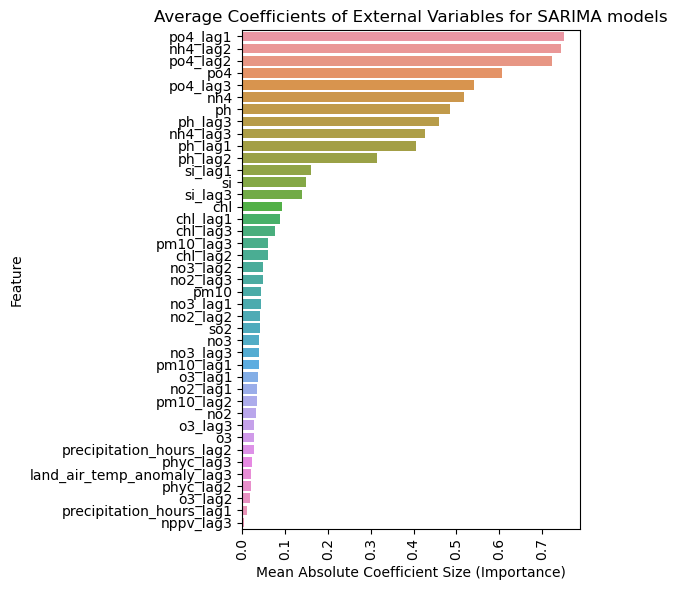

In [ ]:
# plot without the lag terms
plt.figure(figsize=(6, 6))
sns.barplot(y=avg_coeffs.index, x=avg_coeffs["abs_coefficient"], orient="h")
plt.xlabel("Mean Absolute Coefficient Size (Importance)")
plt.ylabel("Feature")
plt.title("Average Coefficients of External Variables for SARIMA models")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

<blockquote style="background-color: #cce0ff; padding: 10px; border-radius: 5px; color: #004080;">
    <strong>Note:</strong> While the feature importance was performed on a relatively small subset of features (due to computational limitations), a clear subset of features emerged as important (high exog coefficients in fitted models)
</blockquote >  

In [ ]:
# potential combinations
exog_results_df.sort_values("MAE")

Model      RMSE       MAE  \
788     SARIMA Exog ['ph_lag1', 'nh4_lag2', 'o3_lag3']  0.167162  0.130161   
170    SARIMA Exog ['no2_lag2', 'ph_lag1', 'nh4_lag2']  0.167575  0.130485   
779     SARIMA Exog ['ph_lag3', 'nh4_lag2', 'o3_lag2']  0.157510  0.131930   
438          SARIMA Exog ['ph_lag3', 'chl', 'o3_lag2']  0.165678  0.132490   
701     SARIMA Exog ['ph_lag1', 'po4_lag2', 'o3_lag3']  0.177045  0.133472   
..                                                 ...       ...       ...   
767   SARIMA Exog ['no2_lag2', 'po4_lag2', 'no3_lag1']  0.723838  0.604505   
531  SARIMA Exog ['no2_lag2', 'nppv_lag3', 'po4_lag1']  0.703637  0.606013   
258  SARIMA Exog ['si_lag3', 'precipitation_hours_l...  0.692421  0.610422   
931  SARIMA Exog ['nppv_lag3', 'precipitation_hours...  0.787481  0.659366   
548   SARIMA Exog ['po4_lag2', 'no3_lag1', 'no3_lag3']  0.872152  0.773036   

         MAPE        AIC         BIC  
788  0.063901 -28.508928   -9.364719  
170  0.064134 -30.518039  -11.373830  
779  0.065607 -28.510607   -9.366398  
438  0.064586 -21.028090   -1.883881  
701  0.064989 -24.937101   -5.792891  
..        ...        ...         ...  
767  0.284867  58.622165   77.766374  
531  0.285255  66.403418   85.547628  
258  0.296545  87.033616  106.177825  
931  0.311577  92.486101  111.630311  
548  0.375995  66.409209   85.553418  

[1000 rows x 6 columns]

Text(0.5, 1.0, 'Correlation between Important External Variables')

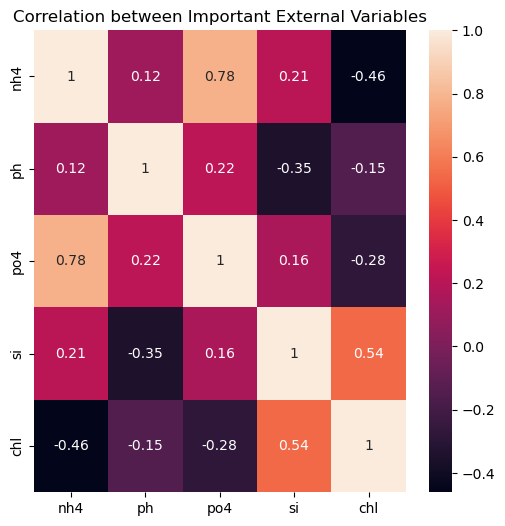

In [ ]:
# check correlations with each other
plt.figure(figsize=(6, 6))
sns.heatmap(X_train[["nh4", "ph", "po4", "si", "chl"]].corr(), annot=True)
plt.title("Correlation between Important External Variables")

<blockquote style="background-color: #cce0ff; padding: 10px; border-radius: 5px; color: #004080;">
    <strong>Note:</strong> Some combinations emerged as outperforming the best SARIMA model. However, given the small number of data points, the results are not conclusive. It is therefore more appropriate to select from the bool of important features rather than any specfic combination. Therefore <b>po4, si and ph</b> will be selected at lag 3 given they are some of the most important features (and that these terms do not correlate strongly with each other). Lag 3 is selected to allow for the possibility of more accurate 3 month predictions.
</blockquote > 

#### And the final model will be...

In [ ]:
exogs=["po4_lag3", "si_lag3", "ph_lag3"]

In [ ]:
model = SARIMAX(endog=y_train, exog=X_train[exogs], **best_params)
trained_model = model.fit(disp=False)

/home/mcgibs/miniconda3/envs/wdl/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAE: 0.17041623427039856
MAPE: 0.08282448934266694
RMSE: 0.20185434848516665


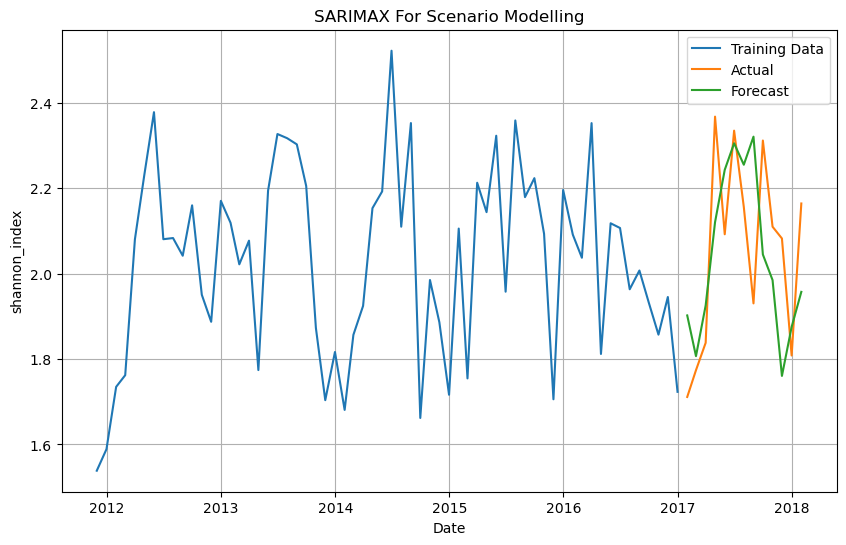

In [ ]:
y_pred = trained_model.forecast(forecast_steps, exog=X_test[exogs])
results_df = evaluate_predictions(results_df, y_pred, y_test, "SARIMAX For Scenario Modelling")
plot_forecast(y_train, y_pred, actual=y_test, title="SARIMAX For Scenario Modelling")

In [ ]:
#The overall results
#Note the RNN model was trained in the appendix
results_df

Model      RMSE       MAE      MAPE
0            mean value benchmark  0.214512  0.190502  0.093870
1            last value benchmark  0.392056  0.330997  0.152141
2       monthly average benchmark  0.217982  0.195479  0.095462
3         Simple Sarima Benchmark  0.216434  0.194083  0.095974
4           SARIMA From AutoArima  0.190601  0.159570  0.078009
5  SARIMAX For Scenario Modelling  0.201854  0.170416  0.082824
6          SARIMAX From AutoArima  0.265410  0.219240  0.112029
7                             RNN  0.196411  0.179594  0.086363

#### Put these steps together in a class

Our aim is to create a package that allows for analysis of time series data, as well as forecasting. Therefore, we can combine the methods defined through the above analysis to create a flexible class that can be used for analysis and forecasting of different data sets and labels.

As input, it will take:

- **df**-> The result of the cleaning and feature engineering
- **label** -> The target label of interest (e.g. shannon_index)
- **features** -> The features to be used in the model
- **date_features** -> any additional date features to be used in the model
- **split date** -> the point from which to split the data into train and test
- **last date** (optional) -> the last date to forecast to (if not provided, will forecast to the end of the data)
- **freq** (optional) -> the frequency of the data (e.g. 'M' for monthly)
- **lag_values** (optinal) -> the lag values to use for the exog variables (if not provided, will use the lag values from the analysis [1,2,3])

The class can then perform the following steps (feature importance technique is not included, due to the computational limitations of the analysis):

- **(On creation)** -> Convert data for time series analysis split the data into train and test (storing the portions of the data for later analysis)
- **train_auto_arima()** -> Based on the provided label, train a SARIMA model using pmdarima
- **forecast()** -> Forecast the SARIMA model to the end of the data (or to the last date provided), providing the plot and metrics(MAE,MAPE, RMSE) in comparrison to the test period
- **plot_seasonality()** -> Display the monthly trends over the time period (a plot for each month)
- **plot_seasonal_decomposition()** -> Train and show the output of a seasonal decompasition model (seperating the trend from the seaonallity)
- **residual_analysis()** -> Calculate the residuals from the SARIMA model and perform a correlation analysis with the provided features. Display the results in a barchart. This can give an indication of feature importance.
- **train_exog_sarima()** -> Train a SARIMA model with the provided features as exog variables.

This class is defined in [MarineTimeSeriesAnalysis](#MarineTimeSeriesAnalysis)

Analysis performed on Invasive and Endagered species can be found in the appendix.

#### Modelling Conclusion

In conclusion the biodiversity label was forecasted with simple sarima models to show that the time effects have an impact on biodiversity and that a trend can be modelled. Analysis of this trend showed biodiversity to be largelly stationary (constant), but varied considerbly per season.

Moreover, once the time effects were removed from the data (namely seasonallity) it was shown that the biodiversity correlates with several external variables (po4, si, ph). Then also, by analysing the coefficients of multiple models these variables were also shown to be important. 

Given that the aim is to predict how future biodiversity in the area is impacted by external variables, the sarimax model with these variables present a solid option for doing just that.

### Scenario Forecasting

In order to forecast long into the future and see how future biodiversity is impacted by external variables, we need to model scenarios where these variables change over time.

To do this, we have defined the [model_scenarios](#model_scenarios) function and it's dependencies.

To model scenario, we are projecting our important features (used to train the model) into the future. To do this we are selecting a range of potential mean values for these features in n months time. Therefore, for each variable in turn, the scenario forecasting will predict our target (biodiverty) given the projected changes (to the mean) of the external feature.

Historic resampling and the addition of noise is used to make these linear mean changes more realistic.

The range of future mean values was set given the current min/max/mean values of the variables.

**Note** As discussed in the data split step, the final date in our sample is 2018. Hence all forecasts will be from 2018 to 2028.

In [ ]:
forecast steps = 12*10 # 10 years

variable_ranges ={
    
    "po4_lag3":np.linspace(0.1,1.5,20),
    'si_lag3':np.linspace(1.5,6.6,20),
    'ph_lag3':np.linspace(7.3,8.7,20),
}

In [ ]:
#create a df with all the potential biodiversity forecasts given an increase/decrease in a features mean over time
df_scenarios = model_scenarios(model, X_train[exogs], forecast_steps, variable_ranges)

In [ ]:
df_scenarios

date  predicted_mean  variable  projected_value
0   2018-02-28        1.885596  po4_lag3              0.1
1   2018-03-31        2.400491  po4_lag3              0.1
2   2018-04-30        1.999168  po4_lag3              0.1
3   2018-05-31        2.160837  po4_lag3              0.1
4   2018-06-30        2.420214  po4_lag3              0.1
..         ...             ...       ...              ...
115 2027-09-30        2.265360   ph_lag3              8.7
116 2027-10-31        1.984146   ph_lag3              8.7
117 2027-11-30        2.245180   ph_lag3              8.7
118 2027-12-31        2.044452   ph_lag3              8.7
119 2028-01-31        2.189056   ph_lag3              8.7

[7200 rows x 4 columns]

In [ ]:
df_scenarios['variable']=df_scenarios['variable'].str.split('_lag').str[0]
df_scenarios.rename(columns={'predicted_mean':'shannon_index_forecast','projected_value':'projected_value_2028'}, inplace=True)

<Axes: xlabel='date', ylabel='shannon_index'>

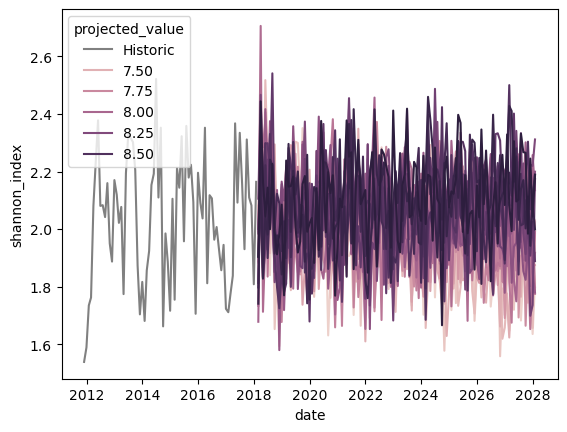

In [ ]:
#A visualisation of how the biodiversity is projected to change over the next 10 years given the projected mean ph value at that time.
import seaborn as sns
sns.lineplot(x=y_train.index, y=y_train, label='Historic',color='grey')
sns.lineplot(x='date', y='predicted_mean', data=df_scenarios[df_scenarios['variable']=='ph'], hue='projected_value')

###  Interpretability

Interpretability played a large part in the selection of our modelling technique and final model. This is because to meet our goal of 'identifying variables' that impact our label (biodiversity), we needed to understand how any model we built was influenced by these variables. This is very possible with statistical approaches like **SARIMA** modelling, as the model's coefficients are fully visible in the trained model (i.e it's not a black box solution). This means we can learn from our models and give clear reccomendations in terms of important variables.


This is why we chose SARIMA modelling over the **RNN** approach (despite the advantages a deep learning approach has in terms of typically extracting more performance).

Fairness is not as applicable in these models, due the choice of variables, as there will be no specific impact of using some variables over others. However, we did specify earlier in the notebook that we did have to make some assumptions that regions near Cascais will have similar records to that of Cascais, as we were unablet to get only Cascais data. 

## 🖼️ Visualisations

Further explanations and analysis of these visualisations are available in the EDA sections above, however we have just copied the most interesting ones below:

#### Non Invasive Sessil Species for the Different Tidal Zones

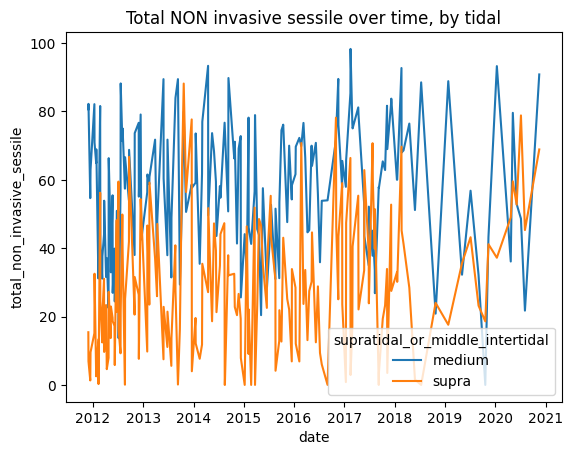

In [ ]:
## Looking at non invasive as a comparison:
sns.lineplot(data=df2, x='date', y='total_non_invasive_sessile',  hue='supratidal_or_middle_intertidal',errorbar=None)
plt.title("Total NON invasive sessile over time, by tidal")
plt.show()

#### Plotting the Seasonal Effects on Biodiversity (Shannon Index)

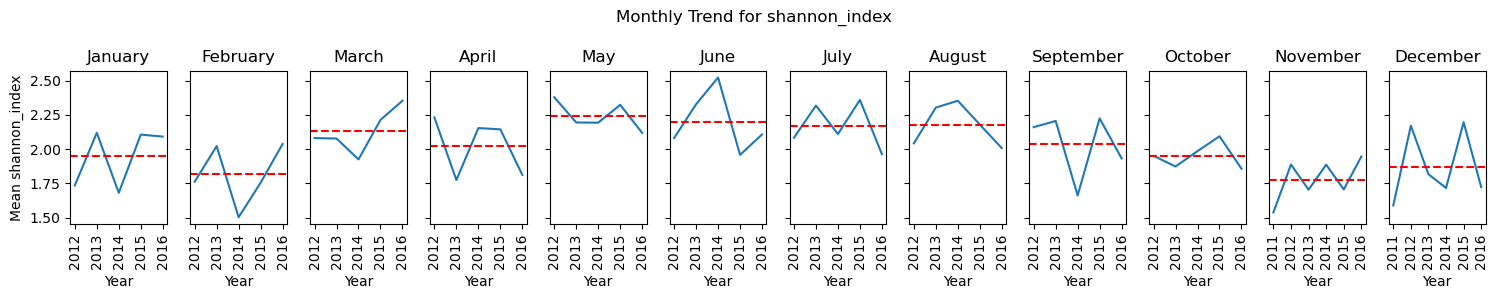

In [ ]:
visualize_monthly_trend(y_train)

#### Comparing External Variables with the Biodiversity label (after time effects have been removed)

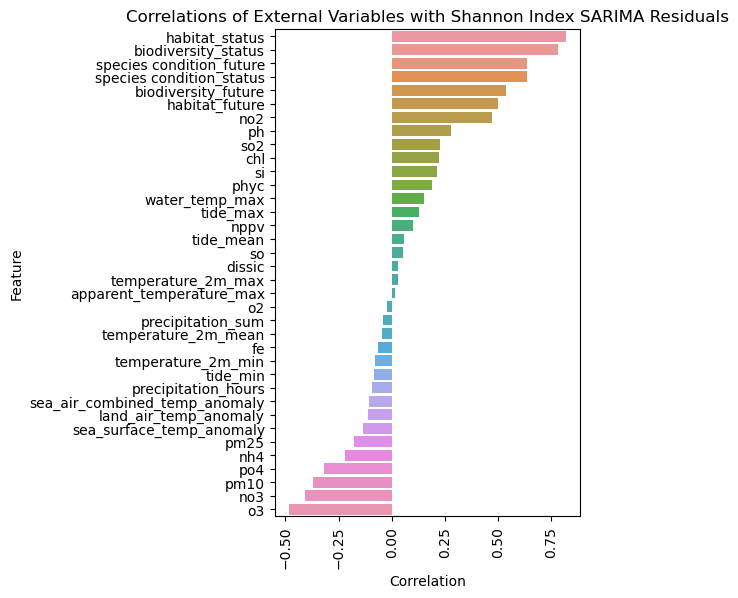

In [ ]:
# plot without the lag terms
corr_no_lag = correlations_df[~correlations_df["Feature"].str.contains("_lag")]
plt.figure(figsize=(6, 6))
sns.barplot(y=corr_no_lag["Feature"], x=corr_no_lag["Correlation"], orient="h")
plt.xlabel("Correlation")
plt.ylabel("Feature")
plt.title("Correlations of External Variables with Shannon Index SARIMA Residuals")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#### Comparing Predicted v Actual Biodiversity (from a SARIMAX Model)

/home/mcgibs/miniconda3/envs/wdl/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAE: 0.17041623427039856
MAPE: 0.08282448934266694
RMSE: 0.20185434848516665


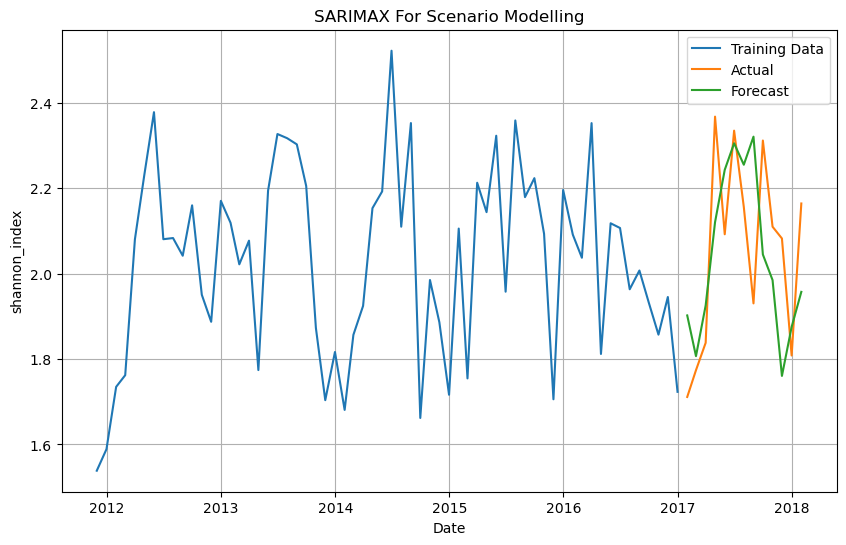

In [ ]:
y_pred = trained_model.forecast(forecast_steps, exog=X_test[exogs])
results_df = evaluate_predictions(results_df, y_pred, y_test, "SARIMAX For Scenario Modelling")
plot_forecast(y_train, y_pred, actual=y_test, title="SARIMAX For Scenario Modelling")

#### Forecasted Biodiversity up to 2028 (with varying ph levels in the sea)

<Axes: xlabel='date', ylabel='shannon_index'>

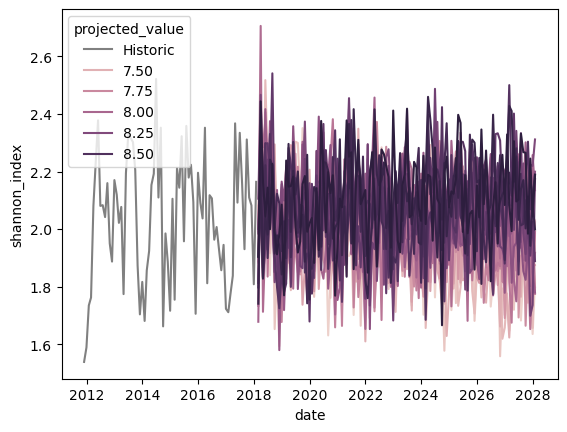

In [ ]:
#A visulisation of how the biodiversity is projected to change over the next 10 years given the projected mean ph value at that time.
import seaborn as sns
sns.lineplot(x=y_train.index, y=y_train, label='Historic',color='grey')
sns.lineplot(x='date', y='predicted_mean', data=df_scenarios[df_scenarios['variable']=='ph'], hue='projected_value')

## 👓 References

- Ana Ferreira et al, Ecosystem response to different management options in Marine Protected Areas (MPA): A case study of intertidal rocky shore communities- https://www.sciencedirect.com/science/article/abs/pii/S1470160X17303709?via%3Dihub
- Meteo open weather API https://open-meteo.com/
- University of East Anglia Climate Data (including references to papers) https://crudata.uea.ac.uk/cru/data/temperature/?_ga=2.35621282.2009552220.1683452211-1486011184.1682889046#datdow
- Copernicus Global Ocean Physics Reanalysis https://data.marine.copernicus.eu/product/GLOBAL_MULTIYEAR_PHY_001_030/description
- Copernicus Atlantic-Iberian Biscay Irish- Ocean BioGeoChemistry NON ASSIMILATIVE Hindcast  https://data.marine.copernicus.eu/product/IBI_MULTIYEAR_BGC_005_003/description
- Worlds Air Pollution (AQI) - https://waqi.info/#/c/8.407/9.026/2.2z
- Ocean Health Index - https://oceanhealthindex.org/global-scores/data-download/
- Shannon Diversity Index Calculation - https://www.statology.org/shannon-diversity-index/#:~:text=The%20Shannon%20Diversity%20Index%20(sometimes,i%20*%20ln(pi)
- Deepananda and Macusci , Human Disturbance in a Tropical Rocky Shore Reduces Species Diversity - https://www.researchgate.net/publication/262458621_Human_Disturbance_in_a_Tropical_Rocky_Shore_Reduces_Species_Diversity
- pmdarima - https://github.com/alkaline-ml/pmdarima
- statsmodels - https://github.com/statsmodels/statsmodels



## ⏭️ Appendix
Here are extra code snippets and graphs not included above

##### ACF and PACF plots for 12 month differenced

Plot for seasonal differenced (For example,the difference between this month and last month accross the data (i.e Feb 2018 - Feb 2017))

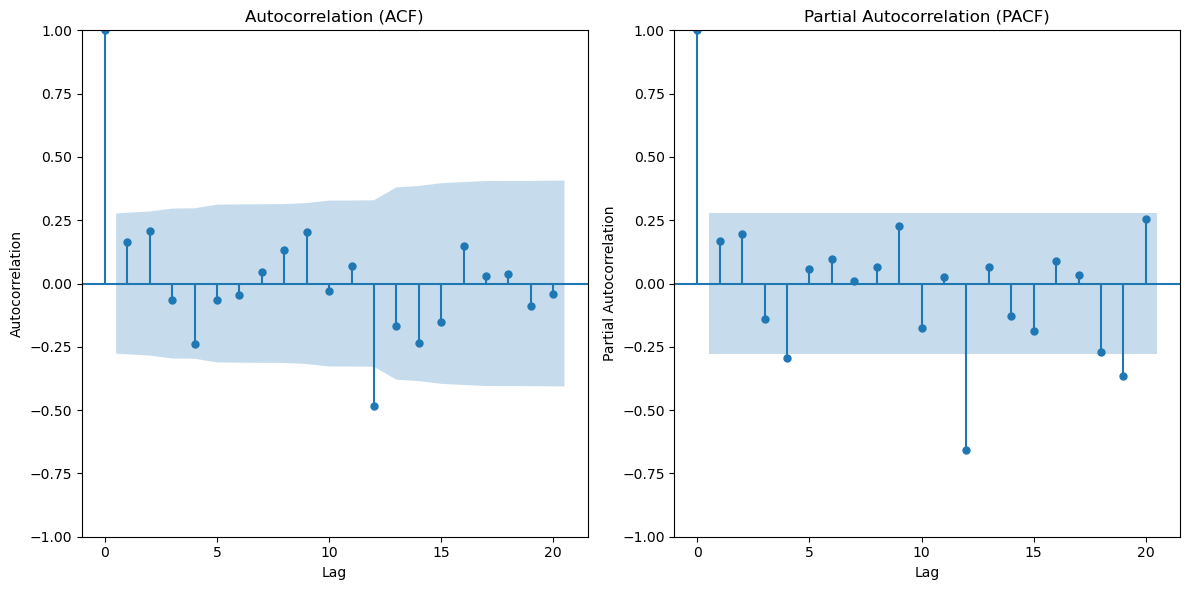

In [ ]:
y_diff = y_train.diff(periods=12).dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot ACF
plot_acf(y_diff, lags=20, ax=ax1)
ax1.set_xlabel("Lag")
ax1.set_ylabel("Autocorrelation")
ax1.set_title("Autocorrelation (ACF)")

# Plot PACF
plot_pacf(y_diff, lags=20, ax=ax2)
ax2.set_xlabel("Lag")
ax2.set_ylabel("Partial Autocorrelation")
ax2.set_title("Partial Autocorrelation (PACF)")

plt.tight_layout()

plt.show()

<blockquote style="background-color: #cce0ff; padding: 10px; border-radius: 5px; color: #004080;">
    <strong>Note:</strong> Not strong indicators of AR or MA terms (perhaps the 12th lag in PACf plot). However, this does confirm that the seasonal component needs differenced in order to be useful (confirming the stationarity test).
</blockquote >  
    

Difference Seasonal (For example, finding the difference between (Feb 2018 - Feb 2017) and (Jan 2018 - Jan 2017))

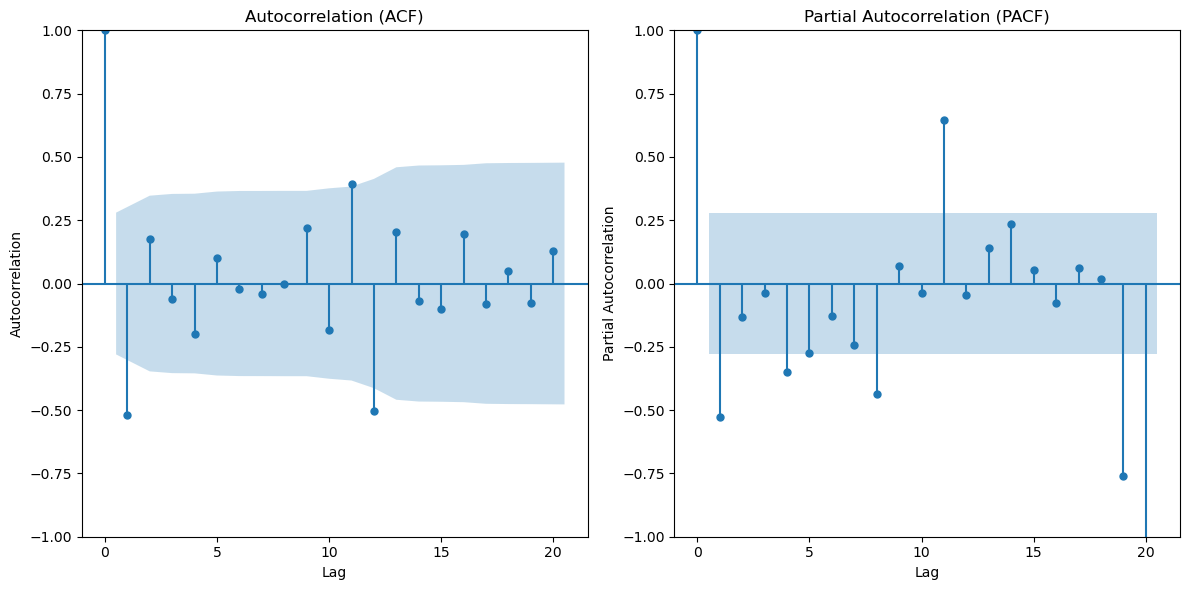

In [ ]:
y_diff = y_train.diff(periods=12).dropna()
y_diff = y_diff.diff(1).dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot ACF
plot_acf(y_diff, lags=20, ax=ax1)
ax1.set_xlabel("Lag")
ax1.set_ylabel("Autocorrelation")
ax1.set_title("Autocorrelation (ACF)")

# Plot PACF
plot_pacf(y_diff, lags=20, ax=ax2)
ax2.set_xlabel("Lag")
ax2.set_ylabel("Partial Autocorrelation")
ax2.set_title("Partial Autocorrelation (PACF)")

plt.tight_layout()

plt.show()

<blockquote style="background-color: #cce0ff; padding: 10px; border-radius: 5px; color: #004080;">
    <strong>Note:</strong> ACF plot shows spike at 1 and 12, indicating 1st order MA and 1st order differencing of the seasonal component<br><br>
    PACF shows spike at lag 1, as well as lag 9. Definetly 1st order AR component needed (possibly 9)
</blockquote >  
    

#### RNN (Appendix)

Train some rnns with tensor flow

In order to train timeseries, the sequential data needs to be windowed into multiple input and predict(shift) sections for both the features and labels. The below classes contains methods for managing this process as well as helpers for plotting results.

The basis of this class comes from the super helpful TensorFlow guide on time series forecasting -> https://www.tensorflow.org/tutorials/structured_data/time_series#advanced_autoregressive_model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

2023-05-17 21:02:01.432032: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-17 21:02:01.738912: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-17 21:02:01.740515: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-17 21:02:03.025141: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/mcgibs/miniconda3/envs/wdl/lib/python3.11/site-packages/tensorflow/python/debug/cli/debugger_cli_common.py:19: DeprecationWarning: module 'sre_constants' is deprecated
  import sre_constants


In [ ]:
# remove lag terms
no_lag_features = [x for x in features if "lag" not in x]

In [ ]:
# using up to the end of the twice monthly data as the split date
X_train, X_test, y_train, y_test = split_dataset_by_date(
    df_shannon, label, no_lag_features, "2017-01-01"
)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Scale the features
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaled_train_features = scaler_features.fit_transform(X_train)
train_df = pd.DataFrame(scaled_train_features, columns=X_train.columns)

# Scale the labels
scaler_label = MinMaxScaler(feature_range=(0, 1))
train_df[label] = scaler_label.fit_transform(y_train.values.reshape(-1, 1))

# Scale test data
scaled_test_features = scaler_features.transform(X_test)
test_df = pd.DataFrame(scaled_test_features, columns=X_test.columns)
test_df[label] = scaler_label.transform(y_test.values.reshape(-1, 1))

In [ ]:
class WindowGenerator:
    def __init__(
        self,
        input_width,
        label_width,
        shift,
        train_df=None,
        test_df=None,
        label_columns=None,
    ):
        # Store the raw data.
        self.train_df = train_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {
                name: i for i, name in enumerate(label_columns)
            }
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return "\n".join(
            [
                f"Total window size: {self.total_window_size}",
                f"Input indices: {self.input_indices}",
                f"Label indices: {self.label_indices}",
                f"Label column name(s): {self.label_columns}",
            ]
        )


def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1,
        )

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels


WindowGenerator.split_window = split_window


def plot(self, model=None, plot_col="T (degC)", max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n + 1)
        plt.ylabel(f"{plot_col} [normed]")
        plt.plot(
            self.input_indices,
            inputs[n, :, plot_col_index],
            label="Inputs",
            marker=".",
            zorder=-10,
        )

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(
            self.label_indices,
            labels[n, :, label_col_index],
            edgecolors="k",
            label="Labels",
            c="#2ca02c",
            s=64,
        )
        if model is not None:
            predictions = model(inputs)
            plt.scatter(
                self.label_indices,
                predictions[n, :, label_col_index],
                marker="X",
                edgecolors="k",
                label="Predictions",
                c="#ff7f0e",
                s=64,
            )

        if n == 0:
            plt.legend()

    plt.xlabel("Time [h]")


WindowGenerator.plot = plot


def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,
    )

    ds = ds.map(self.split_window)

    return ds


WindowGenerator.make_dataset = make_dataset


@property
def train(self):
    return self.make_dataset(self.train_df)


@property
def test(self):
    return self.make_dataset(self.test_df)


@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, "_example", None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result


WindowGenerator.train = train
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
OUT_STEPS = 13
multi_window = WindowGenerator(
    train_df=train_df,
    test_df=test_df,
    label_columns=["shannon_index"],
    input_width=13,
    label_width=13,
    shift=13,
)

In [ ]:
num_features = test_df.shape[1]

In [ ]:
MAX_EPOCHS = 20


def compile_and_fit(model, window, patience=2):
    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=[tf.keras.metrics.MeanAbsoluteError()],
    )

    history = model.fit(window.train, epochs=MAX_EPOCHS)
    return history

In [ ]:
multi_dense_model = tf.keras.Sequential(
    [
        # Take the last time step.
        # Shape [batch, time, features] => [batch, 1, features]
        tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
        # Shape => [batch, 1, dense_units]
        tf.keras.layers.Dense(512, activation="relu"),
        # Shape => [batch, out_steps*features]
        tf.keras.layers.Dense(
            OUT_STEPS * num_features, kernel_initializer=tf.initializers.zeros()
        ),
        # Shape => [batch, out_steps, features]
        tf.keras.layers.Reshape([OUT_STEPS, num_features]),
    ]
)

history = compile_and_fit(multi_dense_model, multi_window)

Epoch 1/20


2023-05-17 21:02:05.218289: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-17 21:02:05.218853: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-05-17 21:02:05.392375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [62,37]
	 [[{{node Placeholder/_0}}]]
2023-05-17 21:02:05.3927

2/2 [==============================] - 1s 13ms/step - loss: 0.3159 - mean_absolute_error: 0.5138
Epoch 2/20
2/2 [==============================] - 0s 6ms/step - loss: 0.2333 - mean_absolute_error: 0.4261
Epoch 3/20
2/2 [==============================] - 0s 6ms/step - loss: 0.1460 - mean_absolute_error: 0.3212
Epoch 4/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0759 - mean_absolute_error: 0.2323
Epoch 5/20
2/2 [==============================] - 0s 5ms/step - loss: 0.0565 - mean_absolute_error: 0.1962
Epoch 6/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0881 - mean_absolute_error: 0.2366
Epoch 7/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0988 - mean_absolute_error: 0.2512
Epoch 8/20
2/2 [==============================] - 0s 7ms/step - loss: 0.0764 - mean_absolute_error: 0.2195
Epoch 9/20
2/2 [==============================] - 0s 7ms/step - loss: 0.0555 - mean_absolute_error: 0.1914
Epoch 10/20
2/2 [==============================

In [ ]:
preds = multi_dense_model.predict(multi_window.test)

1/1 [==============================] - 0s 101ms/step


2023-05-17 21:02:06.812207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [46,37]
	 [[{{node Placeholder/_0}}]]
2023-05-17 21:02:06.812556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


In [ ]:
y_pred = pd.Series(scaler_label.inverse_transform(preds[0, :, -1].reshape(-1, 1))[:, 0])

In [ ]:
actuals = y_test[:13]

MAE: 0.17959431728755312
MAPE: 0.08636327981047723
RMSE: 0.19641139464391513


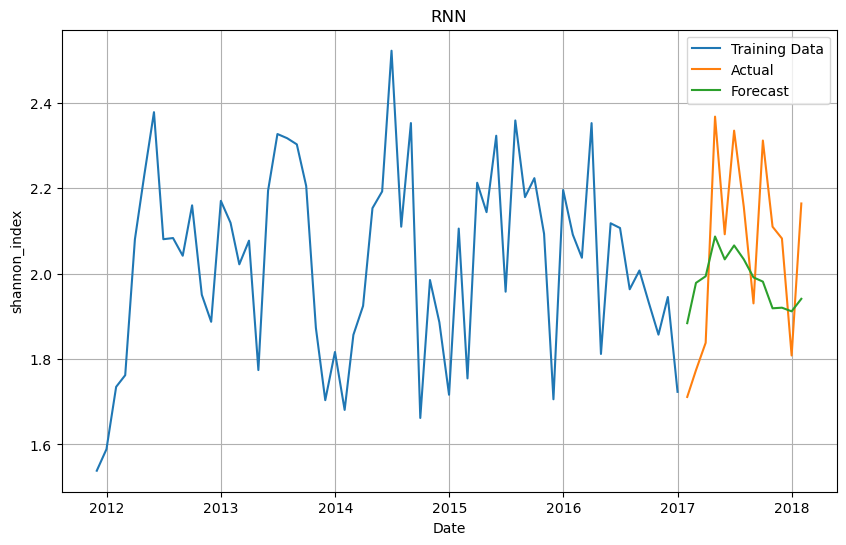

In [ ]:
results_df = evaluate_predictions(
    results_df, y_pred, actuals, "RNN"
)
plot_forecast(y_train, y_pred, actual=actuals, title="RNN")

<blockquote style="background-color: #cce0ff; padding: 10px; border-radius: 5px; color: #004080;">
    <strong>Note:</strong> From inspecting the plot, there seems to be some signal in the prediction. However, on the (admittedly very small training sampe) it performs no better than the SARIMA models. This could be due to the small training sample, and the fact that the RNN could be overfitting the noisey train data. Despite that, the RNN could offer a good solution for larger data problems and has the benefit of learning potential non-linear relationships between the features and labels.
</blockquote >  

#### Total Invasive Species Predictions

We will use the derived class to predict the total number of invasive species in the area (as for biodivesity)

In [ ]:
# create the time series analysis object
invasive_analysis = MarineTimeSeriesAnalysis(
    df,
    label="total_invasive_sessile",
    features=base_features,
    date_features=date_features,
    split_date="2017-01-01",
    last_date="2018-02-01",
    freq="M",
    lag_values=[1, 2, 3],
)

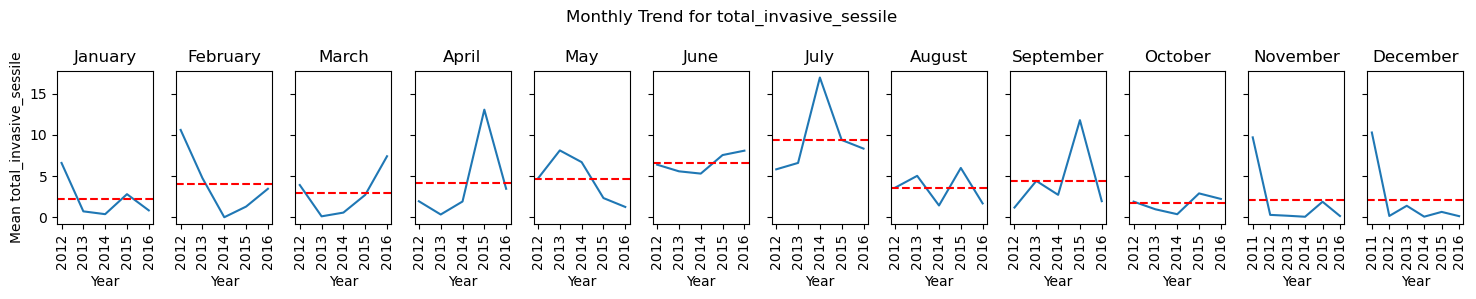

In [ ]:
# see how the label changes over the months and years
invasive_analysis.plot_seasonality()

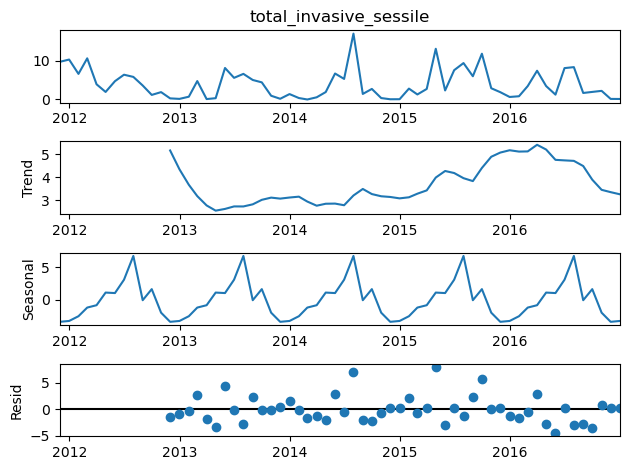

In [ ]:
# view the seasonality through seasonal decomposition
invasive_analysis.plot_seasonal_decomposition()

In [ ]:
# train a SARIMA model (no external variables) using pmdarima to fine tune the hyperparameters
invasive_analysis.train_auto_sarima()

ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(1, 0, 0, 12),
      suppress_warnings=True)

MAE: 3.613651815562181
MAPE: 2.1747140004311722
RMSE: 4.885018315581292


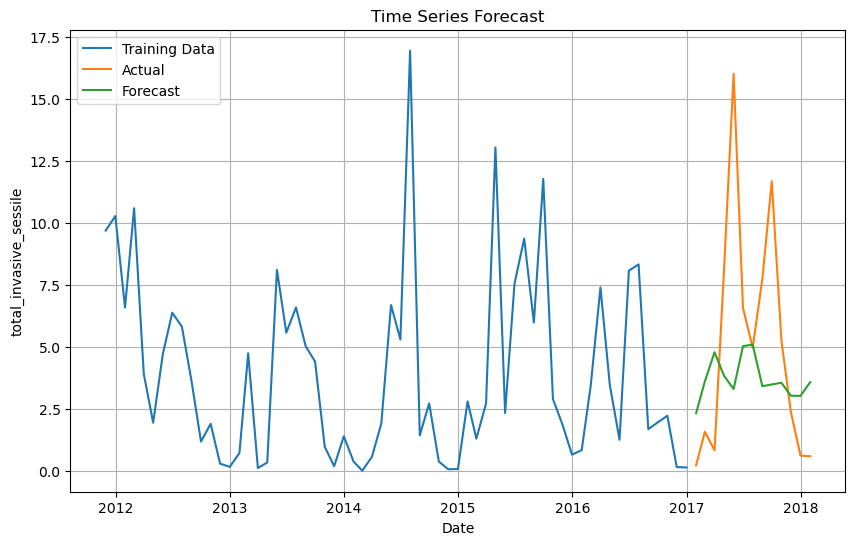

In [ ]:
# plot the forecast
invasive_analysis.forecast()

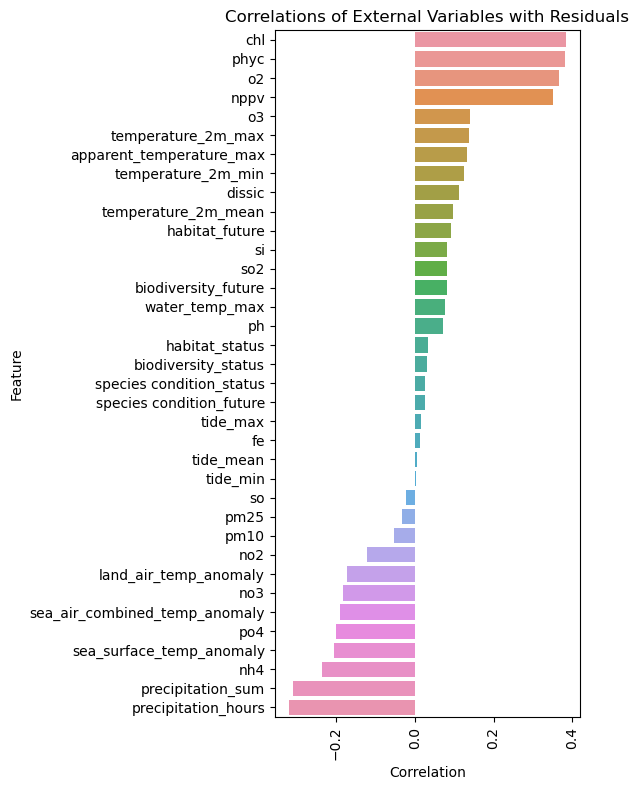

In [ ]:
# carry out a form of seature selection by comparing the correlation of the residuals with the external variables
invasive_analysis.residual_analysis()

In [ ]:
# based of the residual analysis, choose external variable that correlate with the residuals from the training set
invasive_analysis.train_exog_sarima(
    ["chl_lag3", "precipitation_hours_lag3", "nh4_lag3"]
)

MAE: 4.126176901315747
MAPE: 2.5803198698888177
RMSE: 5.3163509082777844


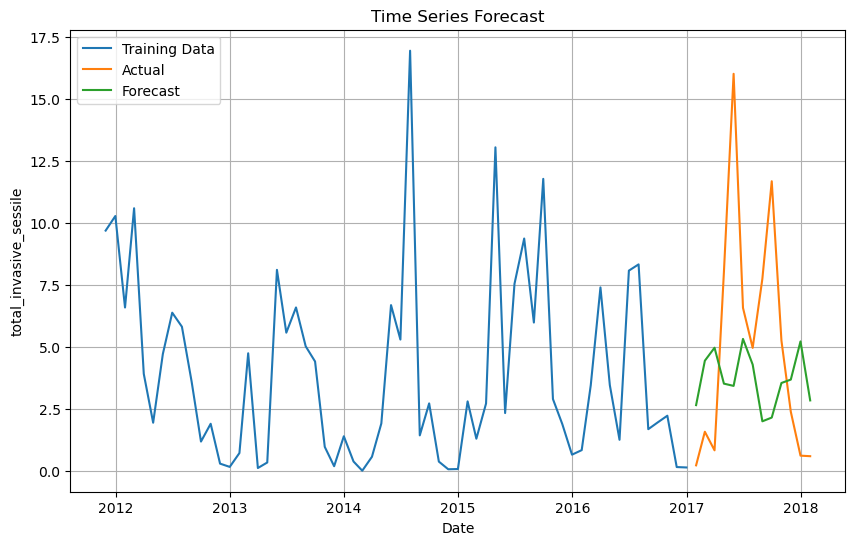

In [ ]:
# forcast with exog variables
invasive_analysis.forecast(model_type="SARIMAX")

#### Endangered Species Analysis

Again, we will use the derived class to predict the total number of endangered species in the area (as for biodivesity)

In [ ]:
# create the time series analysis object
endangered_analysis = MarineTimeSeriesAnalysis(
    df,
    label="total_pot_endangered_mobile",
    features=base_features,
    date_features=date_features,
    split_date="2017-01-01",
    last_date="2018-02-01",
    freq="M",
    lag_values=[1, 2, 3],
)

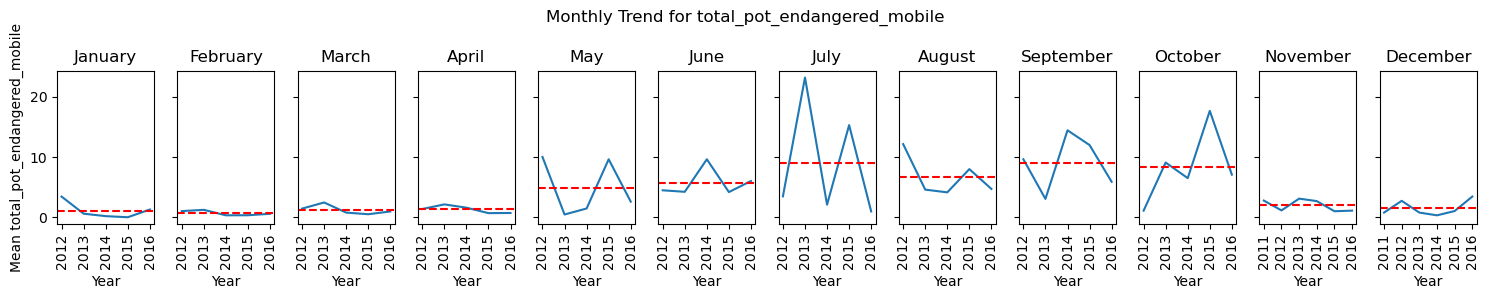

In [ ]:
# see how the label changes over the months and years
endangered_analysis.plot_seasonality()

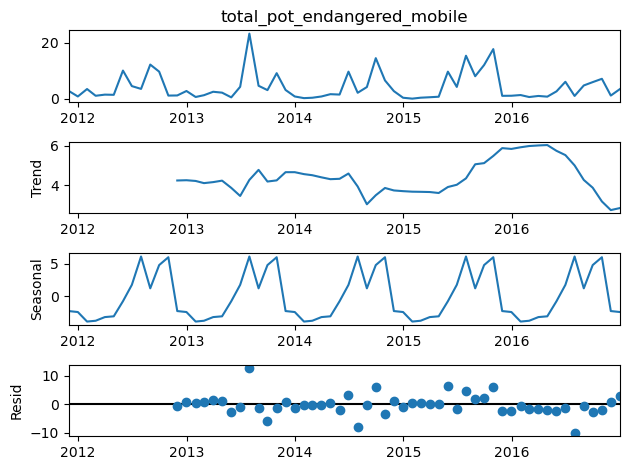

In [ ]:
# view the seasonality through seasonal decomposition
endangered_analysis.plot_seasonal_decomposition()

In [ ]:
# train a SARIMA model (no external variables) using pmdarima to fine tune the hyperparameters
endangered_analysis.train_auto_sarima()

ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(2, 0, 0, 12),
      suppress_warnings=True)

MAE: 3.9617631507237783
MAPE: 5.630484709802653
RMSE: 5.453878198197746


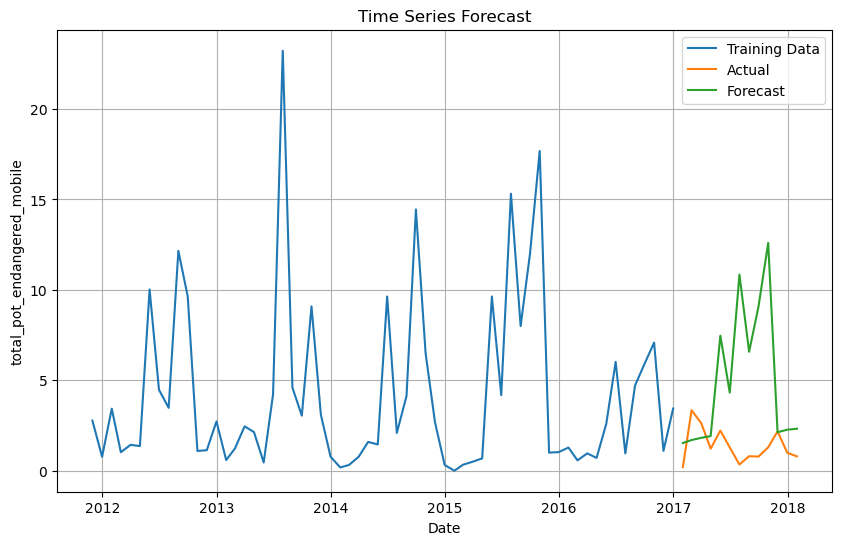

In [ ]:
# plot the forecast
endangered_analysis.forecast()

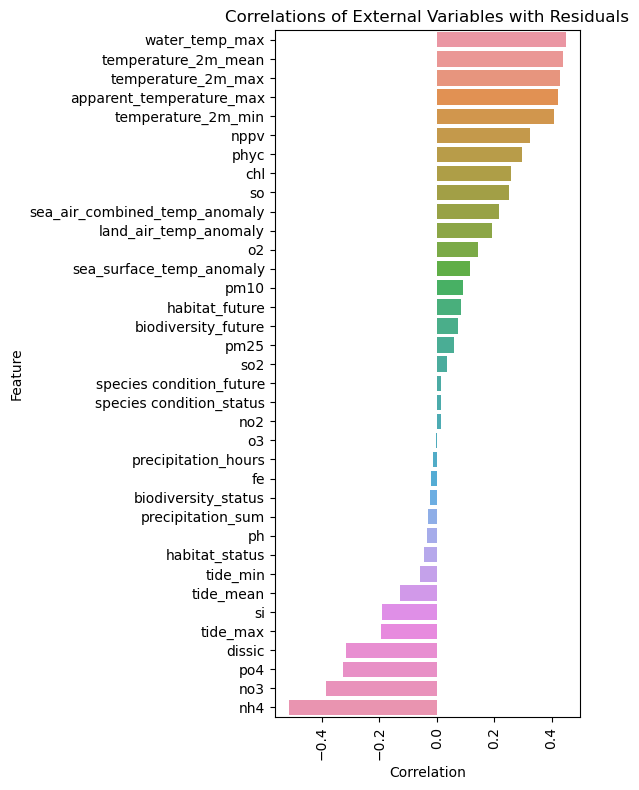

In [ ]:
# carry out a form of seature selection by comparing the correlation of the residuals with the external variables
endangered_analysis.residual_analysis()

In [ ]:
# based of the residual analysis, choose external variable that correlate with the residuals from the training set
endangered_analysis.train_exog_sarima(["water_temp_max", "no3_lag3", "nh4_lag3"])

MAE: 3.846535539410307
MAPE: 5.492817737964023
RMSE: 5.13279246427379


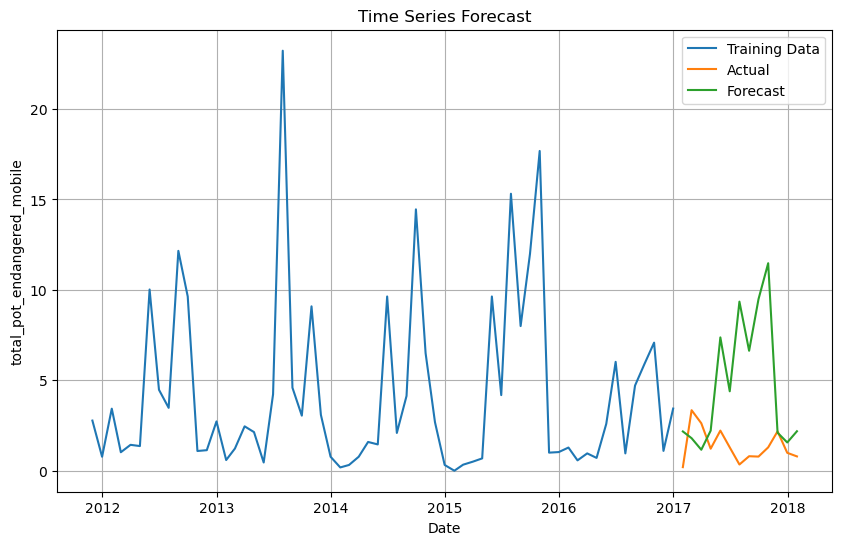

In [ ]:
# forcast with exog variables
endangered_analysis.forecast(model_type="SARIMAX")

#### Auto Arima with EXOGs

An auto arima model with several possible exog features was trained, but the performance did beat the one derived from feature importance

MAE: 0.2192396191072133
MAPE: 0.11202896601472483
RMSE: 0.26540998156095413


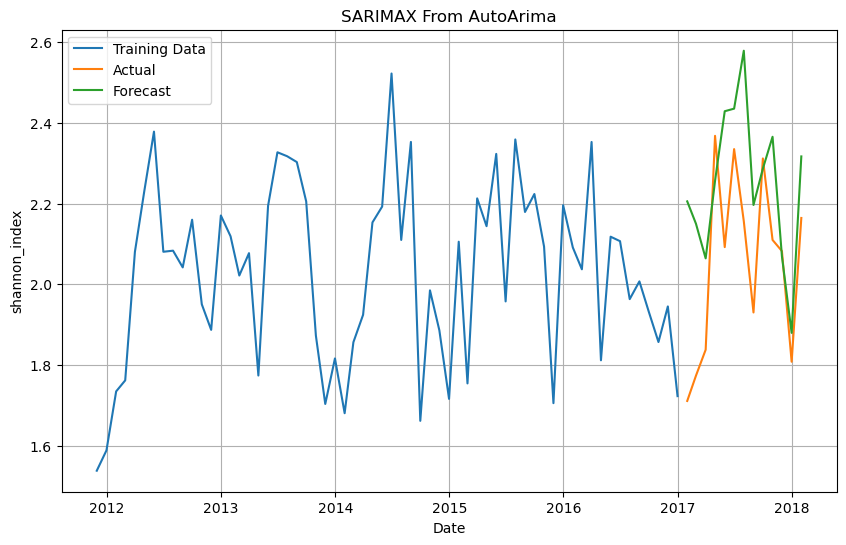

In [ ]:
# Fit your model
model = pm.auto_arima(y_train, X=X_train[exog_features], seasonal=True, m=12)

# extract best params
best_params = model.get_params()
best_params
# evaluate
y_pred = model.predict(
    y_test.shape[0], X=X_test[exog_features]
)  # predict N steps into the future
results_df = evaluate_predictions(results_df, y_pred, y_test, "SARIMAX From AutoArima")
plot_forecast(y_train, y_pred, actual=y_test, title="SARIMAX From AutoArima")